In [2]:
!pip install simple_colors

# Predicting RUL of EV Batteries

In this project, we apply Data Analysis and Machine Learning techniques to predict the **Remaining Useful Life (RUL)** of EV Batteries. We have used the Battery Degradation dataset available at the [Prognostic Centre of Excellence (PCoE)](http://ti.arc.nasa.gov/project/prognostic-data-repository).

In [3]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmath
import seaborn as sns
from simple_colors import *
sns.set()

### Data Description
4 Li-ion batteries were run through 3 operational profiles - charge, discharge and impedance at room temperature.

1. Charging Profile - Each battery was charged a constant current (CC) of 1.5A till the battery voltage reached 4.2V. It was then charged in constant voltage (CV) mode until the charge current dropped to 20mA
2. Discharge Profile - Discharge was carried out at 2A CC until the battery voltage droped to 2.7V, 2.5V, 2.2V and 2.5V for each battery respectively
3. Impedance Profile - Used electrochemical impedance spectroscopy (EIS) sweeps from 0.1Hz to 5kHz

Each battery is subjected to 168 charge-discharge cycles which results in accelerated aging. The experiments were stopped once battery capacity diminished by 30% i.e. from 2 Ahr to 1.4 Ahr.

### Measurements
1. Charging fields
    * Battery terminal voltage (Volts)
    * Battery output current (Amps)
    * Battery temperature (°C)
    * Current measured at charger (Amps)
    * Voltage measured at charger (Volts)
    * Measurement time stamps (secs)
    
    
2. Discharging fields
    * Battery terminal voltage (Volts)
    * Battery output current (Amps)
    * Battery temperature (°C)
    * Current measured at load (Amps)
    * Voltage measured at load (Volts)
    * Measurement time stamps (secs)
    * **Battery capacity (Ahr) for discharge till 2.7V**

## Exploratory Data Analysis (EDA)

The data available is in a MATLAB structure and for ease of analysis, we used the [pymatreader](https://pypi.org/project/pymatreader/) module to load the data in Python and then export the dataframes as pickle (```.pkl```) files. In case the user would like to load data directly from the ```.mat``` files, please import the required function from the ```pymatreader``` library using: <br>
```from pymatreader import read_mat``` <br>
and use the following code as a replacement for all ```pd.read_pickle``` calls: <br>
```data = read_mat('path_to_file/B0005.mat')``` <br>
```df = pd.DataFrame(data['B0005']['cycle'])```

The data is separated into three dataframes for charge, discharge and impedance measurements respectively.
Discharge data will be used for the purposes of RUL prediction while Impedance data will be used to explain the internal mechanisms resulting in battery degradation.

In [4]:
df = pd.read_pickle('B0005.pkl')
df

type  ambient_temperature         time  \
0       charge                   24        0.000   
1    discharge                   24     8243.672   
2       charge                   24    12574.063   
3    discharge                   24    23730.485   
4       charge                   24    28042.891   
..         ...                  ...          ...   
611  discharge                   24  4761863.438   
612     charge                   24  4769141.844   
613  discharge                   24  4779444.204   
614  impedance                   24  4782370.719   
615     charge                   24  4831284.125   

                                                  data  
0    {'Voltage_measured': [3.873017221300996, 3.479...  
1    {'Voltage_measured': [4.191491807505295, 4.190...  
2    {'Voltage_measured': [3.3250546568448542, 3.00...  
3    {'Voltage_measured': [4.189773213846608, 4.188...  
4    {'Voltage_measured': [3.3526036599987754, 3.03...  
..                                                 ...  
611  {'Voltage_measured': [4.18482689434833, 4.1843...  
612  {'Voltage_measured': [3.7032033475672854, 3.33...  
613  {'Voltage_measured': [4.201968615940368, 4.200...  
614  {'Sense_current': [(839.7420654296875-31.55541...  
615  {'Voltage_measured': [0.23635618415267867, 0.0...  

[616 rows x 4 columns]

In [5]:
# Print number of records (rows) and columns in the dataframe
print("Number of records:", len(df.index))
print("Number of columns:", len(df.columns))
print("---------------------")

# Printing the data type of each variable/column
print("Datatype of each column")
df.dtypes

Number of records: 616
Number of columns: 4
---------------------
Datatype of each column


type                    object
ambient_temperature      int64
time                   float64
data                    object
dtype: object

In [6]:
# Checking for missing values in columns type, ambient_temperature and date
# We do not check for data immediately because the entries in data are
# Python dictionaries
df[['type', 'ambient_temperature', 'time']].isna().sum()

type                   0
ambient_temperature    0
time                   0
dtype: int64

Column **type** indicates what cycle is being experimented with. Column **ambient_temperature** contains the temperature in which the experiment was performed. 24 degrees is consistent with the dataset description. We can plot a histogram to check for variability in column **type** and **ambient_temperature**.

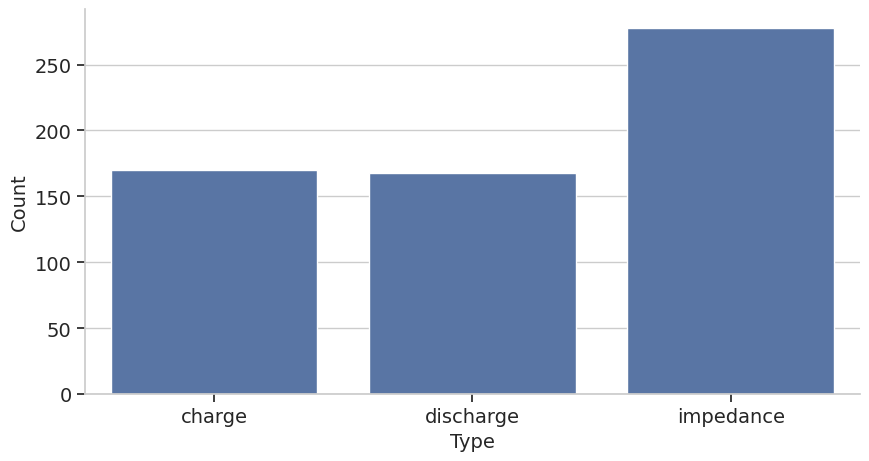

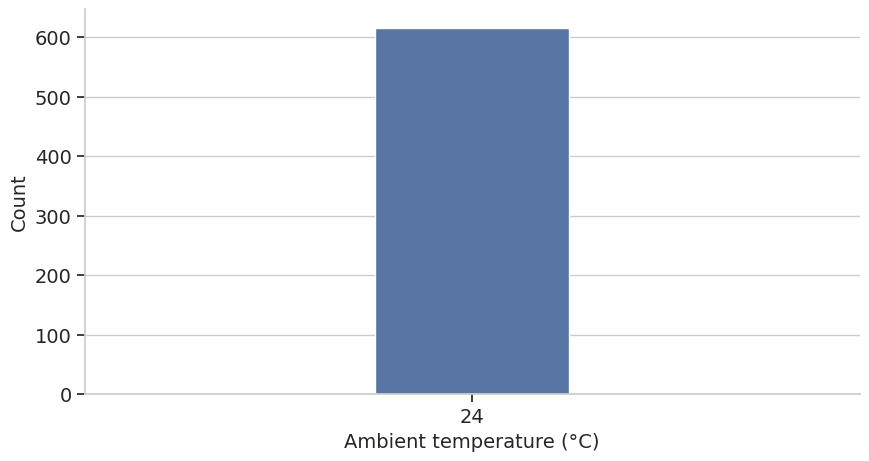

In [7]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params)
# Function to make a histogram plot for different columns in the data
def change_width(ax, new_value):
    '''
    Takes in a matplotlib axis object used for plotting a histogram/bar plot
    and changes the width of the bars

    Arguments:
    ax -- matplotlib axis object
    new_value -- float, the desired width of the histogram bars
    '''

    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # Changing the bar width
        patch.set_width(new_value)

        # Recentering the bar
        patch.set_x(patch.get_x() + diff * .5)

def plot_histogram(df, col, width = 0):
    '''
    Plots a histogram of the specified column of the dataframe

    Arguments:
    df -- pandas DataFrame object
    col -- string, label of a column in the "df" dataframe
    width -- float, if not equal to zero, the width of the bars in the histogram are modied
    '''

    plt.figure(figsize=(10, 5))
    ax = sns.countplot(data = df, x = col, dodge = False)
    ax.yaxis.tick_left()
    ax.xaxis.tick_bottom()

    # Change axis labels
    plt.ylabel('Count', fontsize=14)
    if col == 'ambient_temperature': plt.xlabel(col.capitalize().replace('_', ' ') + ' (°C)', fontsize=14)
    else: plt.xlabel(col.capitalize(), fontsize=14)
    # Change tick sizes
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    if width != 0: change_width(ax, width)
    plt.show()

plot_histogram(df=df, col='type')
plot_histogram(df=df, col='ambient_temperature', width = 0.25)

In column **type**, charge and discharge are evenly distributed which is consistent with the fact that the battery is being charged then discharged. Column **ambient_temperature** only contains 24°C which tells us the experimental conditions were consistent across multiple cycles. Note that ambient temperature is not the same as battery temperature.

Column **time** contains the experiment start time in MATLAB date time format (YYYY-mm-dd-HH-mm-ss.s). It is clear that there was a time gap between the charge and discharge cycles during which the battery was rested. **Data** is the column of interest which contains information about each cycle in a list format. Although we will focus on discharge data to predict RUL, we will also plot the data in the charge and impedance cycles.

In [10]:
# This function splits the data into three dataframes containing charge, discharge and impedance data
def split_data(cell_number):
    '''
    Takes cell number as input and return three dataframes containing the different types of data in the
    corresponding .pkl datafile

    Arguments:
    cell_number -- integer, should be one of 5, 6, 7, 18 (.pkl files corresponding to the above mentioned cells are available)

    Returns:
    charge -- pandas DataFrame object, contains the data of type "charge" pulled from the specified .pkl file
    discharge -- pandas DataFrame object, contains data of type "discharge"
    impedance -- pandas DataFrame object, contains data of type "impedance"
    '''
    num = '0' + str(cell_number) if cell_number != 18 else '18'
    df = pd.read_pickle('B00' + num + '.pkl')
    #df = pd.DataFrame(data['B00' + num]['cycle'])

    charge = df[df['type'] == 'charge']
    discharge = df[df['type'] == 'discharge']
    impedance = df[df['type'] == 'impedance']

    return charge, discharge, impedance

In [11]:
charge, discharge, impedance = split_data(cell_number = 5)

### Charging Cycle

We begin by plotting fields from the charging data for different cycles. This helps us understand the effects of battery degradation on charging performance.

In [12]:
# This function returns a dataframe containing the measurements and
# the corresponding datatype stored depending on the "level".

def get_dtypes(df, col2, level = 1, exclusions = []):
    '''
    Takes a dataframe and a column and returns a dataframe containing data types present in the specified column
    of the dataframe subject to conditions.

    Arguments:
    df -- pandas DataFrame object
    col2 -- string, label of a columns in the df dataframe
    level -- integer, specifies whether the function should return the data type of
             the data in the column (level 1), or in the case that the data type is an array,
             return the data type of the data present within the array (level 2).
    exclusions -- list, if level is not 1, the function will treat the data in the
                  column as arrays. This exclusions list will contain those rows
                  which have non-array entitities so that a level 2 analysis is
                  skipped for them. (These row labels are obtained after running
                  a level 1 analysis)

    Returns:
    pandas DataFrame object containing row names and corresponding data types
    '''
    col1 = 'Measurements'
    dtypes = []
    keys = []
    if level == 1:
        for key in df.iloc[0]['data'].keys():
            keys.append(key)
            dtypes.append(str(type(df.iloc[0]['data'][key])))
    else:
        for key in df.iloc[0]['data'].keys():
            if not (key in exclusions):
                keys.append(key)
                dtypes.append(df.iloc[0]['data'][key].dtype)

    return pd.DataFrame((keys, dtypes), index = [col1, 'Datatype']).transpose()

In [13]:
# List the types of measurements made in the charging cycle
print(blue('Measurements made with the type of data stored in it:', 'bold'))

# Printing the type of each key
get_dtypes(charge, 'Datatype', level = 1)

Measurements made with the type of data stored in it:


Measurements                 Datatype
0      Voltage_measured  <class 'numpy.ndarray'>
1      Current_measured  <class 'numpy.ndarray'>
2  Temperature_measured  <class 'numpy.ndarray'>
3        Current_charge  <class 'numpy.ndarray'>
4        Voltage_charge  <class 'numpy.ndarray'>
5                  Time  <class 'numpy.ndarray'>

In [14]:
# All the data is in numpy arrays so we also print the datatype
# of the data in those arrays
get_dtypes(charge, 'Datatype', level = 2)

Measurements Datatype
0      Voltage_measured  float64
1      Current_measured  float64
2  Temperature_measured  float64
3        Current_charge  float64
4        Voltage_charge  float64
5                  Time  float64

We observe that every dictionary value is a Python list consisting of time series data of datatype float. **Time** gives the instants at which a measurement was made.

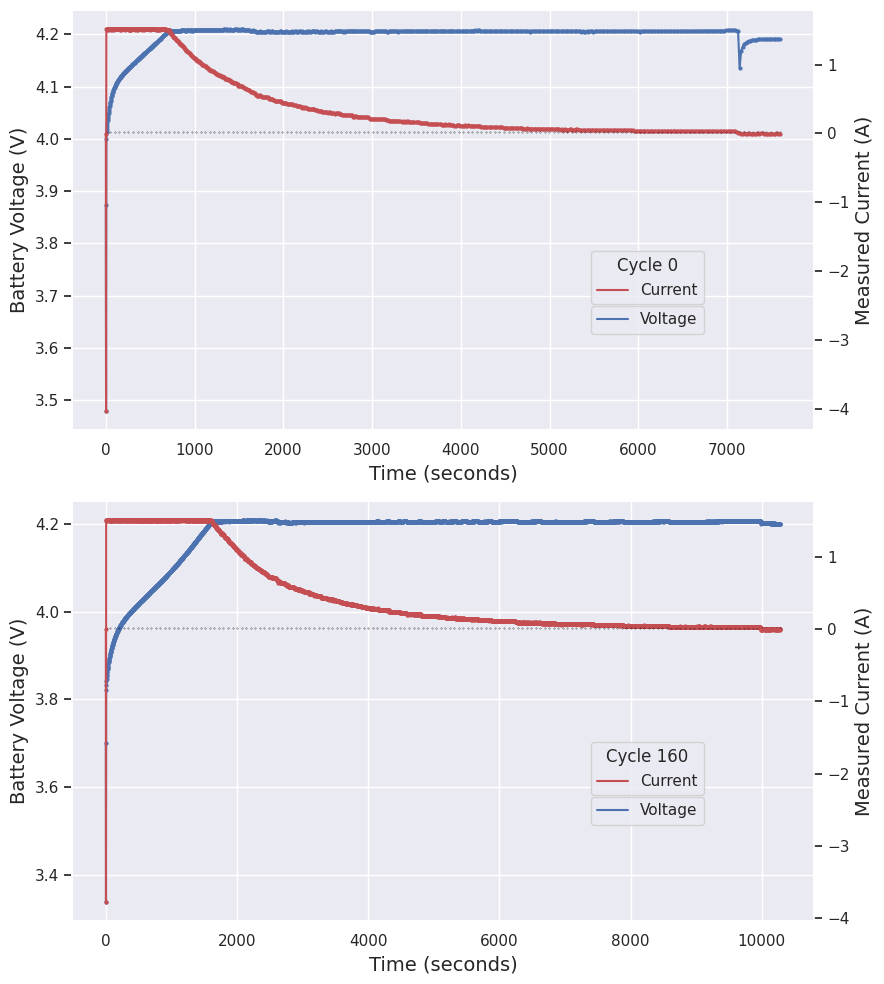

In [15]:
sns.set()
# Plot voltage and current variation for the charging cycle
time0 = charge.iloc[0]['data']['Time'] # Measurement time samples for each run
voltage0 = charge.iloc[0]['data']['Voltage_measured']
current0 = charge.iloc[0]['data']['Current_measured']

time160 = charge.iloc[160]['data']['Time'] # Measurement time samples for each run
voltage160 = charge.iloc[160]['data']['Voltage_measured']
current160 = charge.iloc[160]['data']['Current_measured']

voltages = {0: voltage0, 1: voltage160}
currents = {0: current0, 1: current160}
times = {0: time0, 1: time160}
cycles = {0: 0, 1: 160}

fig, axes = plt.subplots(2, 1, figsize=(9, 10))
axes_2 = [0,0]

for i in [0,1]:
    axes[i].set_xlabel('Time (seconds)', fontsize=14)
    axes[i].set_ylabel('Battery Voltage (V)', fontsize=14)
    axes[i].plot(times[i], voltages[i], label = 'Voltage')
    axes[i].scatter(times[i], voltages[i], s = 4)
    axes[i].legend(loc = (0.7,0.23))

    axes_2[i] = axes[i].twinx()
    axes_2[i].set_ylabel('Measured Current (A)', fontsize=14)
    axes_2[i].plot(times[i], currents[i], label = 'Current', color = 'r')
    axes_2[i].scatter(times[i], currents[i], s = 4, color = 'r')
    axes_2[i].grid(False)
    axes_2[i].scatter(np.linspace(0,times[i][-1],150), [0.02 for i in range(150)], s = 0.05, color = 'black')
    axes_2[i].legend(title = f'Cycle {cycles[i]}', loc = (0.7,0.3))

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

From the above plots, we confirm that the battery is being charged at constant current upto 4.2V after which it is charged at constant voltage as the current measured falls. Comparing plots between different cycles, we observe that the battery takes longer to charge as it degrades which is indicated by a longer time for the battery voltage to reach 4.2V. We do not explicitly plot the current and voltage measured at the charger since we expect the plots to be similar to what we see above.

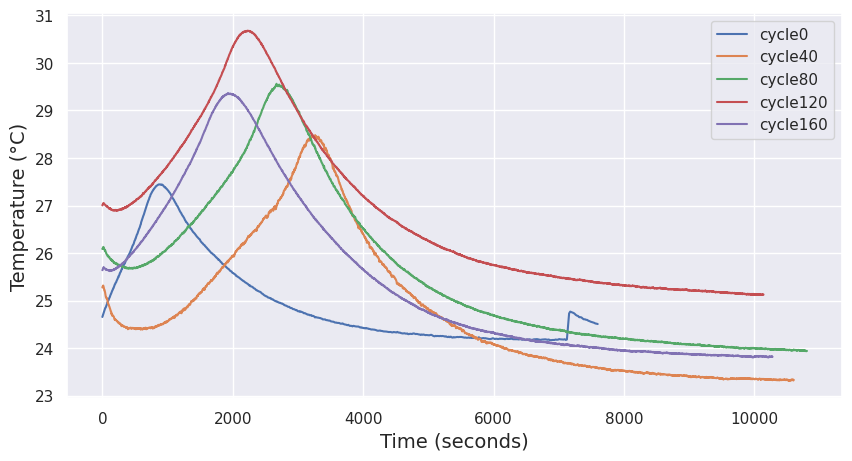

In [16]:
# Temperature variation during charging cycle
plt.figure(figsize=(10, 5))

cycles = [0, 40, 80, 120, 160]
for cycle in cycles:
  time = charge.iloc[cycle]['data']['Time']
  data = charge.iloc[cycle]['data']['Temperature_measured']

  plt.plot(time, data, label=f'cycle{cycle}', linewidth=1.5)
  plt.xlabel('Time (seconds)', fontsize=14)
  plt.ylabel('Temperature (°C)', fontsize=14)

plt.legend()
plt.show()

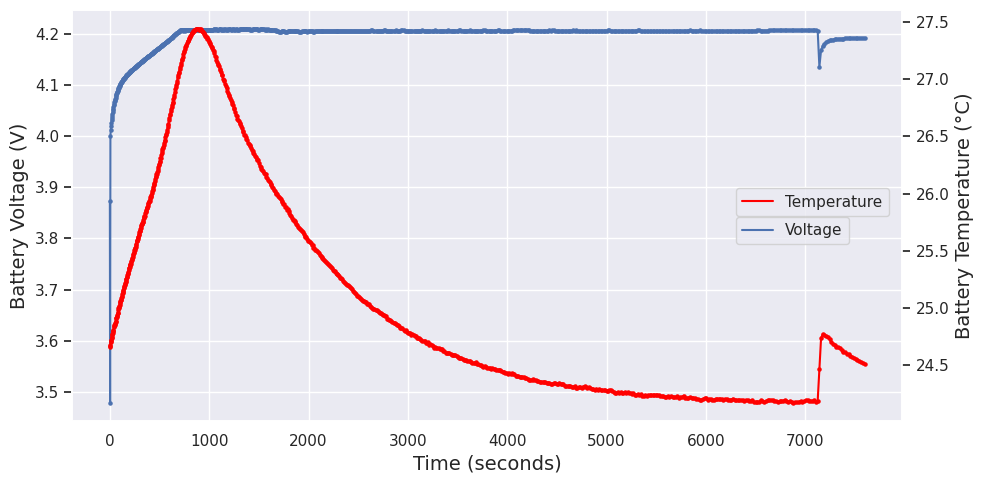

In [17]:
# Plotting temperature and discharge on the same plot
measured_voltage = charge.iloc[0]['data']['Voltage_measured']
measured_temperature = charge.iloc[0]['data']['Temperature_measured']
time = charge.iloc[0]['data']['Time']

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Time (seconds)', fontsize=14)
ax1.set_ylabel('Battery Voltage (V)', fontsize=14)
ax1.plot(time, measured_voltage, label='Voltage')
ax1.scatter(time, measured_voltage, s=5)
ax1.legend(loc = (0.8,0.43))

ax2 = ax1.twinx()

ax2.set_ylabel('Battery Temperature (°C)', fontsize=14)
ax2.plot(time, measured_temperature, color='red', label='Temperature')
ax2.scatter(time, measured_temperature, color='red', s=5)
ax2.legend(loc = (0.8,0.5))
ax2.grid(False)

fig.tight_layout()
plt.show()

There doesn't seem to be a strong correlation between temperature in the charging cycle and battery degradation although the general trend is similar: temperature increases during the constant current phase and decreases in the constant voltage phase.

### Impedance Cycle

#### Background
Electrochemical impedance is measured by applying a small AC voltage over a wide-range of frequencies to a cell and measuring the current through it. The signal is kept small to ensure that the cell behaves pseudo-linearly. Impedance is a complex quantity and is specified by its magnitude and phase.

From the dataset description, AC currents of frequencies between 0.1Hz and 5kHz are applied to estimate battery impedance. This is then used to obtain **Electrolytic** and **Charge-transfer** resistances at different stages of degradation.

1. Electrolytic resistance is the resistance of the electrolyte
2. Charge-transfer resistance is the resistance faced by ions when they are transferred between different compounds in the cell

In [18]:
# List the types of measurements made in the charging cycle
print(blue('Measurements made with the type of data stored in it:', 'bold'))

# Printing the type of each key
get_dtypes(impedance, 'Type', level = 1)

Measurements made with the type of data stored in it:


Measurements                 Datatype
0        Sense_current  <class 'numpy.ndarray'>
1      Battery_current  <class 'numpy.ndarray'>
2        Current_ratio  <class 'numpy.ndarray'>
3    Battery_impedance  <class 'numpy.ndarray'>
4  Rectified_Impedance  <class 'numpy.ndarray'>
5                   Re          <class 'float'>
6                  Rct          <class 'float'>

_Sense_current_, _Battery_current_, _Current_ratio_, _Battery_impedance_, _Rectified_Impedance_ are numpy arrays while _Re_ (electrolytic resistance), _Rct_ (charge-transfer resistance) are float values. We also print the datatype of the numpy arrays to confirm that those quantities are complex numbers.

In [19]:
# Printing the datatype of each key which is an array.
# Re and Rct are of type float so they will be excluded
get_dtypes(impedance, 'Datatype', level = 2, exclusions = ['Re', 'Rct'])

Measurements    Datatype
0        Sense_current  complex128
1      Battery_current  complex128
2        Current_ratio  complex128
3    Battery_impedance  complex128
4  Rectified_Impedance  complex128

We move on to plot _Sense_current_, _Battery_current_, _Current_ratio_, _Battery_impedance_, _Rectified_Impedance_ for different runs while _Re_, _Rct_ are plotted as a function of runs since these are floating-point numbers.

In [20]:
# Helper function for plotting impedance characteristics
def plot_impedance_characteristics(df, feature, runs=[0, 80, 160, 240], log_scale=False):
    '''
    Takes dataframe (containing impedance data), feature, and a list of runs as input and plots
    the data stored in it. Since the function is specifically for impedance data, and that has
    data stored in complex format, the graph of the magnitudes is plotted.

    Arguments:
    df -- pandas DataFrame object, should contain impedance data conforming to the required format
    feature -- string, the data corresponding to this feature will be plotted
    runs -- list, plots of the specified feature will be made for all the runs specified in this list
    log_scale -- bool, specifies whether the axes should be log-scaled
    '''
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    if log_scale:
        axes[0].set_xscale('log')
        axes[0].set_yscale('log')
        axes[1].set_xscale('log')
    # Plotting the magnitude for different runs
    for run in runs:
        data = df.iloc[run]['data'][feature]
        data_magnitude = np.abs(data)[5:]

        axes[0].plot(data_magnitude, label=f'run{run}')
        axes[0].legend()

    axes[0].set_title(f'{feature.replace("_", " ").title()} Magnitude plot', fontsize=16)

    # Plotting the phase for different runs
    for run in runs:
        data = df.iloc[run]['data'][feature]
        data_phase = [cmath.phase(data[i]) for i in range(len(data))][5:]

        axes[1].plot(data_phase, label=f'run{run}')
        axes[1].legend()

    axes[1].set_title(f'{feature.replace("_", " ").title()} Phase plot', fontsize=16)
    plt.show()

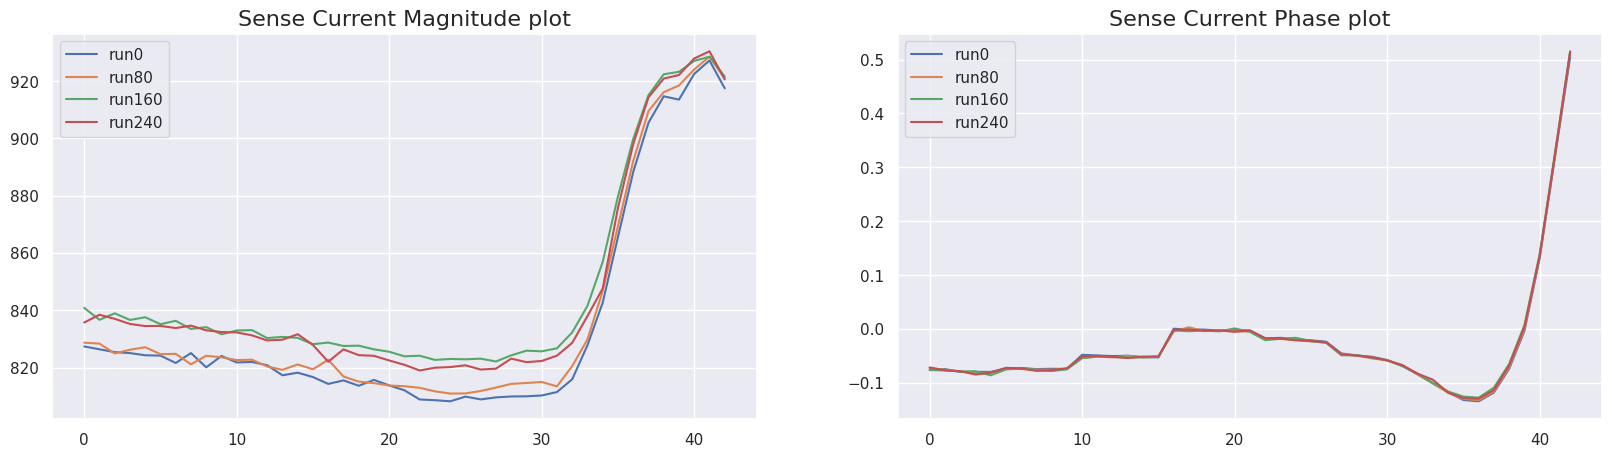

In [21]:
plot_impedance_characteristics(impedance, 'Sense_current')

From the sense current magnitude plot, the magnitude of current applied for different frequencies is almost constant across different runs which is expected since measurements must be made under similar conditions. We repeat the above procedure for **battery current**.

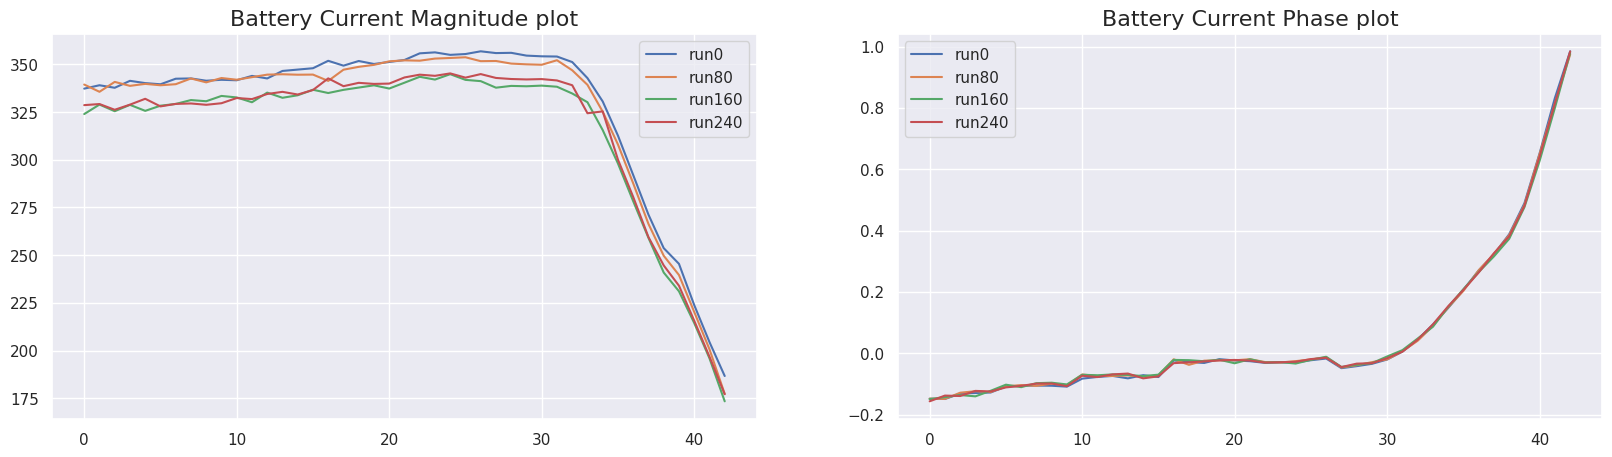

In [22]:
plot_impedance_characteristics(impedance, 'Battery_current')

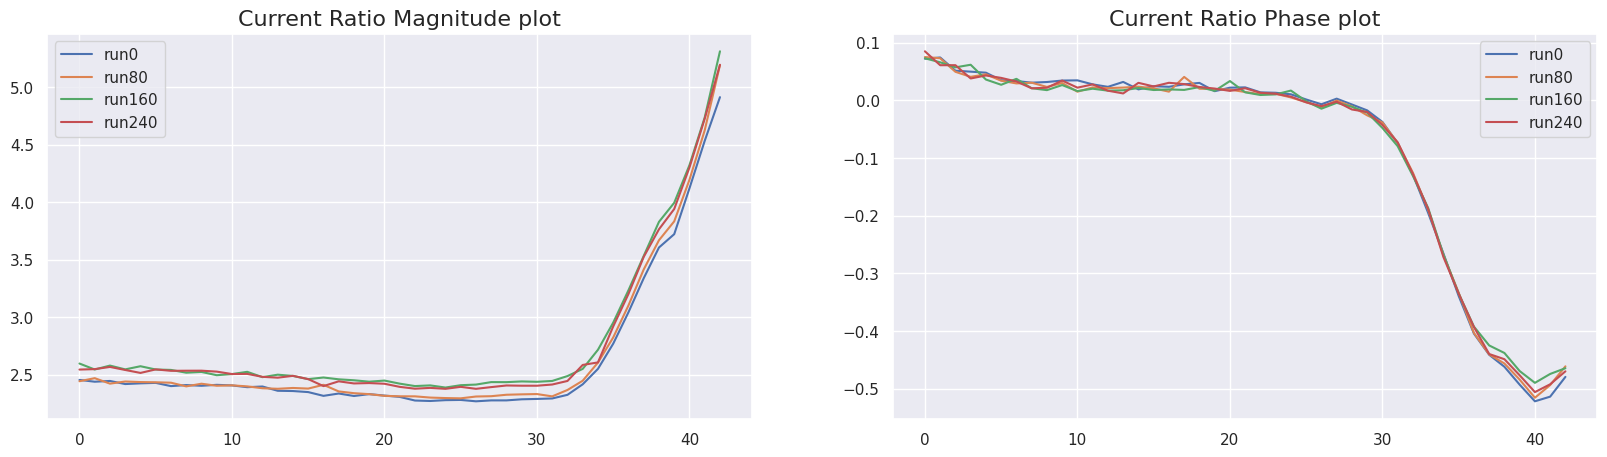

In [23]:
plot_impedance_characteristics(impedance, 'Current_ratio')

So far there doesn't seem to be any visible trend in battery internal parameters as the battery degrades over time.

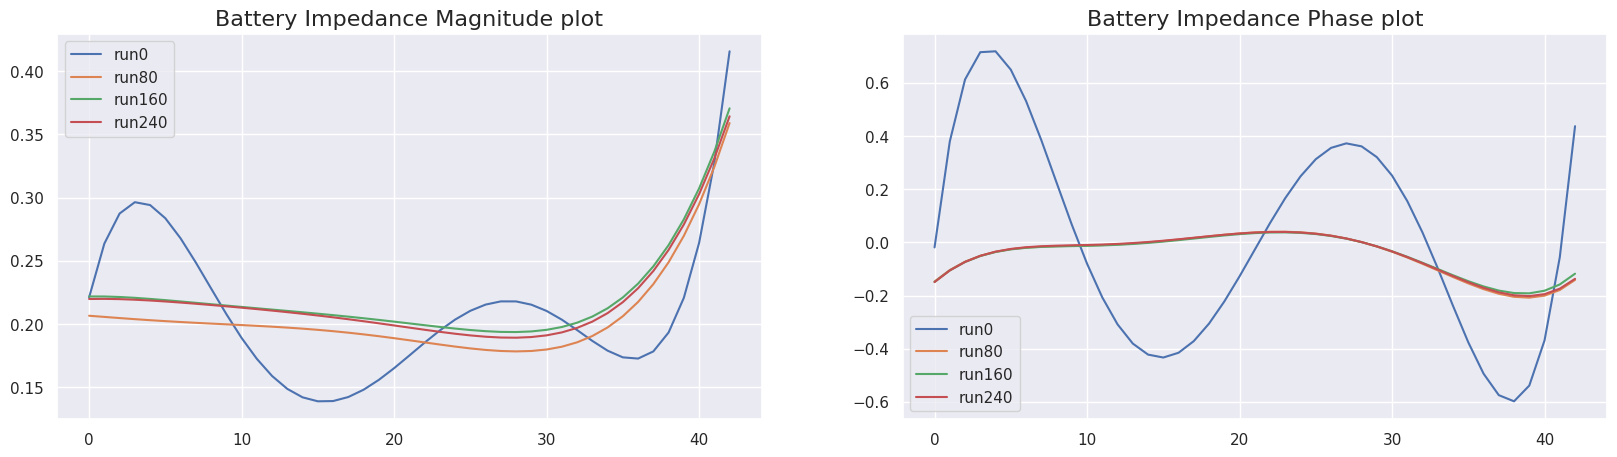

In [24]:
plot_impedance_characteristics(impedance, 'Battery_impedance')

From the Battery Impedance plots, we observe that with time, the impedance stabilises and doesn't oscillate.

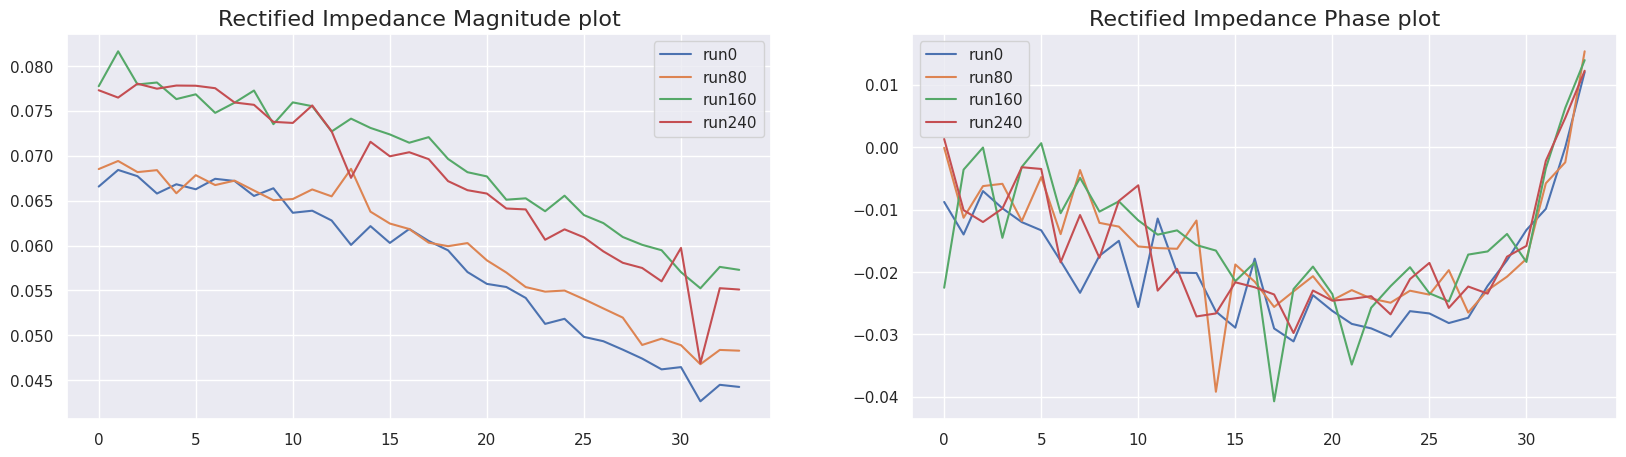

In [25]:
plot_impedance_characteristics(impedance, 'Rectified_Impedance')

Although the phase plot doesn't have any pertinent features, the magnitude plot shows an increase in rectified impedance as the battery deteriorates.

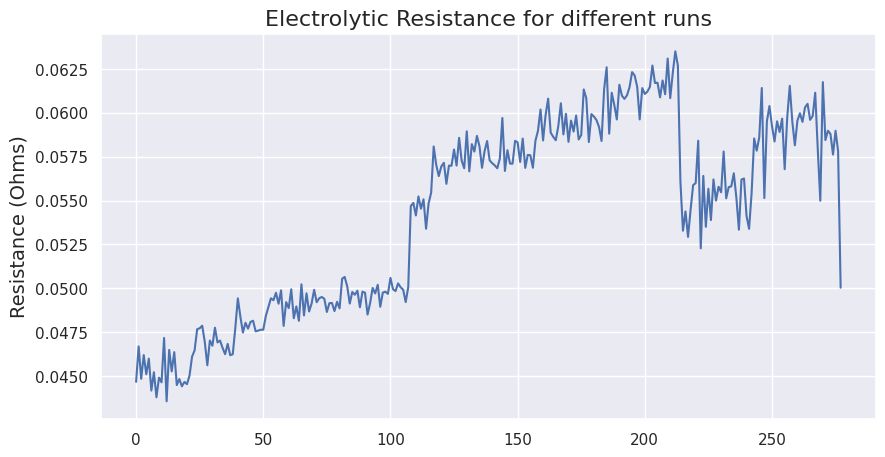

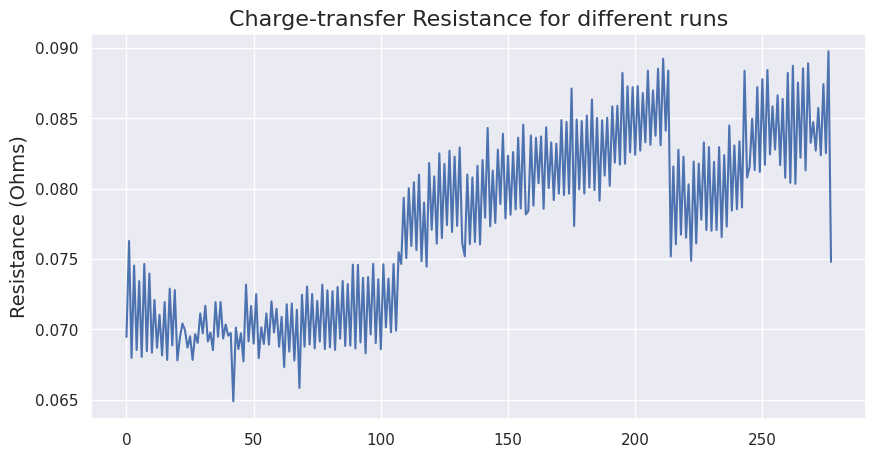

In [26]:
# Helper function to plot resistances as a function of runs
def plot_resistance(df, key):
    '''
    Takes a dataframe (containing impedance data) and key as input and plots the data corresponding
    to the key.

    Arguments:
    df -- pandas DataFrame object, should contain impedance data conforming to the required format
    key -- string, should be one of "Re" or "Rct". The function scans the complete dataframe for
           the required key (each row in the dataframe corresponds to one run, and each run contains
           one value for "Re" and "Rct")
    '''
    resistance = [impedance.iloc[i]['data'][key] for i in range(len(impedance))]

    labels = {
        'Re': 'Electrolytic Resistance',
        'Rct': 'Charge-transfer Resistance'
    }

    plt.figure(figsize=(10, 5))
    plt.title(f'{labels[key]} for different runs', fontsize=16)
    plt.ylabel('Resistance (Ohms)', fontsize=14)
    plt.plot(resistance)

    plt.show()

# Plot the electrolytic and charge-transfer resistance for different runs
plot_resistance(impedance, 'Re')
plot_resistance(impedance, 'Rct')

Instead of directly trying to analyse Impedance, we adopt a different approach where we try and understand **when** has this data been collected (so far we had been referring to different instants as _runs_ but let's try to understand what this means)

In [27]:
impedance.index # Print indices for impedance measurements in the original data

Index([ 40,  42,  44,  46,  48,  50,  52,  54,  56,  58,
       ...
       594, 596, 598, 600, 602, 604, 606, 608, 610, 614],
      dtype='int64', length=278)

We 'zoom' in to different points in the dataframe around the impedance measurements.

In [28]:
df[35:50]

type  ambient_temperature         time  \
35     charge                   24   268433.610   
36  discharge                   24   279067.297   
37     charge                   24   283098.204   
38  discharge                   24   293897.563   
39     charge                   24  1398364.969   
40  impedance                   24  1410431.938   
41  discharge                   24  1411321.875   
42  impedance                   24  1416658.391   
43     charge                   24  1417540.422   
44  impedance                   24  1429569.094   
45  discharge                   24  1430451.079   
46  impedance                   24  1435746.266   
47     charge                   24  1436628.422   
48  impedance                   24  1448655.735   
49  discharge                   24  1449537.782   

                                                 data  
35  {'Voltage_measured': [3.3967166797066484, 3.09...  
36  {'Voltage_measured': [4.188779799856791, 4.188...  
37  {'Voltage_measured': [3.3869430085009946, 3.08...  
38  {'Voltage_measured': [4.189272591516219, 4.188...  
39  {'Voltage_measured': [3.5795499179382677, 3.23...  
40  {'Sense_current': [(-1+1j), (820.6094970703125...  
41  {'Voltage_measured': [4.187614060563439, 4.186...  
42  {'Sense_current': [(-1+1j), (656.5957641601562...  
43  {'Voltage_measured': [3.389085680145772, 3.068...  
44  {'Sense_current': [(-1+1j), (809.5048217773438...  
45  {'Voltage_measured': [4.1876287811083985, 4.18...  
46  {'Sense_current': [(-1+1j), (684.2487182617188...  
47  {'Voltage_measured': [3.380743064766377, 3.062...  
48  {'Sense_current': [(-1+1j), (812.7781982421875...  
49  {'Voltage_measured': [4.187447226312926, 4.186...

We observe that separate impedance measurements are made _after_ charging and _after_ discharging the battery. Let us compare the impedance characteristics after charging and discharing the battery at a particular point.

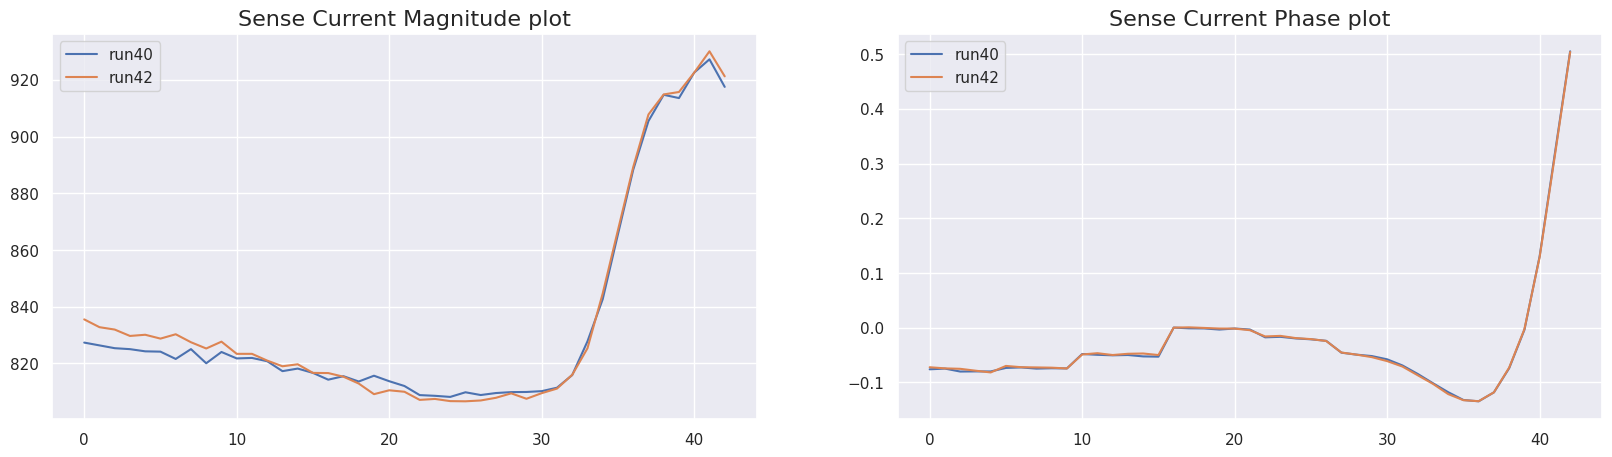

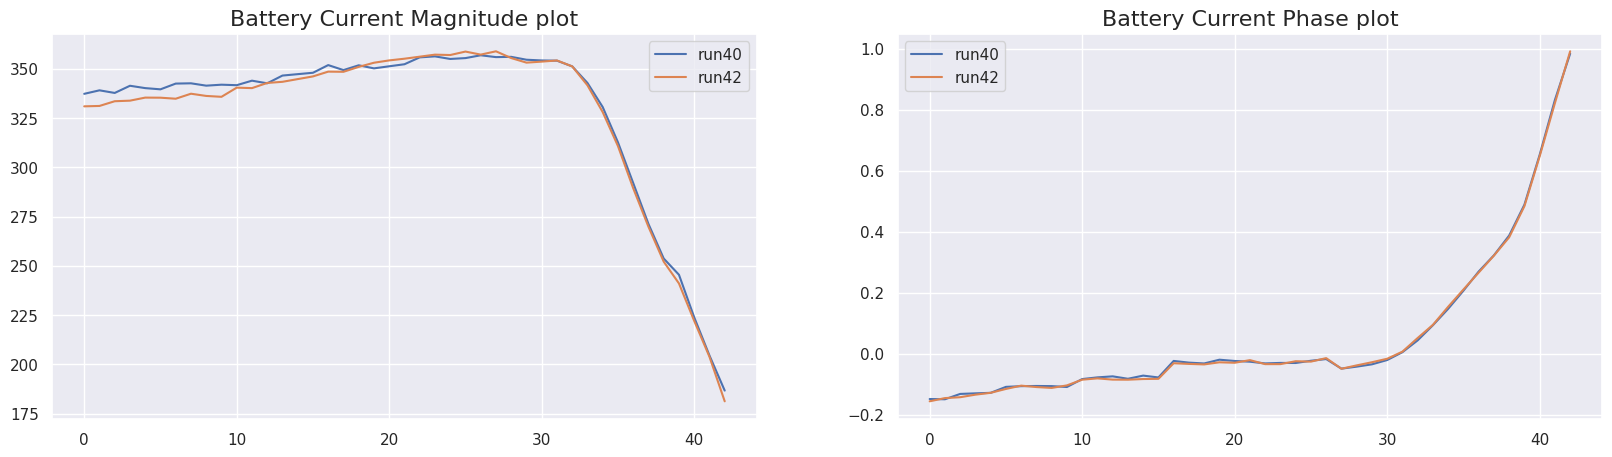

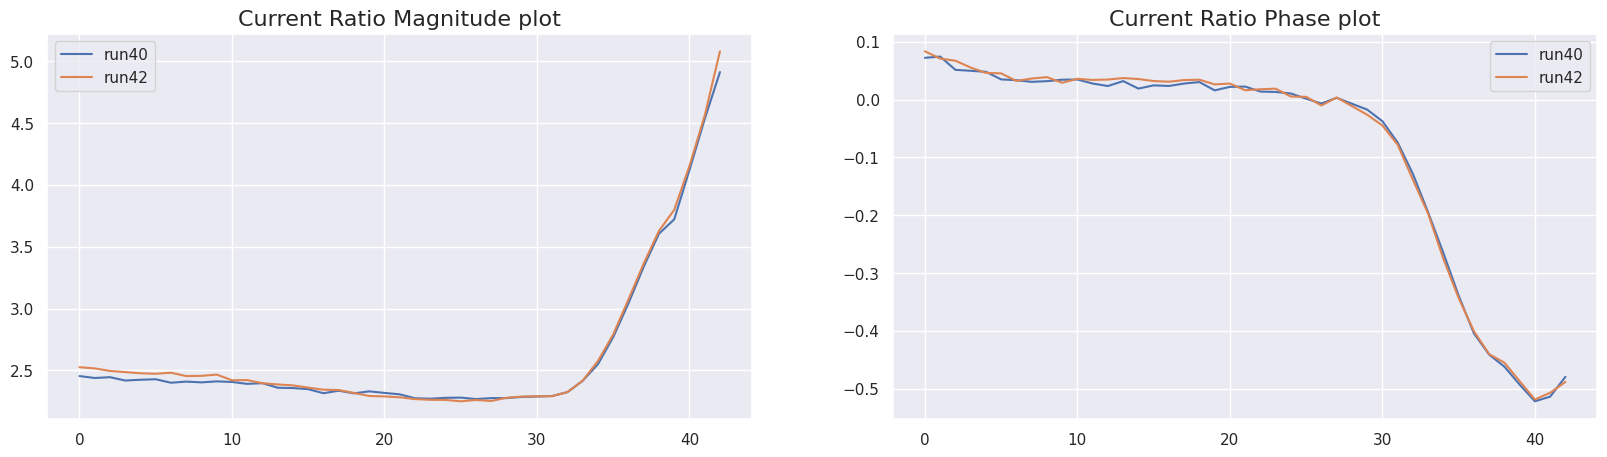

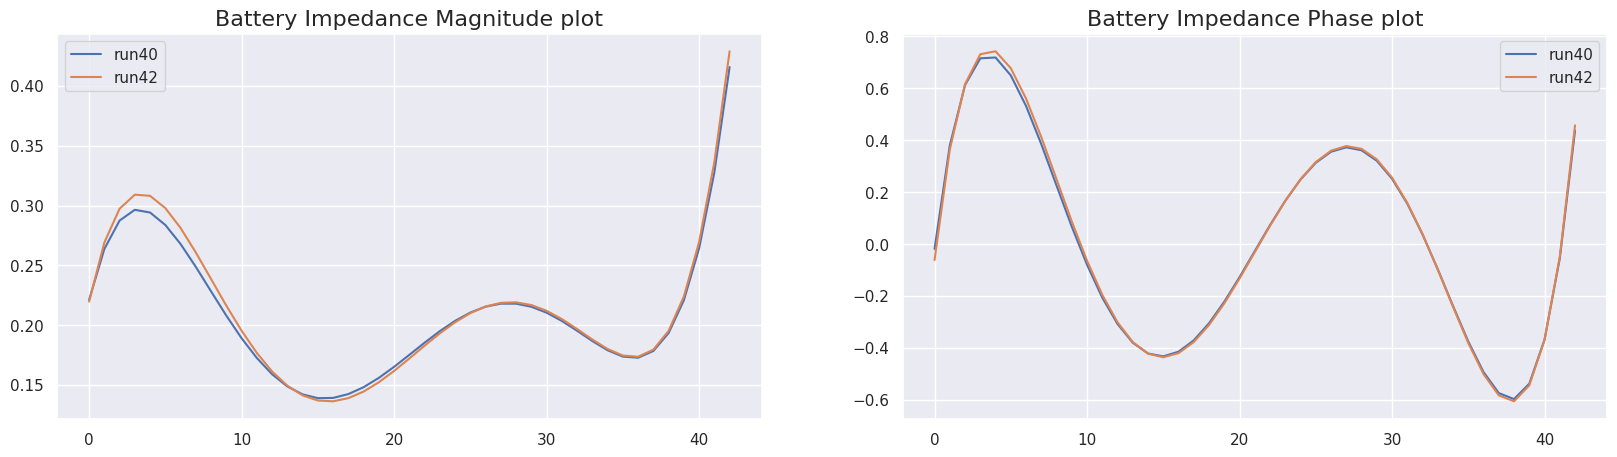

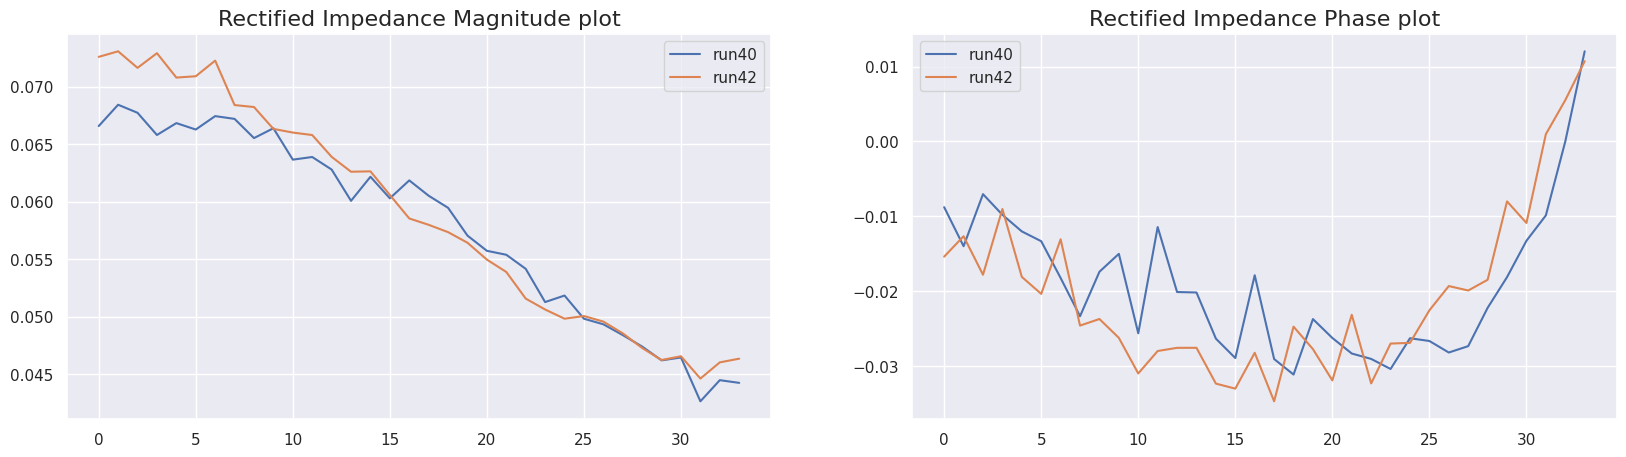

In [29]:
# 40 is an impedance measurement after charging
# 42 is an impedance measurement after discharging
runs = [40, 42]
keys = ['Sense_current', 'Battery_current', 'Current_ratio',
        'Battery_impedance', 'Rectified_Impedance']
for key in keys:
  plot_impedance_characteristics(df, key, runs, log_scale=False) # Plotting the parameters in keys

Nothing seems to stand out from the plots although the electrolytic and charge-transfer resistances have lowered after discharging.

We also experiment with **Nyquist plots** for Battery Impedance and Rectified Impedance. In a Nyquist plot, The real and imaginary parts of a complex number are plotted along separate axes.

In [30]:
def plot_nyquist(df, feature, runs=[0, 80, 160, 240]):
    '''
    Function to make a Nyquist plot for battery and rectified impedance. In a
    Nyquist plot, the real and imaginary parts are plotted against each other.

    Arguments:
    df -- pandas DataFrame object, should contain impedance data conforming to the required format
    feature -- string, the data corresponding to this feature will be plotted
    runs -- list, plots of the specified feature will be made for all the runs specified in this list
    '''
    plt.figure(figsize=(10, 5))
    # Plotting the magnitude for different runs
    for run in runs:
        data = df.iloc[run]['data'][feature]
        data_real = [data[i].real for i in range(len(data))]
        data_imag = [-data[i].imag for i in range(len(data))]

        plt.scatter(data_real, data_imag, label=f'run{run}')
        plt.legend()

    plt.title(f'{feature.replace("_", " ").title()} Nyquist plot', fontsize=16)
    plt.xlabel('Re(Z) Ω', fontsize=14)
    plt.ylabel('-Im(Z) Ω', fontsize=14)
    plt.show()

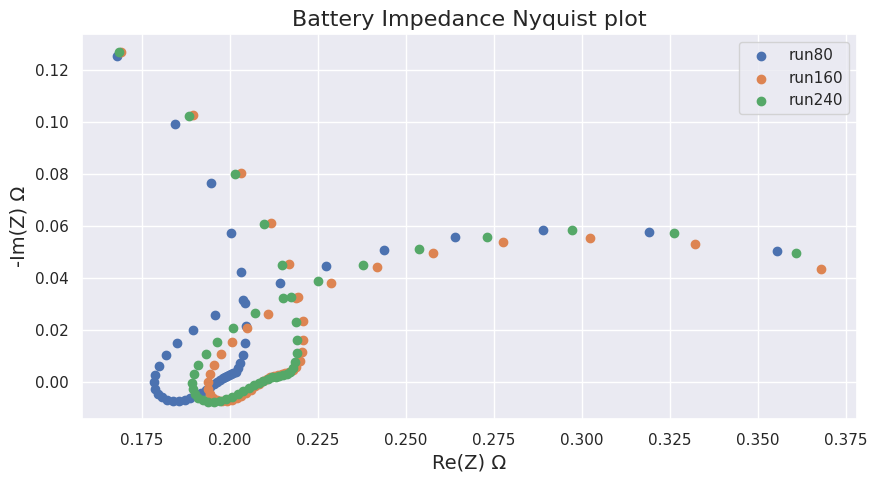

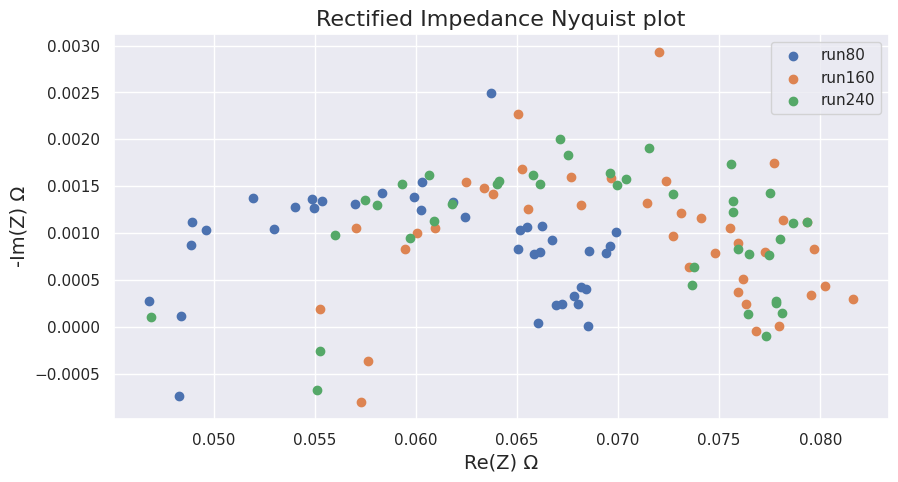

In [31]:
plot_nyquist(impedance, feature='Battery_impedance', runs=[80, 160, 240]) # Plotting the parameters in keys
plot_nyquist(impedance, feature='Rectified_Impedance', runs=[80, 160, 240]) # Plotting the parameters in keys

One takeaway from the above is that the battery resistance seems to be increasing as it discharges.

### Discharge Cycle

We start by plotting features from the discharge cycle to understand the effects of battery degradation. We do not plot the voltage and current at the load because voltage and current measured at the battery give us an indication of the general trend.

In [32]:
# List the types of measurements made in the charging cycle
print(blue('Measurements made with the type of data stored in it:', 'bold'))

# Printing the type of each key
get_dtypes(discharge, 'Datatype', level = 1)

Measurements made with the type of data stored in it:


Measurements                 Datatype
0      Voltage_measured  <class 'numpy.ndarray'>
1      Current_measured  <class 'numpy.ndarray'>
2  Temperature_measured  <class 'numpy.ndarray'>
3          Current_load  <class 'numpy.ndarray'>
4          Voltage_load  <class 'numpy.ndarray'>
5                  Time  <class 'numpy.ndarray'>
6              Capacity          <class 'float'>

Except _capacity_, all features are time series data and will be plotted for different discharge cycles. We also plot capacity as a function of discharge cycles. Note that Battery capacity has been provided at the end of discharge for that particular cycle.

In [33]:
# Printing the datatype of each key which is an array.
# Capacity is of type float so it will be excluded
get_dtypes(discharge, 'Datatype', level = 2, exclusions = ['Capacity'])

Measurements Datatype
0      Voltage_measured  float64
1      Current_measured  float64
2  Temperature_measured  float64
3          Current_load  float64
4          Voltage_load  float64
5                  Time  float64

In [34]:
from matplotlib.patches import Rectangle
# This function plots the data of specified type (voltage, current or temperature)
# for the cycle numbers specified by "cycle_list" argument
sns.set()
def dc_cycle_plots(cell_number, cycle_list, type, figsize = (10,5), only_scatter = False, zoom_beginning_range = None):
    '''
    Creates plots of the specified type of data for the specified number of cycles for the specified cell number.

    Arguments:
    cell_number -- integer, should be one of 5, 6, 7, 18
    cycle_list -- list, contains the required cycle numbers for which the plots should be made
    type -- string, can be one of "voltage", "current", "temperature". The plots for the
            corresponding type will be created after the discharge data is extracted for the
            specified cell number.
    figsize -- tuple, specifies the size of the plot
    only_scatter -- bool, set to True if only the scatter plot is desired
    zoom_beggining_range -- integer, if this argument is not "None", a small subplot will be
                            created for the data sliced from the first value to the value specified.
                            In addition to the subplot, a rectangle will also be created around
                            the initial part of the graph.
                            !! for type = "voltage" only !!
    '''
    _, discharge, _= split_data(cell_number)

    labels = {'voltage': 'Battery terminal voltage (V)',
              'current': 'Battery output current (A)',
              'temperature': 'Battery temperature (°C)'}
    type_ = type.capitalize() + '_measured'

    fig, ax0 = plt.subplots(1, 1, figsize = figsize)

    for cycle in cycle_list:
        time_data = discharge.iloc[cycle]['data']['Time']   # List of times obtained from the "discharge" dataframe
        type_data = discharge.iloc[cycle]['data'][type_]    # Data of the type specified, obtained from the "discharge" dataframe

        if not only_scatter: ax0.plot(time_data, type_data, label = f"cycle {cycle}")
        ax0.scatter(time_data, type_data, s = 5)

    plt.title(f"{type.capitalize()} Measured for cell number {cell_number}", fontsize = 16)
    plt.xlabel("Time (seconds)", fontsize = 14)
    plt.ylabel(labels[type], fontsize = 14)
    plt.legend()

    if zoom_beginning_range != None and type == 'voltage':
        ax0.add_patch(Rectangle((-50,3.9), 200, 0.4, edgecolor = "black", facecolor = "none"))
        ax0.text(200, 4.1, "Initial Sharp Decrease")
        sns.reset_orig()
        ax = fig.add_axes([0.17, 0.3, 0.2, 0.2])
        for cycle in cycle_list:
            time_data = discharge.iloc[cycle]['data']['Time'][:zoom_beginning_range]   # List of times obtained from the "discharge" dataframe
            type_data = discharge.iloc[cycle]['data'][type_][:zoom_beginning_range]    # Data of the type specified, obtained from the "discharge" dataframe

            ax.plot(time_data, type_data)
            ax.scatter(time_data, type_data, s = 1)
            ax.set_xlabel("Magnified portion")
            ax.grid(False)
        sns.set()

    plt.show()

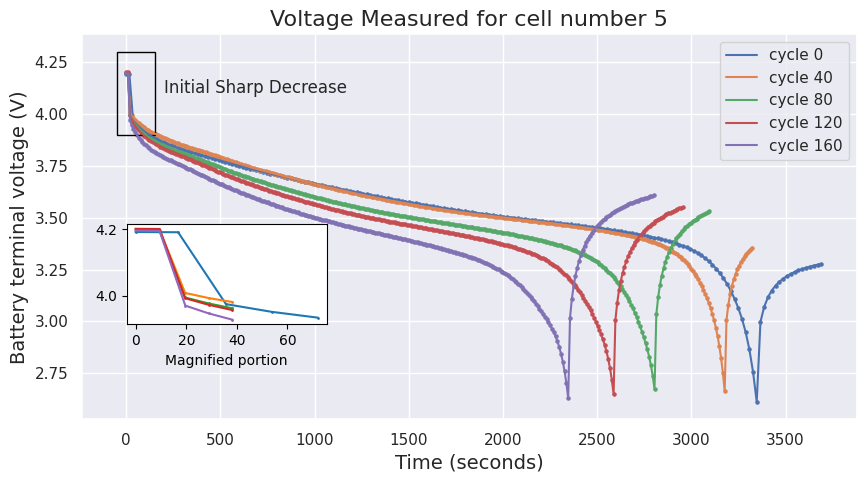

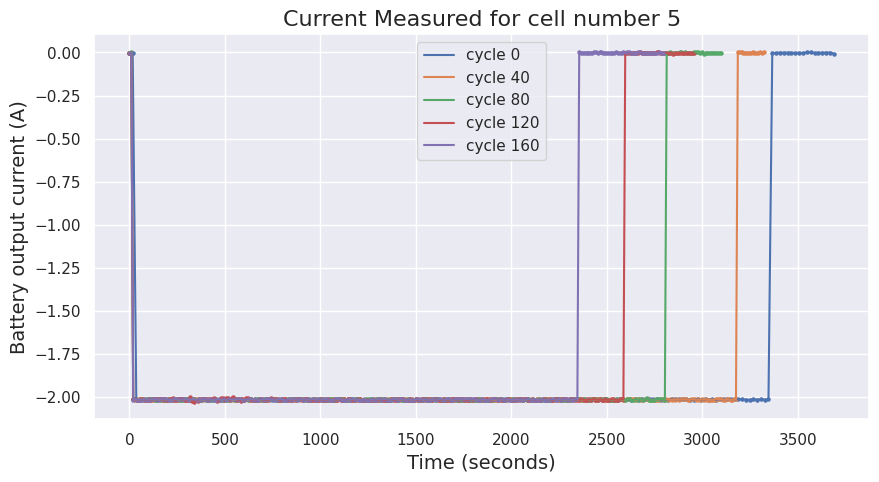

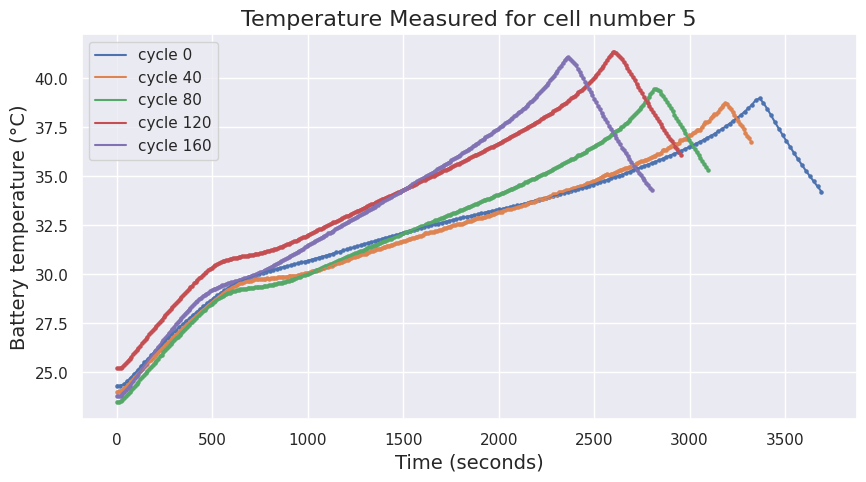

In [35]:
cycles = [0, 40, 80, 120, 160]
figsize = (10,5)

# Observing that voltage has an initial drop, we magnify the initial sharp decrease in voltage measured
dc_cycle_plots(5, cycles, 'voltage', figsize = figsize, only_scatter = False, zoom_beginning_range = 5)

dc_cycle_plots(5, cycles, 'current', figsize = figsize, only_scatter = False)
dc_cycle_plots(5, cycles, 'temperature', figsize = figsize, only_scatter = False)

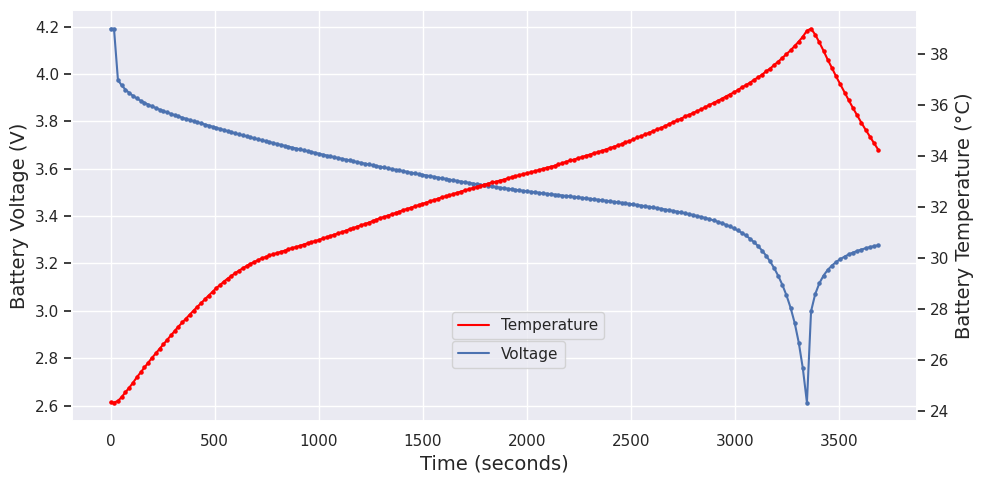

In [36]:
# Plotting temperature and discharge on the same plot
measured_voltage = discharge.iloc[0]['data']['Voltage_measured']
measured_temperature = discharge.iloc[0]['data']['Temperature_measured']
time = discharge.iloc[0]['data']['Time']

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Time (seconds)', fontsize=14)
ax1.set_ylabel('Battery Voltage (V)', fontsize=14)
ax1.plot(time, measured_voltage, label='Voltage')
ax1.scatter(time, measured_voltage, s=5)
ax1.legend(loc = (0.45,0.13))

ax2 = ax1.twinx()

ax2.set_ylabel('Battery Temperature (°C)', fontsize=14)
ax2.plot(time, measured_temperature, color='red', label='Temperature')
ax2.scatter(time, measured_temperature, color='red', s=5)
ax2.grid(False)
ax2.legend(loc = (0.45,0.2))

fig.tight_layout()
plt.show()

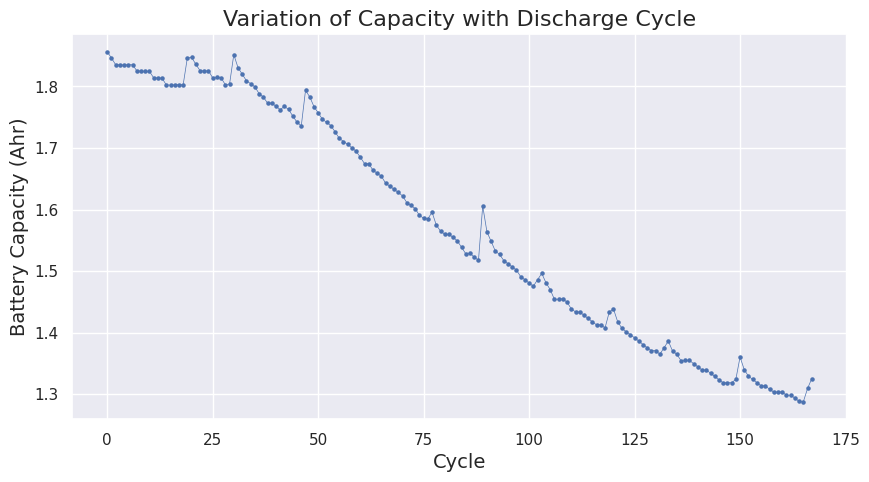

In [37]:
# Plotting capacity as a function of discharge cycles
capacity = [discharge.iloc[i]['data']['Capacity'] for i in range(len(discharge))]

plt.figure(figsize=(10, 5))
plt.title('Variation of Capacity with Discharge Cycle', fontsize=16)
plt.xlabel('Cycle', fontsize=14)
plt.ylabel('Battery Capacity (Ahr)', fontsize=14)

plt.plot(capacity, linewidth=0.5)
plt.scatter(np.arange(0, len(capacity)), capacity, s=5)
plt.show()

We highlight some of the important features in the discharge characteristics.

1. Voltage Measured

We can divide the plot into 4 portions: sharp decrease in the start which appears to be linear followed by a region with reduced slope upto the knee point. An exponential-like drop follows after which the experiment is stopped. The battery voltage begins to rise after this point due to the diffusion of acid from the electrolyte to the plates. The initial steep decline is due to the internal battery impedance on application of the load current. The slope of this portion can be used to estimate this impedance and is consistent with the fact that the battery impedance increases as the battery degrades.

![Voltage graph](https://drive.google.com/uc?export=view&id=1-IxO0kEIyrUpTjVplSP5c0YfwcFulqIk)


2. Temperature Measured

We can divide the plot into 3 portions: steep temperature rise upto a knee point, rise in temperature with a reduced slope till the peak temperature and finally a fall. The fall is due to removal of the load allowing the battery to return to ambient temperature. The first portion can be attributed to a sudden application in the load current.

The regions visualized taking one cycle's voltage and temperature profiles as an example are given below.

![Temperature graph](https://drive.google.com/uc?export=view&id=1FCix6-mjfgR8LVv5Ih2Iqmxec9F4WIkL)

We observe that as the battery deteriorates, it takes less time for the battery to discharge. We also observe that the maximum temperature achieved by the battery increases monotonically as the battery discharges. As the battery degrades, it takes less time for the battery to reach its maximum temperature.

We observe that the discharge has been stopped once the battery voltage drops to 2.6-2.7V. This is because the [Discharge Cutoff Voltage](https://en.wikipedia.org/wiki/Cutoff_voltage) for an 18650 Li-ion battery is 3.0V. The experiment has pushed the batteries beyond this to accelerate degradation effects as mentioned in the dataset description.

### Predicting RUL

We use an indirect approach to estimate RUL. **Battery Capacity** is estimated using measurements made in the discharge cycle. Although capacity can be measured directly, it is infeasible while the electric vehicle is running. On the other hand, voltage and current measurements are easy to make.

We begin by pre-processing the data for feature extraction.
Features extracted:
1. Time instants at which battery voltage hits specified voltage values between 2.7V and 4V
2. Time at which battery is discharged and the load current is stopped
3. Maximum temperature attained by the battery during discharge
4. Time at which battery attains maximum temperature

<a name="ML"></a>

In [39]:
# This function splits the data into three dataframes containing charge, discharge and impedance data
def split_data(cell_number):
    '''
    Takes cell number as input and return three dataframes containing the different types of data in the
    corresponding .pkl datafile

    Arguments:
    cell_number -- integer, should be one of 5, 6, 7, 18 (.pkl files corresponding to the above mentioned cells are available)

    Returns:
    charge -- pandas DataFrame object, contains the data of type "charge" pulled from the specified .pkl file
    discharge -- pandas DataFrame object, contains data of type "discharge"
    impedance -- pandas DataFrame object, contains data of type "impedance"
    '''
    num = '0' + str(cell_number) if cell_number != 18 else '18'
    df = pd.read_pickle('B00' + num + '.pkl')

    charge = df[df['type'] == 'charge']
    discharge = df[df['type'] == 'discharge']
    impedance = df[df['type'] == 'impedance']

    return charge, discharge, impedance

In [40]:
# This function performs the major preprocessing of the data, by picking out the data values
# which will be used for training out of the complete available data
def preprocessing(cell_number, voltage_splits = 16):
    '''
    Extracts features and labels from the data from the specified cell number
    and returns them as numpy arrays

    Arguments:
    cell_number -- integer, should be one of 5, 6, 7, 18
    voltage_splits -- integer, specifies number of values the interval of voltages
                      [2.7, 4] should be split into

    Returns:
    x -- numpy array, contains the feature data. The required features are extracted
         from the discharge data of the specified cell number.
    y -- numpy array, contains the labels corresponding to the features in "x"
    '''
    _, discharge, _ = split_data(cell_number)

    # Default split is 16 which gives the following voltages:
    # [2.7, 2.787, 2.873, 2.96, 3.047,3.13333333, 3.22, 3.307, 3.393,
    # 3.48, 3.567, 3.653, 3.74, 3.827, 3.913, 4.]
    voltages = np.linspace(2.7, 4, voltage_splits)

    # features0 stores the Times at which terminal voltage is 2.7, ..., 4
    # features1 stores the Time to reach minimum terminal voltage
    # feature2 stores the Maximum temperature
    # feature3 stores the Time to reach maximum temperature

    feature0, feature1, feature2, feature3 = [], [], [], []
    for i in range(len(discharge)):
        time_data = discharge.iloc[i]['data']['Time']                       # Getting time data from the discharge dataframe
        voltage_data = discharge.iloc[i]['data']['Voltage_measured']        # Getting voltage data
        temp_data = discharge.iloc[i]['data']['Temperature_measured']       # Getting temperature data

        times = []
        for j in range(voltage_splits):
            time_for_closest_voltage = time_data[np.argmin(np.abs(voltage_data - voltages[j]))]         # time at which the reading stored in "voltage_data" is closest
            times.append(time_for_closest_voltage)                                                      # to one of the values in the "voltages" array

        feature0 = feature0 + [times]
        feature1.append(time_data[np.argmin(voltage_data)])
        feature2.append(np.max(temp_data))

        time_for_max_temp = time_data[np.argmax(temp_data)]                 # time at which temperature reaches its maximum value
        feature3.append(time_for_max_temp)

    # Using list comprehension:
    # feature0 = [[discharge.iloc[i]['data']['Time'][np.argmin(np.abs(discharge.iloc[i]['data']['Voltage_measured'] - voltages[j]))] for j in range(len(voltages))] for i in range(len(discharge))]
    # feature1 = [discharge.iloc[i]['data']['Time'][np.argmin(discharge.iloc[i]['data']['Voltage_measured'])] for i in range(len(discharge))]
    # feature2 = [np.max(discharge.iloc[j]['data']['Temperature_measured']) for j in range(len(discharge))]
    # feature3 = [discharge.iloc[j]['data']['Time'][np.argmax(discharge.iloc[j]['data']['Temperature_measured'])] for j in range(len(discharge))]

    x = np.array(feature0)
    feature1 = np.array(feature1)
    feature1 = feature1[:, np.newaxis]

    feature2 = np.array(feature2)
    feature2 = feature2[:, np.newaxis]

    feature3 = np.array(feature3)
    feature3 = feature3[:, np.newaxis]

    x = np.hstack((x, feature1, feature2, feature3))
    y = np.array([discharge.iloc[i]['data']['Capacity'] for i in range(len(discharge))])

    return x, y

The extracted features are not all unique. There is high correlation between them which is illustrated by the use of a correlation heatmap.

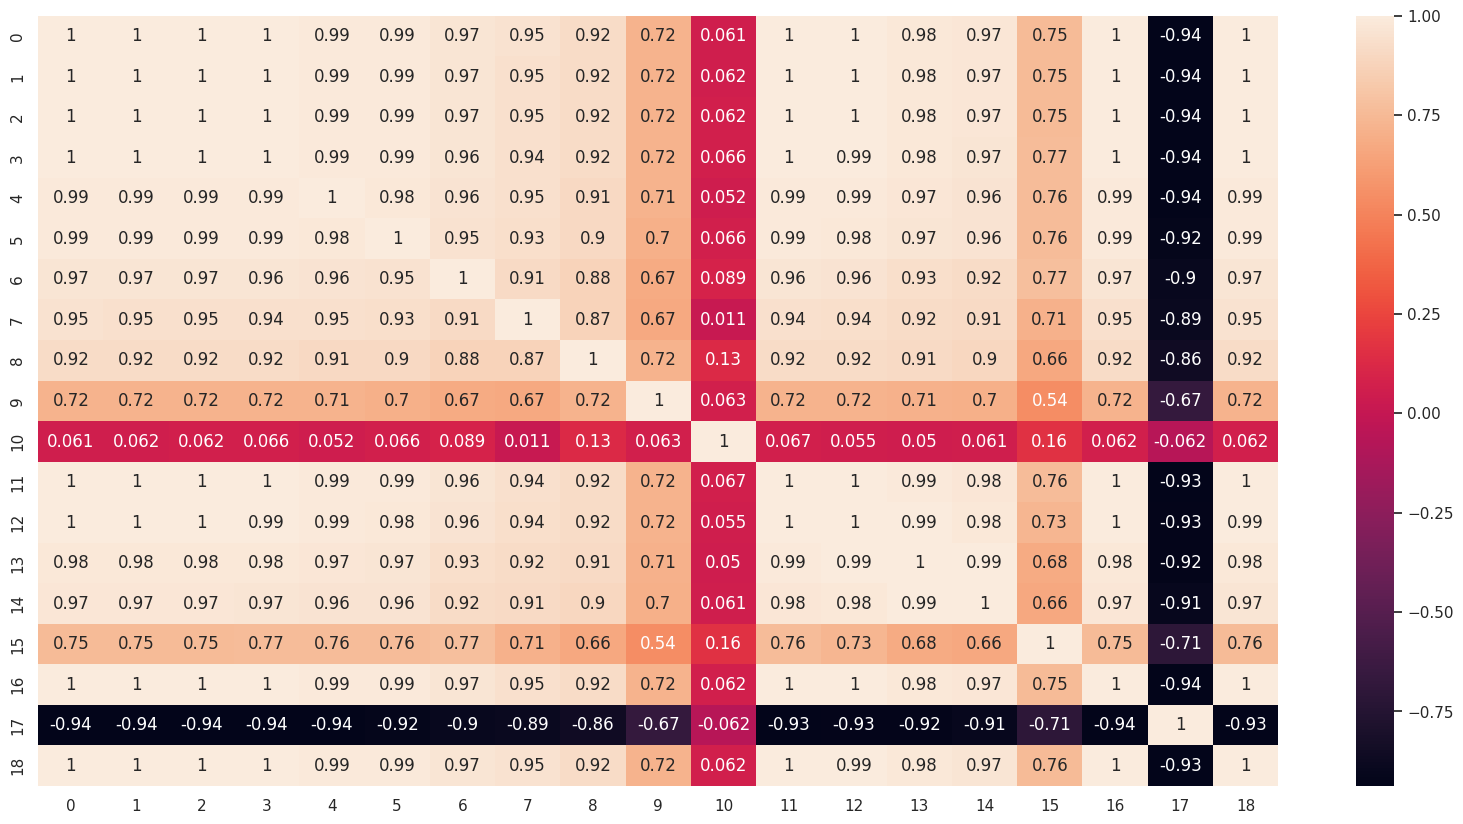

In [41]:
x, y = preprocessing(5, 16)

# Plot a correlation matrix to determine if there are any redundancies
corr = pd.DataFrame(x).corr()

# Plotting a heatmap between continuous variables
plt.figure(figsize=(20,10))
ax = sns.heatmap(corr,
                 xticklabels=corr.columns,
                 yticklabels=corr.columns,
                 annot=True)

## Machine Learning Pipeline

In [42]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.1 MB/s eta 0:00:00


In [43]:
# Import some additional libraries for ML tasks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error, r2_score

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [44]:
# This function prepares the x and y data for training by performing the test-train split,
# and applying StandardScaler to normalize the values. The scaler is saved as a global
# variable so that it can be used to obtain the original data by performing inverse_transform
# (if needed)
def prep_for_training(x, y, scale_config = True):
    '''
    Prepares the features and labels for applying to machine learning models.
    Features are split into testing and training subsets and then scaled using
    StandardScaler.

    Arguments:
    x -- numpy array, contains features
    y -- numpy array, contains labels
    scale_config -- bool, if True, redefines the scaler and fits it to the training data,
                    which is a subset of "x" created by the train_test_split function.

    Returns:
    train -- list, contains the training data consisting of features and corresponding labels
    test -- list, contains the testing data consisting of features and corresponding labels

    Additional:
    scaler is a global variable and can be used in later steps in case the original data
    needs to be extracted, by running scaler.inverse_transform()
    '''
    global scaler

    # Split the data in the ratio 80:20 for training, testing respectively
    train_x, test_x, train_y, test_y = train_test_split(x, y, train_size = 0.8)

    if scale_config:
        # Standardize the training data
        scaler = StandardScaler()
        # Fit the scaler to X_train
        scaler.fit(train_x)

    # Transform the entire data using the computed mean and variance
    train_x = scaler.transform(train_x)
    test_x = scaler.transform(test_x)

    train = [train_x, train_y]
    test = [test_x, test_y]

    return train, test

We use **Principal Components Analysis (PCA)** to reduce the dimensionality of the features, retaining as much variability as possible. We use the minimum number of components necessary to retain 1% of standard deviation.

8 components are sufficient to satisfy the RMSE reconstruction criterion


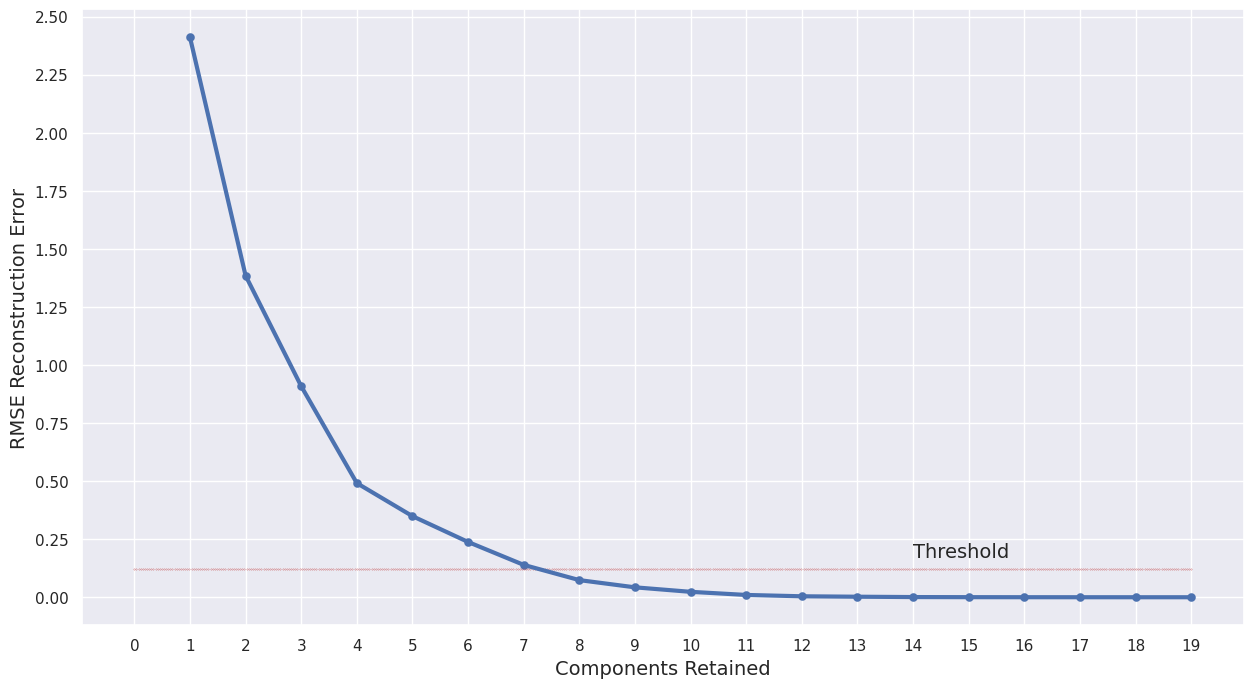

In [45]:
x, y = preprocessing(5, 16)     # using cell 5 for training
[train_x, train_y], [test_x, test_y] = prep_for_training(x, y)

# Import the module for PCA
from sklearn.decomposition import PCA

# Re-centre the data to have zero mean
X_for_pca = train_x - np.mean(train_x, axis=0)[np.newaxis, :]

# Compute std. deviation of L2 norm input vectors
l2_norm = np.sum(X_for_pca ** 2, axis=-1)
std_dev = np.std(l2_norm)

# Threshold for dimensionality reduction set to 1% of std. deviation
threshold = 0.01 * std_dev

rmse_vs_components = []   # List of RMSE vs n_components for plotting
desired_components = 19   # Start by assuming all components are necessary

# Iterate over number of retained dimensions
for n_components in range(1, 20):
    pca = PCA(n_components=n_components)

    # Fit PCA onto the input data
    pca.fit(X_for_pca)

    # Apply dimensionality reduction on X
    X_transformed = pca.transform(X_for_pca)

    # Transform back to the starting space to compute reconstruction error
    X_projected = pca.inverse_transform(X_transformed)

    # Compute RMSE reconstruction error
    rmse = np.sum((X_for_pca - X_projected) ** 2, axis=-1).mean()

    if rmse < threshold:
        desired_components = min(n_components, desired_components)

    rmse_vs_components.append(rmse)

# Plot RMSE vs Components Retained
plt.figure(figsize=(15, 8))
plt.xlabel('Components Retained', fontsize=14)
plt.ylabel('RMSE Reconstruction Error', fontsize=14)
plt.plot(np.arange(1, 20), rmse_vs_components, lw=3)
plt.scatter(np.arange(1, 20), rmse_vs_components, lw=3, s = 10)
plt.scatter(np.linspace(0,19,500),[threshold for i in range(500)], s = 0.05, color = 'r')
plt.text(14, threshold + 0.05, "Threshold", fontsize = 14)

plt.xticks(np.arange(0, 20, 1))
plt.yticks(np.arange(0,2.75,0.25))

print(red(f"{desired_components}", 'bold'), "components are sufficient to satisfy the RMSE reconstruction criterion")

We use the obtained features after PCA to transform both the train and test data.

In [46]:
n_components = desired_components # Sufficient dimensions after compression

# PCA with 8 retained dimensions
pca = PCA(n_components=n_components)
pca.fit(X_for_pca)

train_x = pca.transform(train_x)
test_x = pca.transform(test_x)

# Print the shape for confirmation
print(train_x.shape)
print(test_x.shape)

(134, 8)
(34, 8)


We train the following models:
1. Support Vector Regressor (SVR): <br>
In contrast to normal Linear Regression, where the objective function is
$$ min\sum_{i = 1}^{n} (y_i - w_i x_i) $$
the objective function of SVR is to minimize the the $l_2$ - norm of the coefficient vector — not the squared error.  The error term is instead handled in the constraints, where we set the absolute error less than or equal to a specified margin, which we denote by ɛ. The objective function hence becomes
$$ min\;{\vert\vert w \vert\vert}^2 $$
subject to the constraint
$$ \vert y_i - w_i x_i \vert < ɛ $$
<br>

2. Multilayered Perceptron (MLP): <br>
Multilayered Perceptrons consist of an input and output *layer* with several possible *hidden layers*. A simple MLP with one hidden layer is shown below.<br>
<img align="center" width="400" src="https://drive.google.com/uc?export=view&id=1BUmcGa_pSC048KqdQnbA9Pyy38Mt8I5X">
<br>
After applying the activation function of each hidden layers, the hidden layer's output is calculated by computing the dot product between the previous layer's output and the weights of the current hidden layer. This is continued till the output layer is reached. During training the output will be used for the *backpropogation* algorithm to reduce the calculated loss depending on the selected criterion. During testing the output is used as is. <br>

3. Random Forest Regressor: <br>
Random Forests use Ensemble Learning for regression/classification purposes. Several decision trees are trained and their individual predictions are pooled to obtain much more accurate results compared to a single tree. In regression tasks, the output of the model is a mean of the predictions of all decision trees.
<br>
The following four algorithms belong to a family of *Boosting algorithms*. Boosting is an ensemble modelling technique that attempts to build a robust classifier from the number of weak classifiers. It is done by building a model by using weak models in series. Firstly, a model is built from the training data. Then the second model is built, which tries to correct the errors present in the first model. This procedure continues, and models are added until the complete training data set is predicted correctly or the maximum number of models are added.<br>
<img align="center" src="http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1528107577/output_1_0_ilvuyr.png">
<br>
[Reference to the image](https://medium.com/greyatom/a-quick-guide-to-boosting-in-ml-acf7c1585cb5)
4. XGBoost Regressor: <br>
XGBoost (or eXtreme Gradient Boosting) is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting algorithm.
<br>
5. AdaBoost Regressor: <br>
AdaBoost (or Adaptive Boosting) was the first succesful approach for implementing the Boosting algorithm. The AdaBoost algorithm involves using very short (one-level) decision trees as weak learners that are added sequentially to the ensemble.
<br>
6. LightBGM Regressor: <br>
LightBGM (or Light Boosted Gradient Machine) extends the gradient boosting algorithm by adding a type of automatic feature selection as well as focusing on boosting examples with larger gradients. This results in a dramatic speedup of training and improved predictive performance.
<br>
7. CatBoost Regressor: <br>
CatBoost is an open-source library developed by Yandex. It is a depth-wise gradient boosting library which uses oblivious decision trees to grow a balanced tree.
<br>

In [47]:
# These functions train and evaluate their respective models. Models are saved as
# global variables so they can be used in the later step of evaluating the model.
# Evaluation is carried out on completely different cells which the model has not seen

def eval_svr(train, test, training = True):
    '''
    If training is enabled, a new instance of a Support Vector Regression model is created
    and fit on the training data. The model is then fed with test data and it's performance
    is reported. If training is disabled, the model previously defined is simply evaluated
    using the test data and it's performance is reported.

    Arguments:
    train -- list, should be of the form [train features, train labels]
    test -- list, should be of the form [test features, test labels]
    training -- bool, specifies whether training is enabled or disabled

    Additional:
    The model created is a global variable and can be used in later steps when evaluating
    on different datasets (after setting training to "False").
    '''
    global svr

    if training:
        # Define a SVM regressor with a Gaussian kernel
        svr = SVR()

        # Train the model
        svr.fit(train[0], train[1])

    # Test the model returning mean accuracy
    print(blue(f"Evaluating the Support Vector Regressor...", 'bold'))
    print(f"R2 Score = {svr.score(test[0], test[1]):.4f}")

    mse = mean_squared_error(svr.predict(test[0]), test[1])
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

def eval_mlp(train, test, training = True, layer_size = 100, max_iter = 100):
    '''
    If training is enabled, a new instance of a Multi Layered Perceptron model is created
    and fit on the training data. The model is then fed with test data and it's performance
    is reported. If training is disabled, the model previously defined is simply evaluated
    using the test data and it's performance is reported.

    Arguments:
    train -- list, should be of the form [train features, train labels]
    test -- list, should be of the form [test features, test labels]
    training -- bool, specifies whether training is enabled or disabled

    Additional:
    The model created is a global variable and can be used in later steps when evaluating
    on different datasets (after setting training to "False").
    '''
    global mlp

    if training:
        # Define a regressor with 1 hidden layer
        mlp = MLPRegressor(hidden_layer_sizes = (layer_size,), max_iter = max_iter)
        # Train the model
        mlp.fit(train[0], train[1])

    # Test the model returning mean accuracy
    print(blue(f"Evaluating the Multi-Layer Perceptron...", 'bold'))
    print(f"R2 Score = {mlp.score(test[0], test[1]):.4f}")

    mse = mean_squared_error(mlp.predict(test[0]), test[1])
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

def eval_rf(train, test, training = True, n_estimators = 100):
    '''
    If training is enabled, a new instance of a Random Forest Regression model is created
    and fit on the training data. The model is then fed with test data and it's performance
    is reported. If training is disabled, the model previously defined is simply evaluated
    using the test data and it's performance is reported.

    Arguments:
    train -- list, should be of the form [train features, train labels]
    test -- list, should be of the form [test features, test labels]
    training -- bool, specifies whether training is enabled or disabled

    Additional:
    The model created is a global variable and can be used in later steps when evaluating
    on different datasets (after setting training to "False").
    '''
    global regressor

    if training:
        # Define a random forest regressor
        regressor = RandomForestRegressor(n_estimators = n_estimators)
        # Train the model
        regressor.fit(train[0], train[1])

    # Test the model returning mean accuracy
    print(blue(f"Evaluating the Random Forest Regressor...", 'bold'))
    print(f"R2 Score = {regressor.score(test[0], test[1]):.4f}")

    mse = mean_squared_error(regressor.predict(test[0]), test[1])
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

def eval_xgb(train, test, training = True):
    '''
    If training is enabled, a new instance of an XGBoost Regression model is created
    and fit on the training data. The model is then fed with test data and it's performance
    is reported. If training is disabled, the model previously defined is simply evaluated
    using the test data and it's performance is reported.

    Arguments:
    train -- list, should be of the form [train features, train labels]
    test -- list, should be of the form [test features, test labels]
    training -- bool, specifies whether training is enabled or disabled

    Additional:
    The model created is a global variable and can be used in later steps when evaluating
    on different datasets (after setting training to "False").
    '''
    global xgbr

    if training:
        # Define a xgb regressor
        xgbr = XGBRegressor()
        # Train the model
        xgbr.fit(train[0], train[1])

    # Test the model returning mean accuracy
    y_pred = xgbr.predict(test[0])
    print(blue(f"Evaluating the XGBoost Regressor...", 'bold'))
    print(f"R2 Score = {r2_score(test[1], y_pred):.4f}")

    mse = mean_squared_error(test[1], y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

def eval_abr(train, test, training = True):
    '''
    If training is enabled, a new instance of an AdaBoost Regression model is created
    and fit on the training data. The model is then fed with test data and it's performance
    is reported. If training is disabled, the model previously defined is simply evaluated
    using the test data and it's performance is reported.

    Arguments:
    train -- list, should be of the form [train features, train labels]
    test -- list, should be of the form [test features, test labels]
    training -- bool, specifies whether training is enabled or disabled

    Additional:
    The model created is a global variable and can be used in later steps when evaluating
    on different datasets (after setting training to "False").
    '''
    global abr

    if training:
        # Define a adaboost regressor
        abr = AdaBoostRegressor()
        # Train the model
        abr.fit(train[0], train[1])

    # Test the model returning mean accuracy
    y_pred = abr.predict(test[0])
    print(blue(f"Evaluating the AdaBoost Regressor...", 'bold'))
    print(f"R2 Score = {r2_score(test[1], y_pred):.4f}")

    mse = mean_squared_error(test[1], y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

def eval_lgbmr(train, test, training = True):
    '''
    If training is enabled, a new instance of a Light GBM Regression model is created
    and fit on the training data. The model is then fed with test data and it's performance
    is reported. If training is disabled, the model previously defined is simply evaluated
    using the test data and it's performance is reported.

    Arguments:
    train -- list, should be of the form [train features, train labels]
    test -- list, should be of the form [test features, test labels]
    training -- bool, specifies whether training is enabled or disabled

    Additional:
    The model created is a global variable and can be used in later steps when evaluating
    on different datasets (after setting training to "False").
    '''
    global lgbmr

    if training:
        # Define a LightBGM regressor
        lgbmr = LGBMRegressor()
        # Train the model
        lgbmr.fit(train[0], train[1])

    # Test the model returning mean accuracy
    y_pred = lgbmr.predict(test[0])
    print(blue(f"Evaluating the LightGBM Regressor...", 'bold'))
    print(f"R2 Score = {r2_score(test[1], y_pred):.4f}")

    mse = mean_squared_error(test[1], y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

def eval_cbr(train, test, training = True):
    '''
    If training is enabled, a new instance of a Cat Boost Regression model is created
    and fit on the training data. The model is then fed with test data and it's performance
    is reported. If training is disabled, the model previously defined is simply evaluated
    using the test data and it's performance is reported.

    Arguments:
    train -- list, should be of the form [train features, train labels]
    test -- list, should be of the form [test features, test labels]
    training -- bool, specifies whether training is enabled or disabled

    Additional:
    The model created is a global variable and can be used in later steps when evaluating
    on different datasets (after setting training to "False").
    '''
    global cbr

    if training:
        # Define a LightBGM regressor
        cbr = CatBoostRegressor()
        # Train the model
        cbr.fit(train[0], train[1])

    # Test the model returning mean accuracy
    y_pred = cbr.predict(test[0])
    print(blue(f"Evaluating the CatBoost Regressor...", 'bold'))
    print(f"R2 Score = {r2_score(test[1], y_pred):.4f}")

    mse = mean_squared_error(test[1], y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

In [48]:
train, test = [train_x, train_y], [test_x, test_y]

eval_svr(train, test, training = True)
eval_rf(train, test, training = True)
eval_xgb(train, test, training = True)
eval_abr(train, test, training = True)
eval_lgbmr(train, test, training = True)
eval_cbr(train, test, training = True)

Evaluating the Support Vector Regressor...
R2 Score = 0.9140
RMSE = 0.0532
Evaluating the Random Forest Regressor...
R2 Score = 0.9933
RMSE = 0.0149
Evaluating the XGBoost Regressor...
R2 Score = 0.9947
RMSE = 0.0132
Evaluating the AdaBoost Regressor...
R2 Score = 0.9946
RMSE = 0.0133
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 372
[LightGBM] [Info] Number of data points in the train set: 134, number of used features: 8
[LightGBM] [Info] Start training from score 1.571049
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

### Hyperparameter Tuning

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#XGBoost hyper-parameter tuning
def hyperParameterTuning(X_train, y_train):

    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'n_estimators' : [100, 200, 500]
    }

    print(blue('Performing hyperparameter tuning for the XGBoost Regressor', 'bold'))
    xgb_model = XGBRegressor()
    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,
                           cv = 5, verbose = 1, n_jobs = -1, error_score = 0.00)

    gsearch.fit(X_train,y_train)
    print(gsearch.best_params_)

    param_tuning = {
        'n_estimators':[10, 50, 100, 500, 1000],
        'learning_rate':[0.0001, 0.001, 0.01, 0.1, 1]
    }

    print(blue('Performing hyperparameter tuning for the AdaBoost Regressor', 'bold'))
    abr_model = AdaBoostRegressor()
    gsearch = GridSearchCV(estimator = abr_model,
                           param_grid = param_tuning,
                           cv = 5, n_jobs = -1, verbose = 1, error_score = 0.00)

    gsearch.fit(X_train,y_train)
    print(gsearch.best_params_)

    param_tuning = {
        'max_depth': (9, 13),
        'min_split_gain': (0.001, 0.1),
        'min_child_weight': (10, 30, 50)
    }

    print(blue('Performing hyperparameter tuning for the LightGBM Regressor', 'bold'))
    lgbmr_model = LGBMRegressor()
    gsearch = GridSearchCV(estimator = lgbmr_model,
                           param_grid = param_tuning,
                           cv = 5, verbose = 1, n_jobs = -1, error_score = 0.00)

    gsearch.fit(X_train,y_train)
    print(gsearch.best_params_)

    param_tuning = {
        'iterations': [50, 100, 150, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'depth': [2, 4, 6, 8]
    }

    print(blue('Performing hyperparameter tuning for the CatBoost Regressor', 'bold'))
    cbr_model = CatBoostRegressor()
    gsearch = GridSearchCV(estimator = cbr_model,
                           param_grid = param_tuning,
                           cv = 5, verbose = 1, n_jobs = -1, error_score = 0.00)

    gsearch.fit(X_train,y_train)
    print(gsearch.best_params_)

In [50]:
hyperParameterTuning(train[0], train[1])

Performing hyperparameter tuning for the XGBoost Regressor
Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}
Performing hyperparameter tuning for the AdaBoost Regressor
Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'learning_rate': 1, 'n_estimators': 500}
Performing hyperparameter tuning for the LightGBM Regressor
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 372
[LightGBM] [Info] Number of data points in the train set: 134, number of used features: 8
[LightGBM] [Info] Start training from score 1.571049
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

In [55]:
!pip install keras pydot graphviz

In [56]:
# Using an Artificial Neural Network with LSTM and Dense layers
# Importing required libraries
from keras.models import Model
from keras.layers import Input, Dense, LSTM
from tensorflow.keras.utils import plot_model
from tqdm.keras import TqdmCallback
from keras.callbacks import EarlyStopping
import tqdm.notebook as tq

def create_model(lstm_size = 32, dense_size = 10, plot = False, dpi = 96):
    '''
    Returns an Artificial Neural Network model made for regression tasks

    Arguments:
    lstm_size -- integer, specifies number of neurons in the hidden LSTM layer
    dense_size -- integer, specifies number of neurons in the hidden Dense layer
    plot -- bool, specifies whether the model visualization plot should be
            displayed
    dpi -- integer, if plot = True, specifies the dots-per-inch for the model
           plot image

    Returns:
    model -- a compiled ANN built for regression tasks.
    '''
    inputs = Input(shape = (8,1), name = 'Input_features')
    lstm = LSTM(lstm_size, input_shape = (8,1))(inputs)
    dense2 = Dense(dense_size)(lstm)
    output = Dense(1, name = 'Output_Layer')(dense2)

    model = Model(inputs = inputs, outputs = output)
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    if plot:
        print("Visualizing the model and its layers :")
        display(plot_model(model, show_shapes = True, dpi = dpi))

    return model

def eval_nn(train, test,
            training = True,
            lstm_size = 32,
            dense_size = 10,
            plot = False, dpi = 96,
            epochs = 100,
            ncols = None,
            verbose = 1,
            return_results = True):
    '''
    If training is enabled, a new instance of an Artificial Neural Network model is created
    and fit on the training data. The model is then fed with test data and it's performance
    is reported. If training is disabled, the model previously defined is simply evaluated
    using the test data and it's performance is reported.

    Arguments:
    train -- list, should be of the form [train features, train labels]
    test -- list, should be of the form [test features, test labels]
    training -- bool, specifies whether training is enabled or disabled
    lstm_size -- integer, specifies number of neurons in the hidden LSTM layer
    dense_size -- integer, specifies number of neurons in the hidden Dense layer
    plot -- bool, specifies whether the model visualization plot should be displayed
    dpi -- integer, if plot = True, specifies the dots-per-inch for the model
           plot image (larger number, larger image)
    epochs -- integer, specifies number of epochs the model should train for
    ncols -- integer, specifies number of columns for the training progress bar
    verbose -- integer, when verbosity is set to 1:
               model training progress bar is shown
               model evaluation progress bar is shown
               R2 Score and RMSE Loss are printed
               When verbosity is NOT 1, all outputs are silenced
    return_results -- bool, when True, returns the value of RMSE. (For use in
                      hyperprameter tuning)

    Additional:
    The model created is a global variable and can be used in later steps when evaluating
    on different datasets (after setting training to "False").
    '''
    global nn

    if training: train_x = train[0].reshape(-1,8,1)
    test_x = test[0].reshape(-1,8,1)

    if training:
        es_callback = EarlyStopping(monitor = 'loss', patience = 20)
        if verbose == 1:
            tqdm_callback = TqdmCallback(verbose = 0, ncols = ncols)
            callbacks = [tqdm_callback, es_callback]
        else: callbacks = [es_callback]
        # Define the model
        nn = create_model(lstm_size = lstm_size, dense_size = dense_size, plot = plot, dpi = dpi)
        # Train the model
        nn.fit(train_x, train[1],
               epochs = epochs,
               batch_size = 1,
               verbose = 0,
               callbacks = callbacks)

    # Test the model returning mean accuracy
    y_pred = nn.predict(test[0])
    rmse = np.sqrt(nn.evaluate(test_x, test[1], verbose = verbose))
    r2 = r2_score(test[1], y_pred)
    if verbose == 1:
        print(blue(f"Evaluating the Artificial Neural Network...", 'bold'))
        print(f"R2 Score = {r2:.4f}")
        print(f"RMSE = {rmse:.4f}")
    if return_results: return rmse

In [57]:
# Defining a model with 25 neurons in the LSTM layer and 10 neurons in the Dense layer
eval_nn(train, test,
        training = True,
        lstm_size = 32,
        dense_size = 10,
        plot = False,
        epochs = 100,
        verbose = 1,
        return_results = False)

0epoch [00:00, ?epoch/s]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011 
Evaluating the Artificial Neural Network...
R2 Score = 0.9686
RMSE = 0.0322


In [58]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [59]:
# Hyperparameter tuning for the Artificial Neural Network

lstm_sizes = [8, 10, 16, 25, 32]
dense_sizes = [4, 8, 10]

comb_nn = [(lstm_sizes[i], dense_sizes[j]) for i in range(len(lstm_sizes)) for j in range(len(dense_sizes))]

min = 0.1
for i in tq.trange(len(comb_nn)):
    lstm_size = comb_nn[i][0]
    dense_size = comb_nn[i][1]
    results = eval_nn(train, test,
                      training = True,
                      lstm_size = lstm_size,
                      dense_size = dense_size,
                      plot = False,
                      verbose = 0,
                      epochs = 100,
                      return_results = True)
    if results < min:
        print(f"Updating minimum loss..... \t Iteration loss = {results:.4f} \t Previous Minimum loss = {min:.4f}")
        print(f"Best Params = {comb_nn[i]}")
        lstm_best = comb_nn[i][0]
        dense_best = comb_nn[i][1]
        min = results
print(f"Best results obtained with LSTM layer size = {lstm_best} \t Dense layer size = {dense_best}")

  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 710ms/step
Updating minimum loss..... 	 Iteration loss = 0.0130 	 Previous Minimum loss = 0.1000
Best Params = (8, 4)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Updating minimum loss..... 	 Iteration loss = 0.0108 	 Previous Minimum loss = 0.0130
Best Params = (8, 8)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step
Updating minimum loss..... 	 Iteration loss = 0.0103 	 Previous Minimum loss = 0.0108
Best Params = (32, 8)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
Best results obtained with LSTM layer size = 32 	 Dense layer size = 8


0epoch [00:00, ?epoch/s]

Visualizing the model and its layers :


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


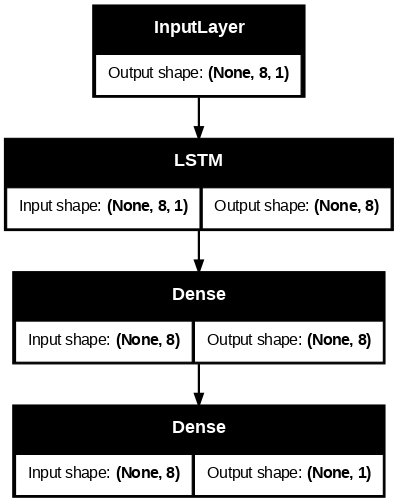

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.5866e-04  
Evaluating the Artificial Neural Network...
R2 Score = 0.9891
RMSE = 0.0190


In [60]:
eval_nn(train, test,
        training = True,
        lstm_size = 8,
        dense_size = 8,
        plot = True, dpi = 80,
        epochs = 100,
        verbose = 1,
        return_results = False)

### Model Evaluation
We have trained the models on battery #5 but test its generalisation capabilities by evaluating its prediction on data from other batteries.

In [62]:
# This function applies the previously trained models to the data of other cells
# which have not been used for the training process

def evaluate_cell(cell_number, model_type, axes, position):
    '''
    Evaluates the models of specified type on the data corresponding
    to the specified cell number. Data is first extracted and processed and then
    fed to the model of specified type for evaluation. The results are printed
    and a plot of predicted vs true labels is also created.

    Arguments:
    cell_number -- integer, should be one of 5, 6, 7, 18
    model_type -- should be one of "lgbmr", "rf", "nn" or "all"
    axes -- matplotlib axes objects, plots will be arranged on these pre-defined axes
    position -- tuple, the plot will be arranged in the position specified by this argument.

    If model_type = "all" then all models, i.e. lgbmr, rf and nn
    are evaluated using the data from the specified cell number and a
    single plot containing predicted labels vs true labels is created.
    Models are evaluated using the corresponding evaluate functions
    after setting training to False.
    '''
    x, y = preprocessing(cell_number, 16)
    x = scaler.transform(x)
    x = pca.transform(x)

    if model_type == 'xgb' or model_type == 'all':
        eval_xgb(_, [x, y], training = False)
        axes[position[0], position[1]].plot(xgbr.predict(x), label = "XGBoost Regressor")

    if model_type == 'rf' or model_type == 'all':
        eval_rf(_, [x, y], training = False)
        axes[position[0], position[1]].plot(regressor.predict(x), label = "Random Forest Regressor")

    if model_type == 'nn' or model_type == 'all':
        eval_nn(_, [x, y], training = False, plot = False)
        axes[position[0], position[1]].plot(nn.predict(x.reshape(-1,8,1)), label = "Artificial Neural Network")

    axes[position[0], position[1]].plot(y.reshape(-1,1), label = "True labels")
    axes[position[0], position[1]].legend()
    axes[position[0], position[1]].set_xlabel("Cycles", fontsize = 14)
    axes[position[0], position[1]].set_ylabel("Capacity of the battery (Ahr)", fontsize = 14)

Applying the previously trained models to data from cell 7
Evaluating the XGBoost Regressor...
R2 Score = 0.9734
RMSE = 0.0262
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 
Evaluating the Artificial Neural Network...
R2 Score = 0.9575
RMSE = 0.0331


ValueError: as_list() is not defined on an unknown TensorShape.

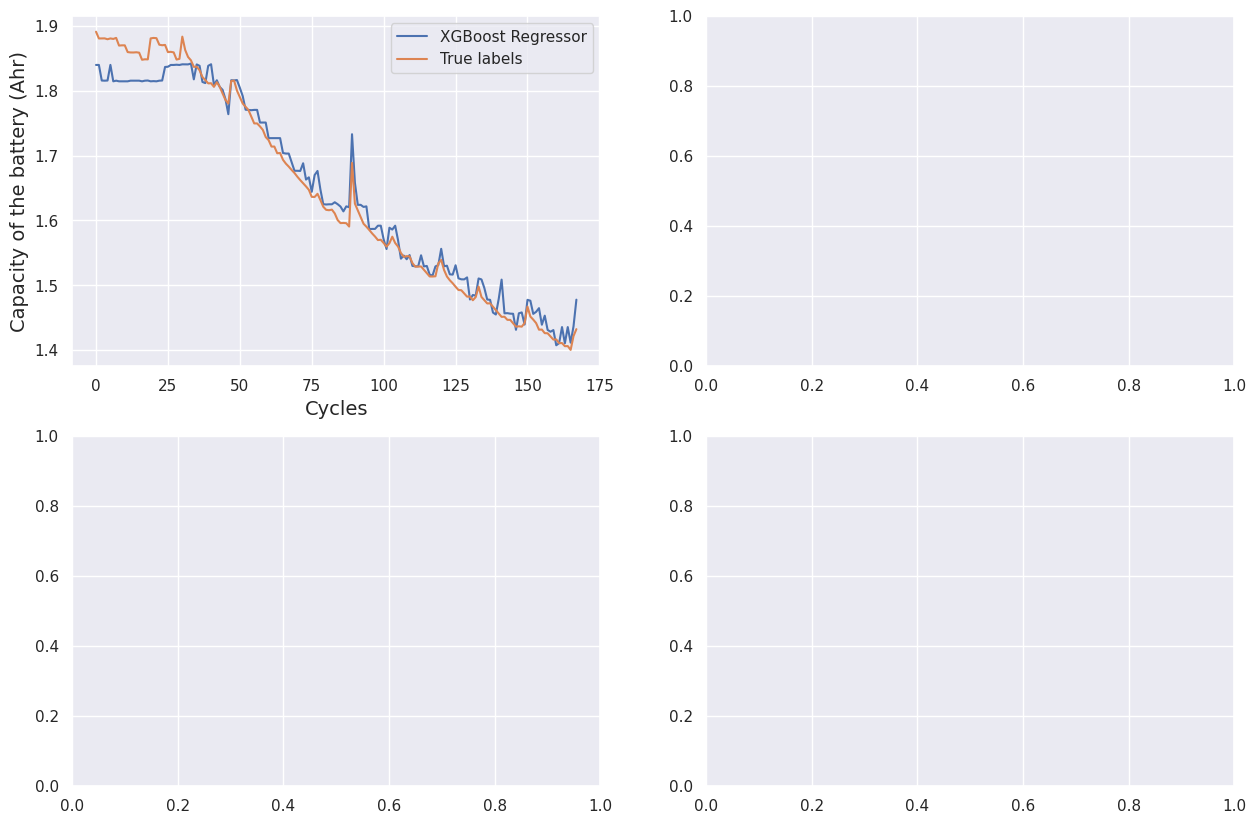

In [63]:
print(red("Applying the previously trained models to data from cell 7", 'bold'))
fig, axes = plt.subplots(2, 2, figsize = (15, 10))

evaluate_cell(7, 'xgb', axes, (0,0))
evaluate_cell(7, 'nn', axes, (0,1))
evaluate_cell(7, 'rf', axes, (1,0))

print(red("Comparing all models at once", 'bold'))
evaluate_cell(7, 'all', axes, (1,1))

In [64]:
# Evaluating all the models on cell number 7

x, y = preprocessing(7, 16)
x = scaler.transform(x)
x = pca.transform(x)


eval_svr(_, [x,y], training = False)
eval_rf(_, [x,y], training = False)
eval_xgb(_, [x,y], training = False)
eval_abr(_, [x,y], training = False)
eval_lgbmr(_, [x,y], training = False)
eval_cbr(_, [x,y], training = False)
eval_nn(_, [x,y], training = False, plot = False)

Evaluating the Support Vector Regressor...
R2 Score = 0.8212
RMSE = 0.0679
Evaluating the Random Forest Regressor...
R2 Score = 0.9833
RMSE = 0.0207
Evaluating the XGBoost Regressor...
R2 Score = 0.9734
RMSE = 0.0262
Evaluating the AdaBoost Regressor...
R2 Score = 0.9701
RMSE = 0.0278
Evaluating the LightGBM Regressor...
R2 Score = 0.9736
RMSE = 0.0261
Evaluating the CatBoost Regressor...
R2 Score = 0.9463
RMSE = 0.0372
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 
Evaluating the Artificial Neural Network...
R2 Score = 0.9575
RMSE = 0.0331


0.033088843283909056

### Model Explainability

We want to understand why our model is predicting what it predicts. For this purpose, we try to understand the importance of each feature in predicting capacity. We start by making Partial Dependence Plots (PDPs) for each feature which assumes that the other features are held constant. Although these assume that the features are independent (we are plotting the variation of output with a single input feature), we can still extract valuable insights.

In [65]:
from sklearn.inspection import PartialDependenceDisplay

def partial_dependence_plot(model, feature, ax, data = train[0], line_kw = {}):
    '''
    Plots a partial dependance plot for the specified feature using the specified model.

    Arguments:
    model -- regression model, should be one of the models defined in the above cells
    feature -- list, contains the features for which the partial dependence plot will
                be made
    ax -- matplotlib axis object, axis or position where the plot will be made
    data -- numpy array, this data will be used to actually prepare the PDP
    line_kw -- dict, kwargs for the plot, such as color, linewidth, label, etc.
    '''

    disp = PartialDependenceDisplay.from_estimator(model,
                                                  data,
                                                  feature,
                                                  kind="average",
                                                  n_jobs=3,
                                                  grid_resolution=20,
                                                  ax=ax,
                                                  line_kw=line_kw)
    disp.axes_[0][0].set_xlabel(f"Feature {feature}", fontsize=14)
    disp.axes_[0][0].set_ylabel("Partial Dependence", fontsize=14)
    return disp

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


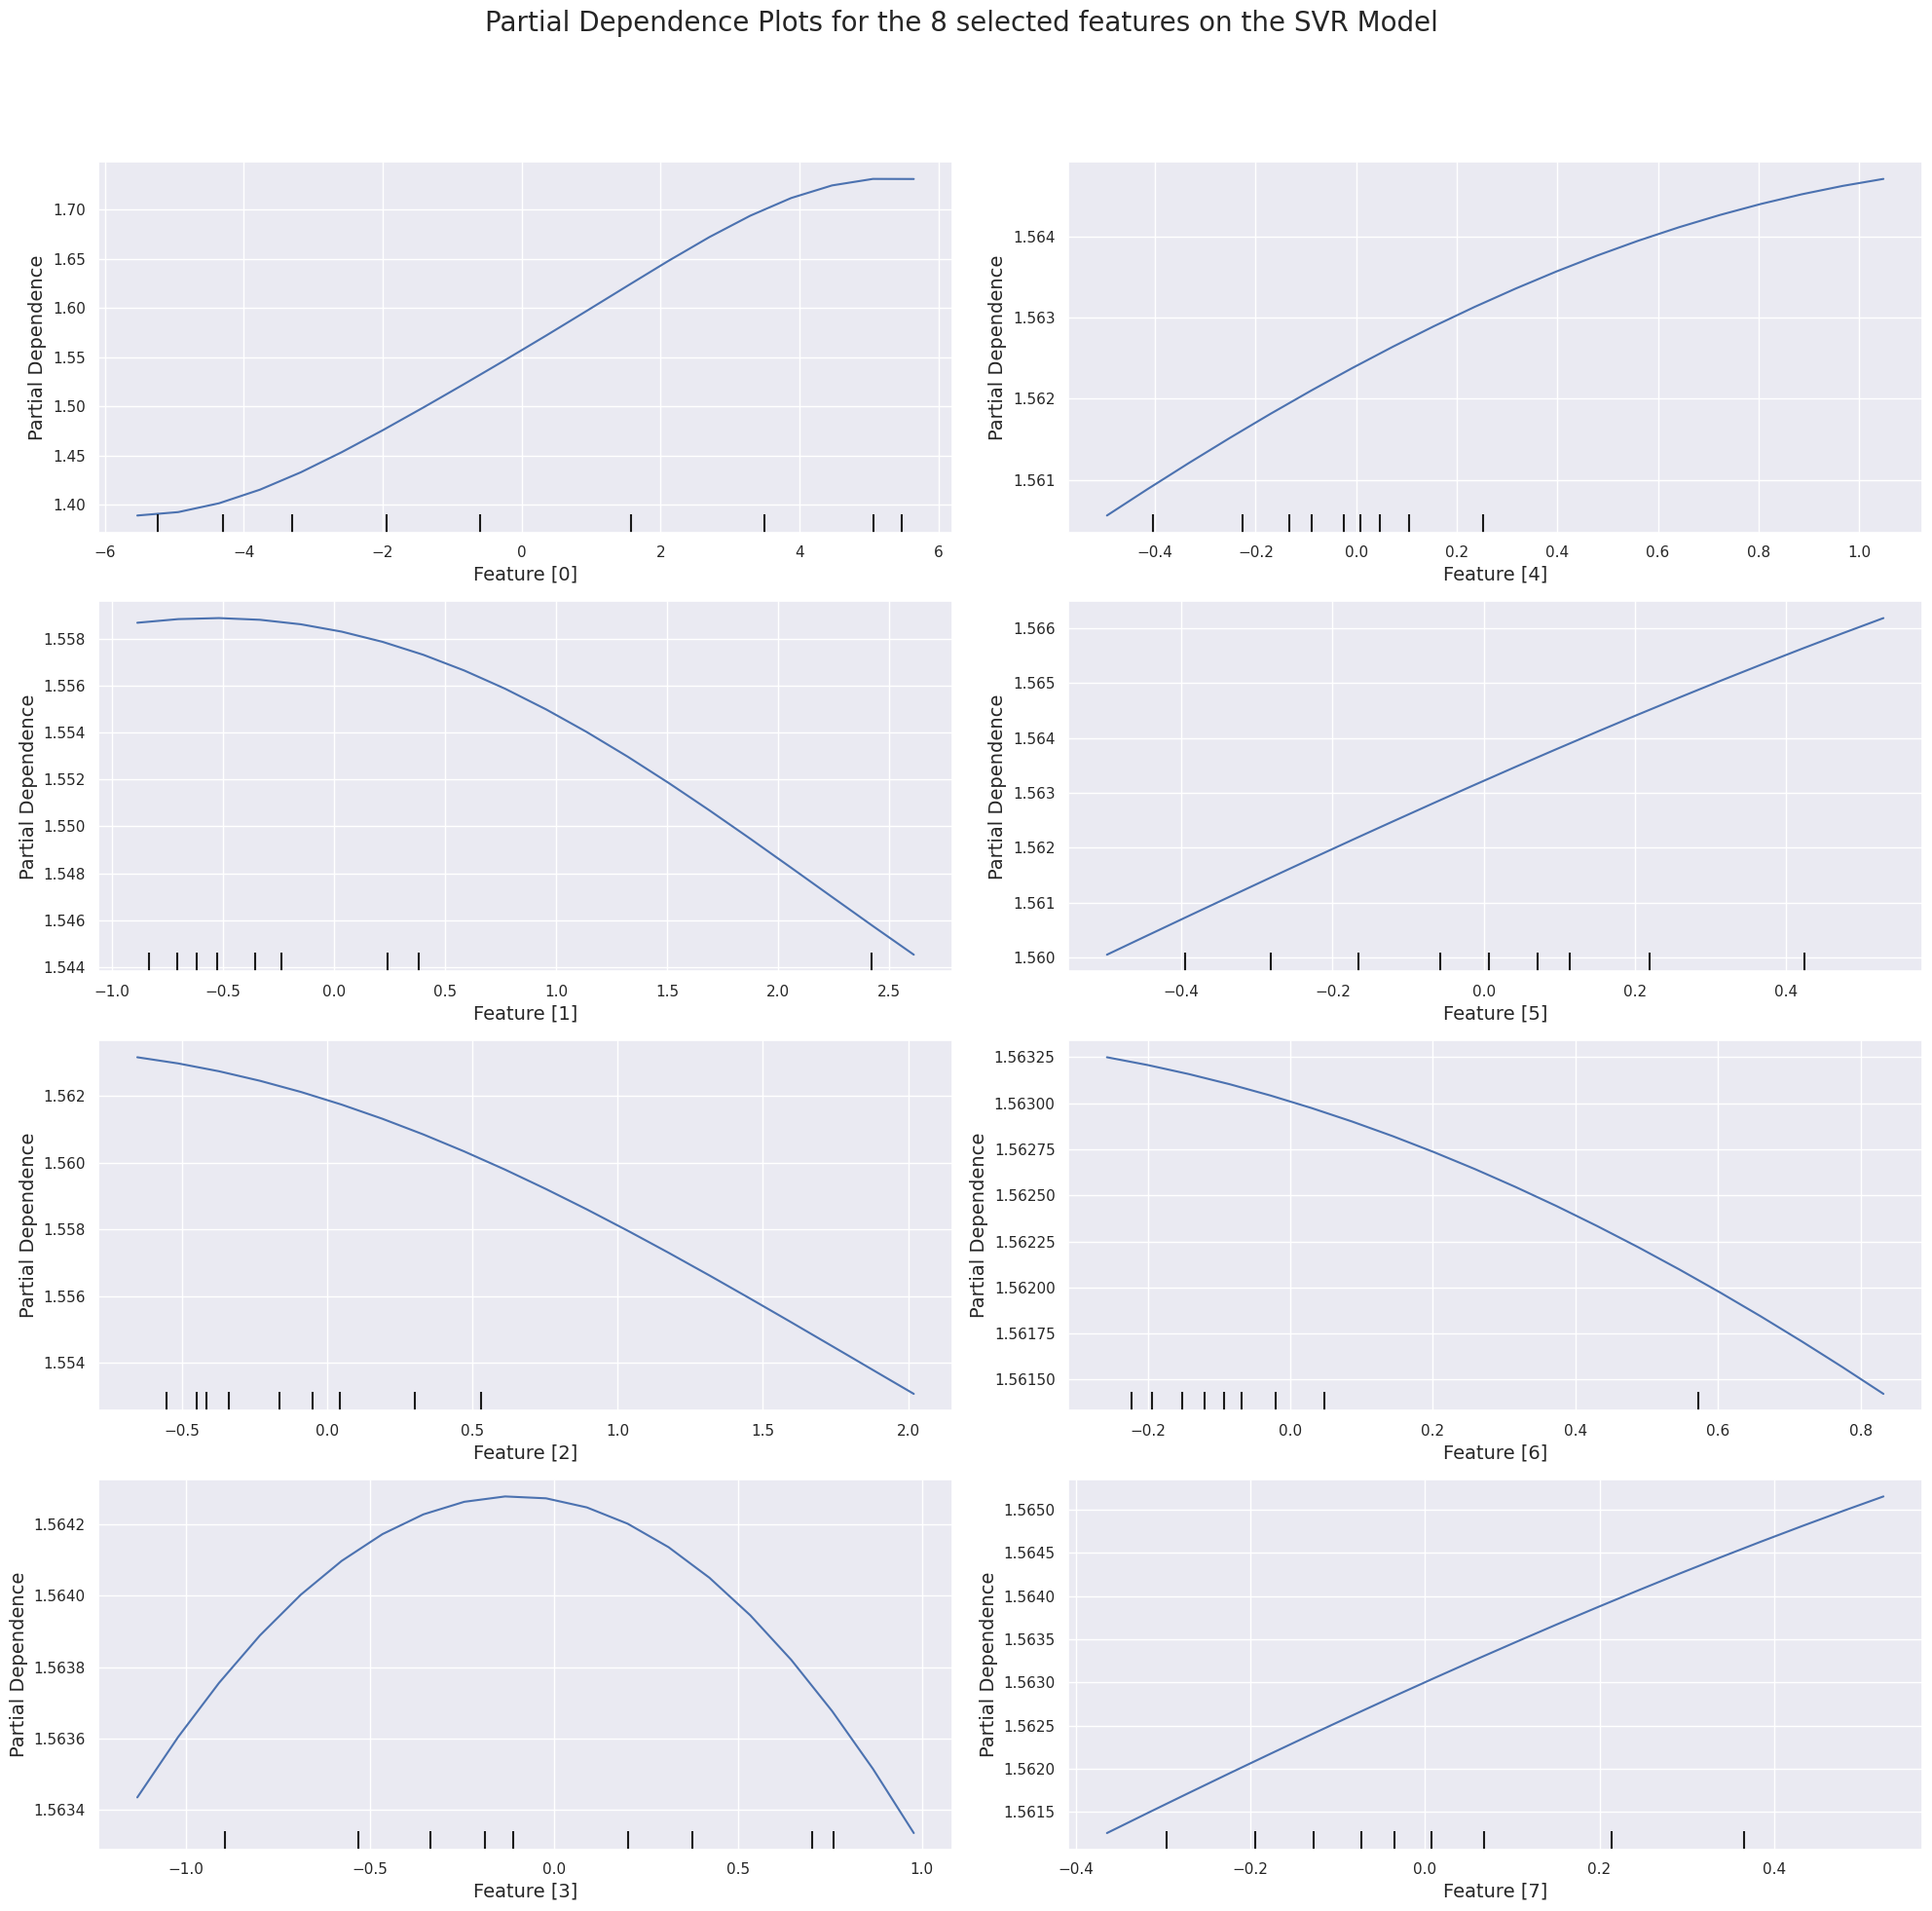

In [66]:
features = {0: [[i] for i in range(4)],
            1: [[i] for i in range(4,8)]}

fig, axes = plt.subplots(4, 2, figsize = (20,20))
fig.suptitle("Partial Dependence Plots for the 8 selected features on the SVR Model \n", fontsize=20)

for (i, j) in zip(features[0], np.arange(4)):
    partial_dependence_plot(svr, i, axes[j,0])
for (i, j) in zip(features[1], np.arange(4)):
    partial_dependence_plot(svr, i, axes[j,1])

fig.tight_layout(rect=[0, 0, 1, 0.95]) # For removing extra whitespace introduced on using fig.suptitle

Since we carried out PCA, model explainability is bit a complicated. However, we can use our insights from EDA to come up with possible physical interpretations for the plots. Retaining the intuition from the original features,

1. Features 0, 4, 7 have monotonically increasing PDPs and can be associated to the times at which battery voltage attains some specified values.
2. Feature 1, 2, 3, 6, 5 have decreasing PDPs and can be associated to the maximum temperature attained by the battery in each discharge cycle.

To validate our hypothesis, we can make a scatterplot of the original features with capacity. For the sake of brevity, we make a scatterplot of capacity vs time at which battery voltage hits 2.8V and another scatterplot of capacity vs maximum temperature achieved in the discharge cycle.

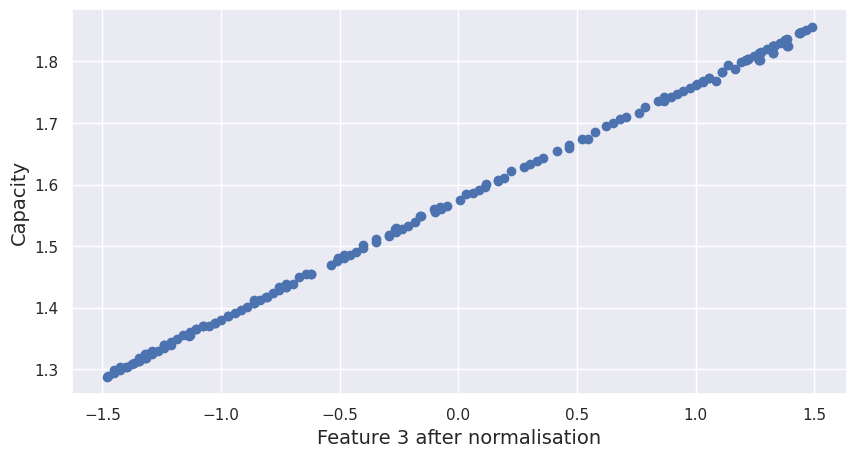

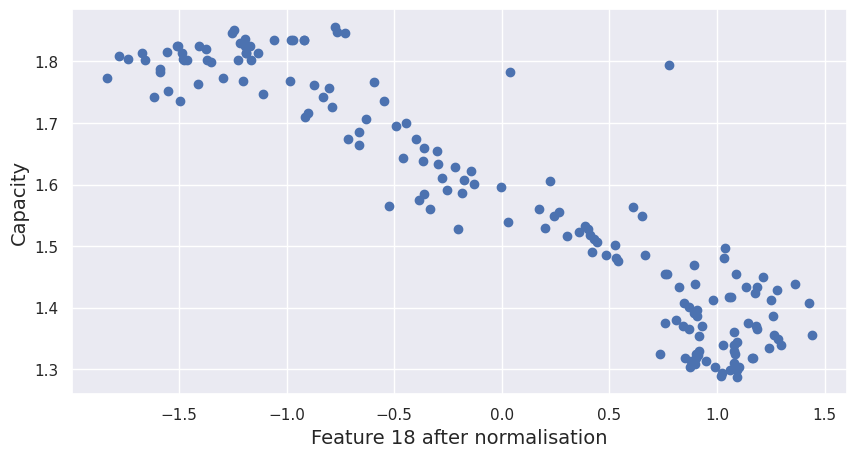

In [67]:
# Features [0], [4], [7] represent different points in the discharge voltage
# plot (hence the increasing nature since if these relate to times,
# a smaller time corresponds to a smaller capacity)

# Testing our hypothesis by making a scatterplot
# Matrix x below refers to the matrix of features after feature extraction
# Standardizing x
x, y = preprocessing(5, 16)
x_std = (x - np.mean(x, axis=0)) / np.std(x, axis=0)

# Making a scatterplot of capacity vs time at which voltage hits 4 V
# [:, 15] correponds to the 16th column in the dataset i.e. 4V time
plt.figure(figsize=(10, 5))
plt.scatter(x_std[:, 2], y)
plt.xlabel('Feature 3 after normalisation', fontsize=14)
plt.ylabel('Capacity', fontsize=14)
plt.show()

# Making a scatterplot of capacity vs maximum temperature reached
plt.figure(figsize=(10, 5))
plt.scatter(x_std[:, 17], y)
plt.xlabel('Feature 18 after normalisation', fontsize=14)
plt.ylabel('Capacity', fontsize=14)
plt.show()

There is fairly good agreement between the scatterplots we see above and the PDPs.

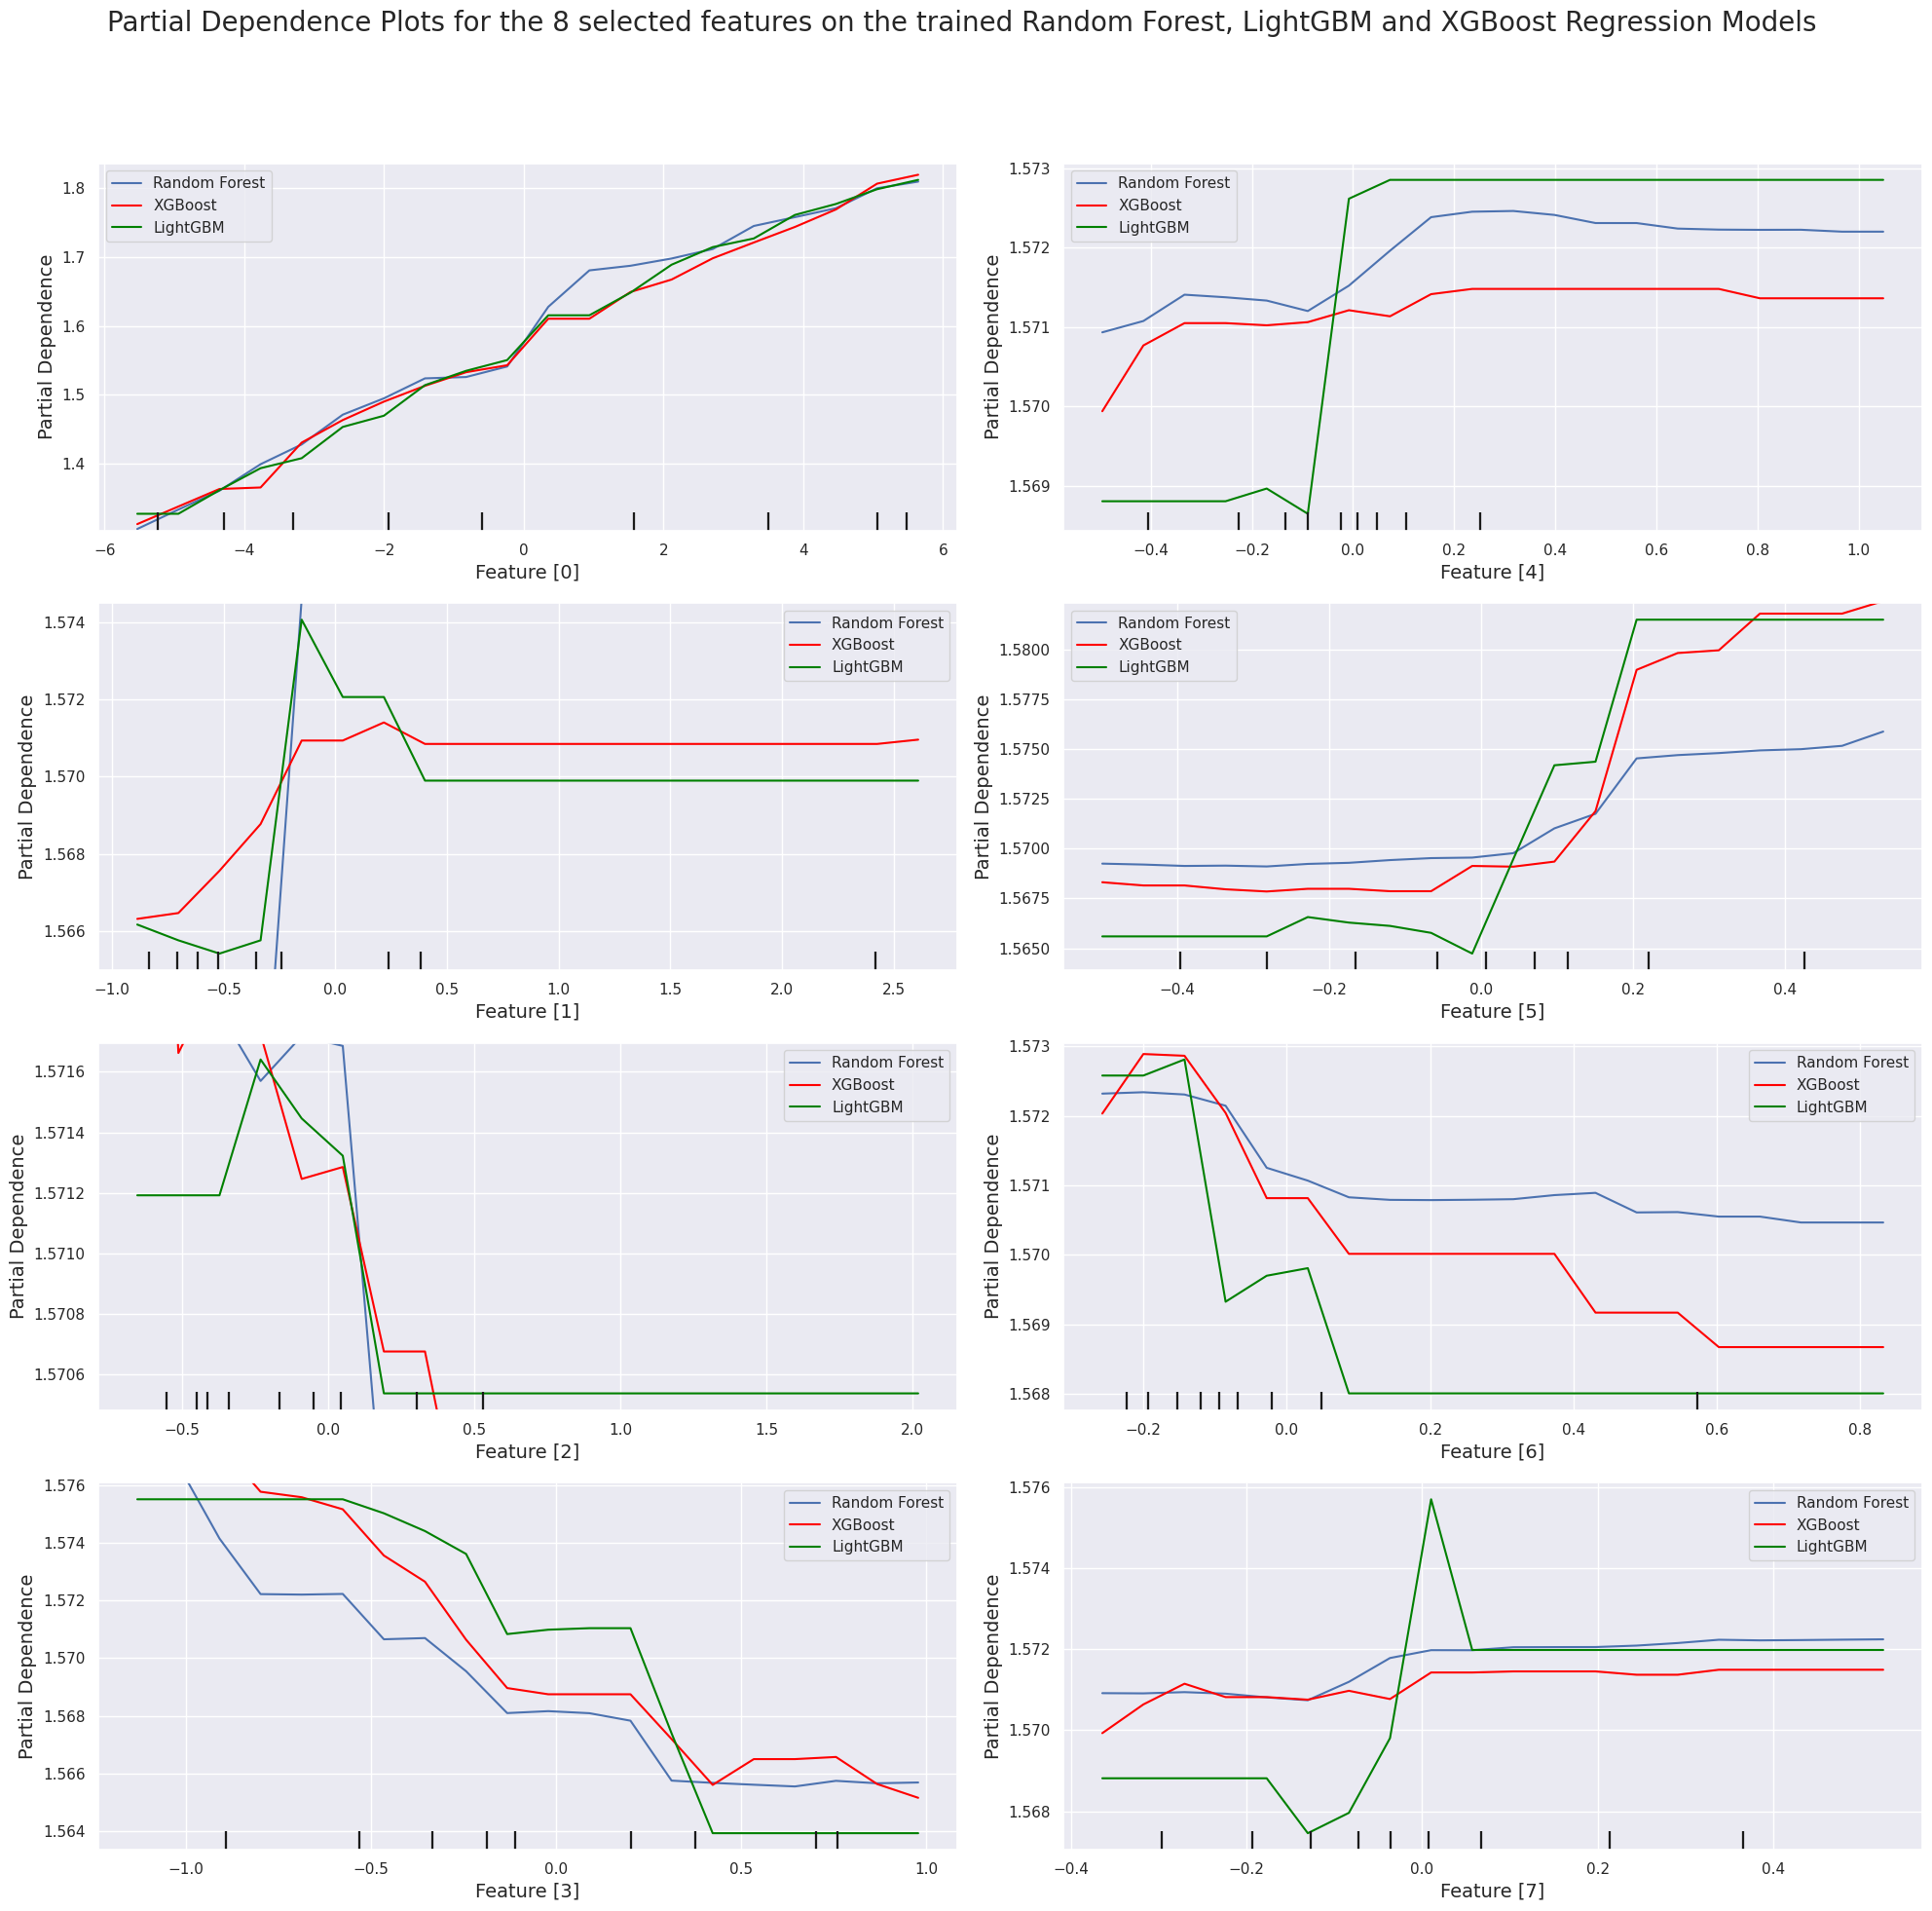

In [68]:
features = {0: [[i] for i in range(4)],
            1: [[i] for i in range(4,8)]}

fig, axes = plt.subplots(4, 2, figsize = (20,20))
fig.suptitle("Partial Dependence Plots for the 8 selected features on the trained Random Forest, LightGBM and XGBoost Regression Models \n", fontsize=20)

base_displays = dict() # For storing all PartialDependanceDisplay instances
for (i, j) in zip(features[0], np.arange(4)):
    base_disp = partial_dependence_plot(regressor, i, ax = axes[j,0], line_kw = {"label": "Random Forest"})
    disp1 = partial_dependence_plot(xgbr, i, ax = base_disp.axes_, line_kw = {"color": "red", "label": "XGBoost"})
    disp2 = partial_dependence_plot(lgbmr, i, ax = base_disp.axes_, line_kw = {"color": "green", "label": "LightGBM"})
    base_disp.axes_[0][0].legend()

for (i, j) in zip(features[1], np.arange(4)):
    base_disp = partial_dependence_plot(regressor, i, ax = axes[j,1], line_kw = {"label": "Random Forest"})
    disp1 = partial_dependence_plot(xgbr, i, ax = base_disp.axes_, line_kw = {"color": "red", "label": "XGBoost"})
    disp2 = partial_dependence_plot(lgbmr, i, ax = base_disp.axes_, line_kw = {"color": "green", "label": "LightGBM"})
    base_disp.axes_[0][0].legend()

fig.tight_layout(rect=[0, 0, 1, 0.95]) # For removing extra whitespace introduced on using fig.suptitle

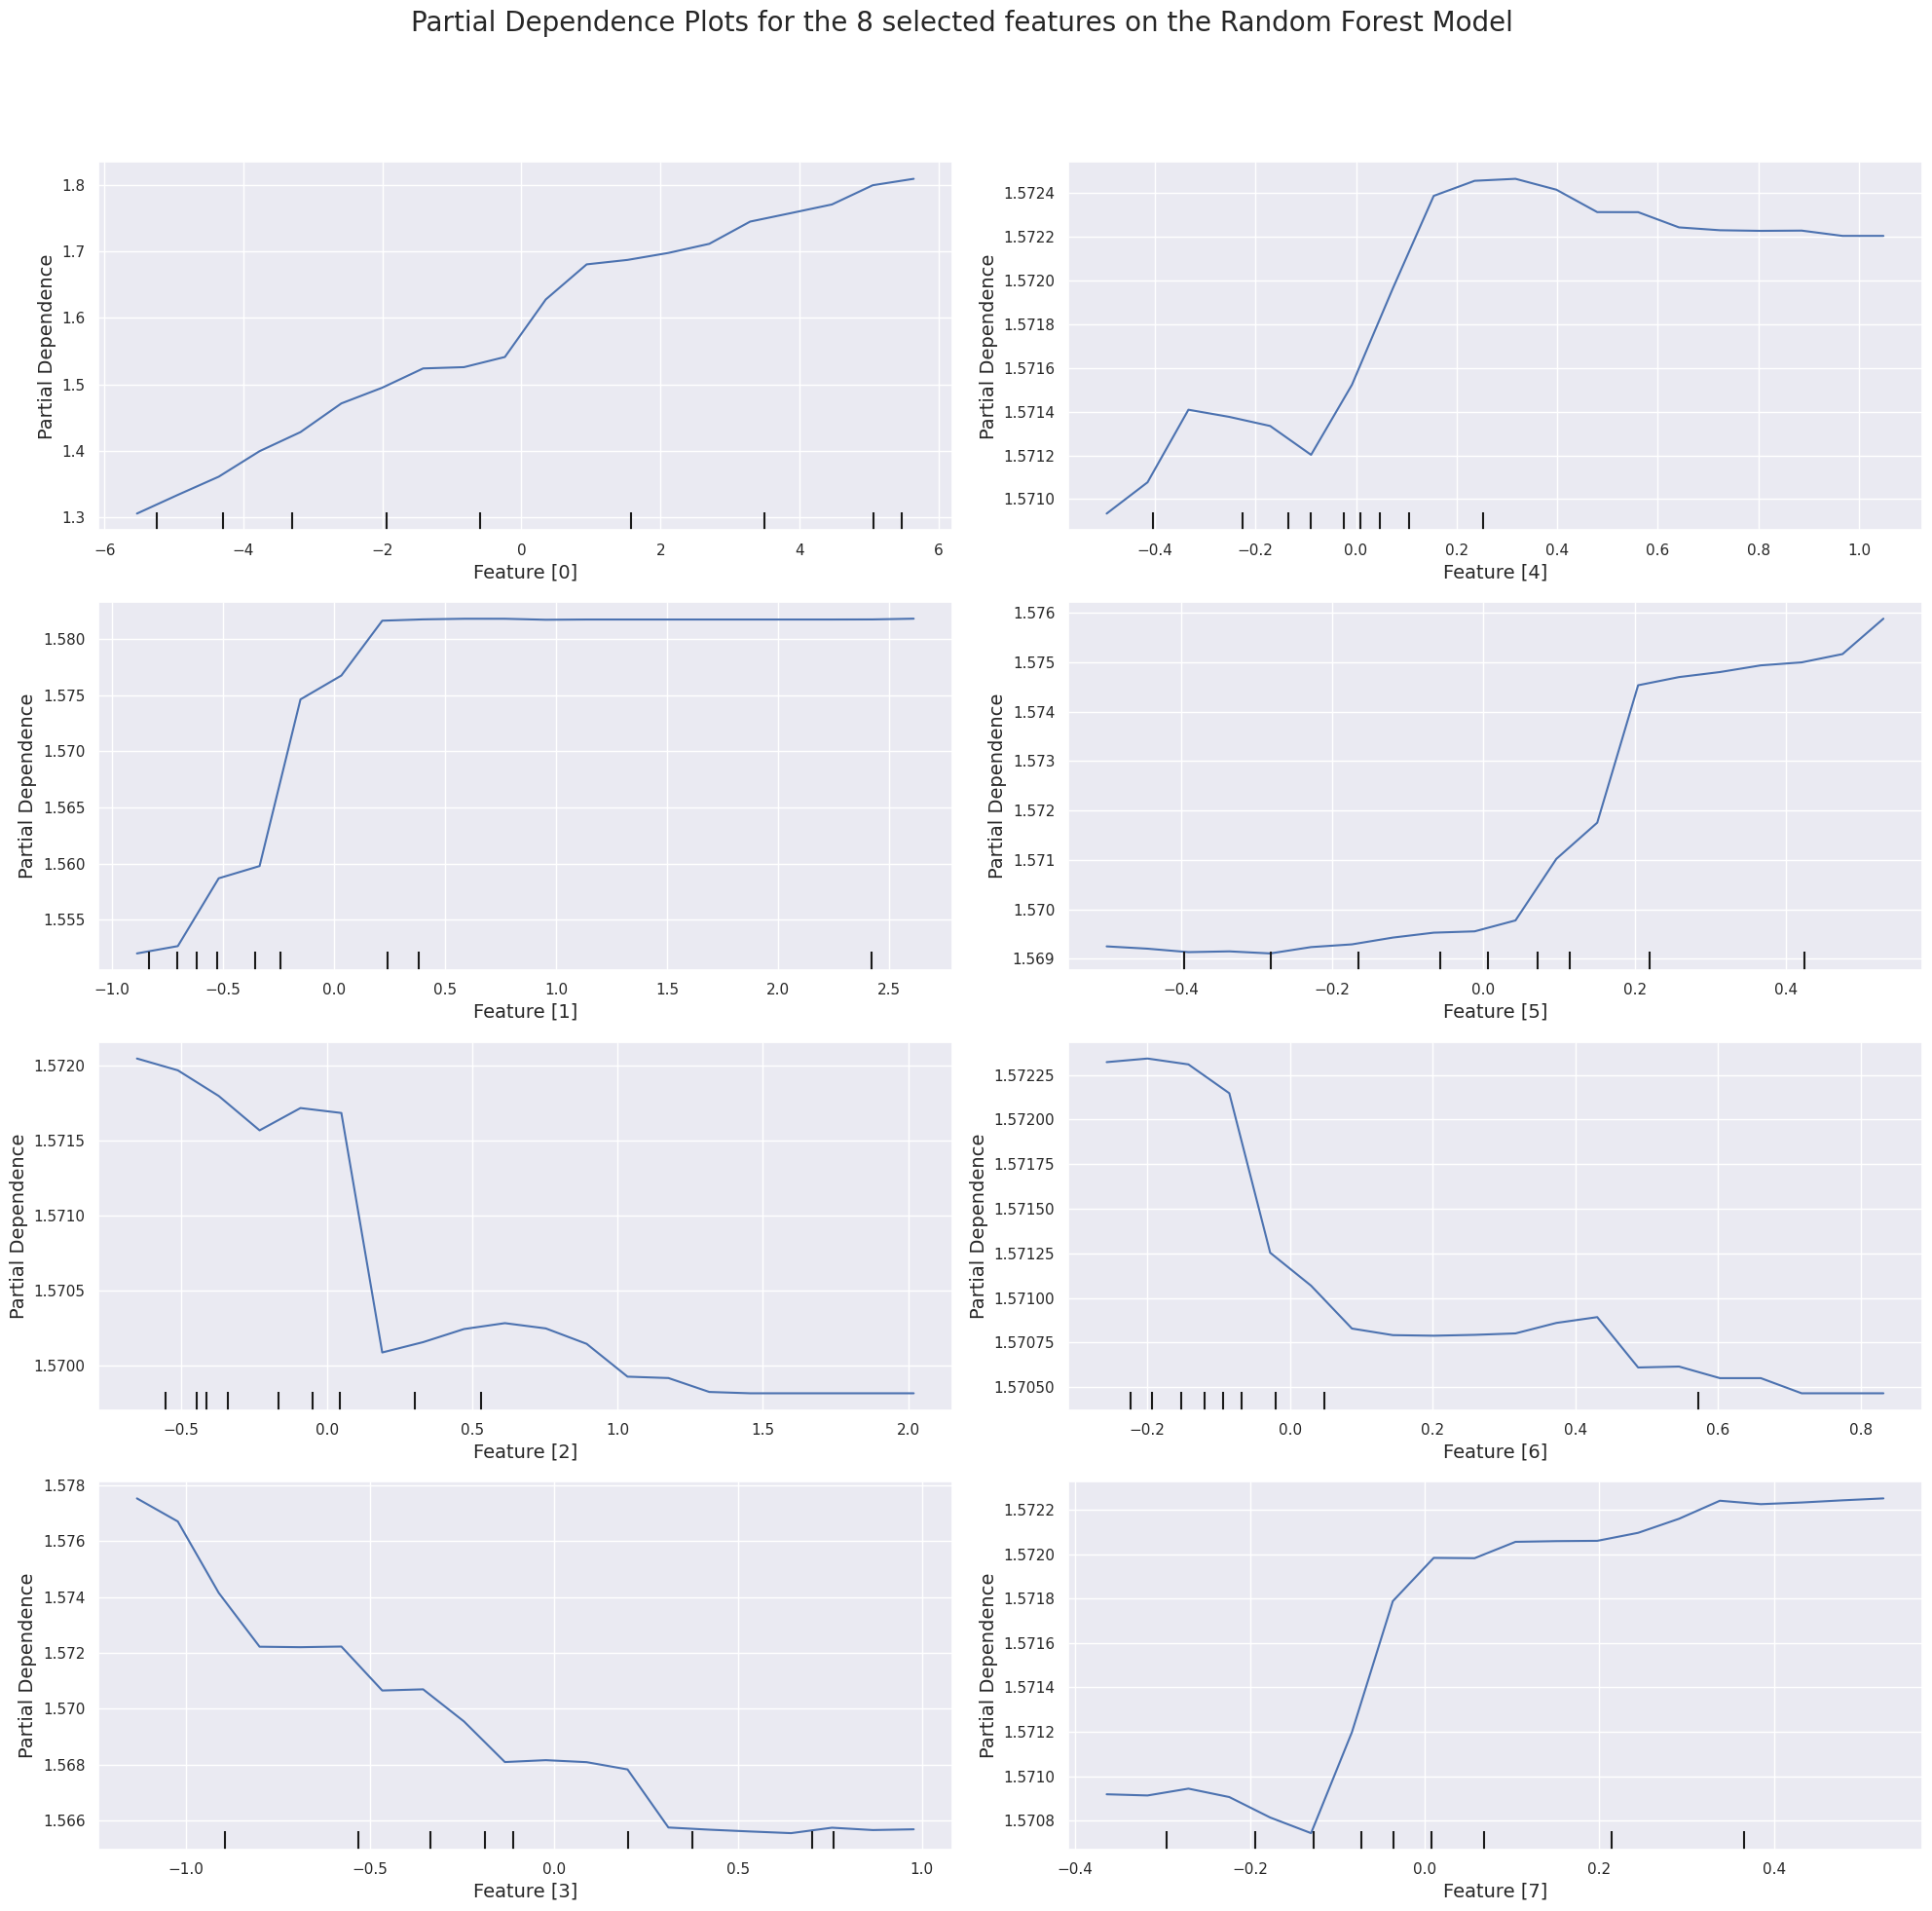

In [69]:
fig, axes = plt.subplots(4, 2, figsize = (20,20))
fig.suptitle("Partial Dependence Plots for the 8 selected features on the Random Forest Model \n", fontsize=20)

for (i, j) in zip(features[0], np.arange(4)):
    partial_dependence_plot(regressor, i, axes[j,0])
for (i, j) in zip(features[1], np.arange(4)):
    partial_dependence_plot(regressor, i, axes[j,1])

fig.tight_layout(rect=[0, 0, 1, 0.95]) # For removing extra whitespace introduced on using fig.suptitle

The PDPs for the Random Forest look like _smoothened steps_. This can be understood by looking at a Random Forest as a collection of decision trees which are making binary decisions depending on some criterion. The steps are not sharp because the features after PCA are not **pure**. They are a mixture of all the original features.

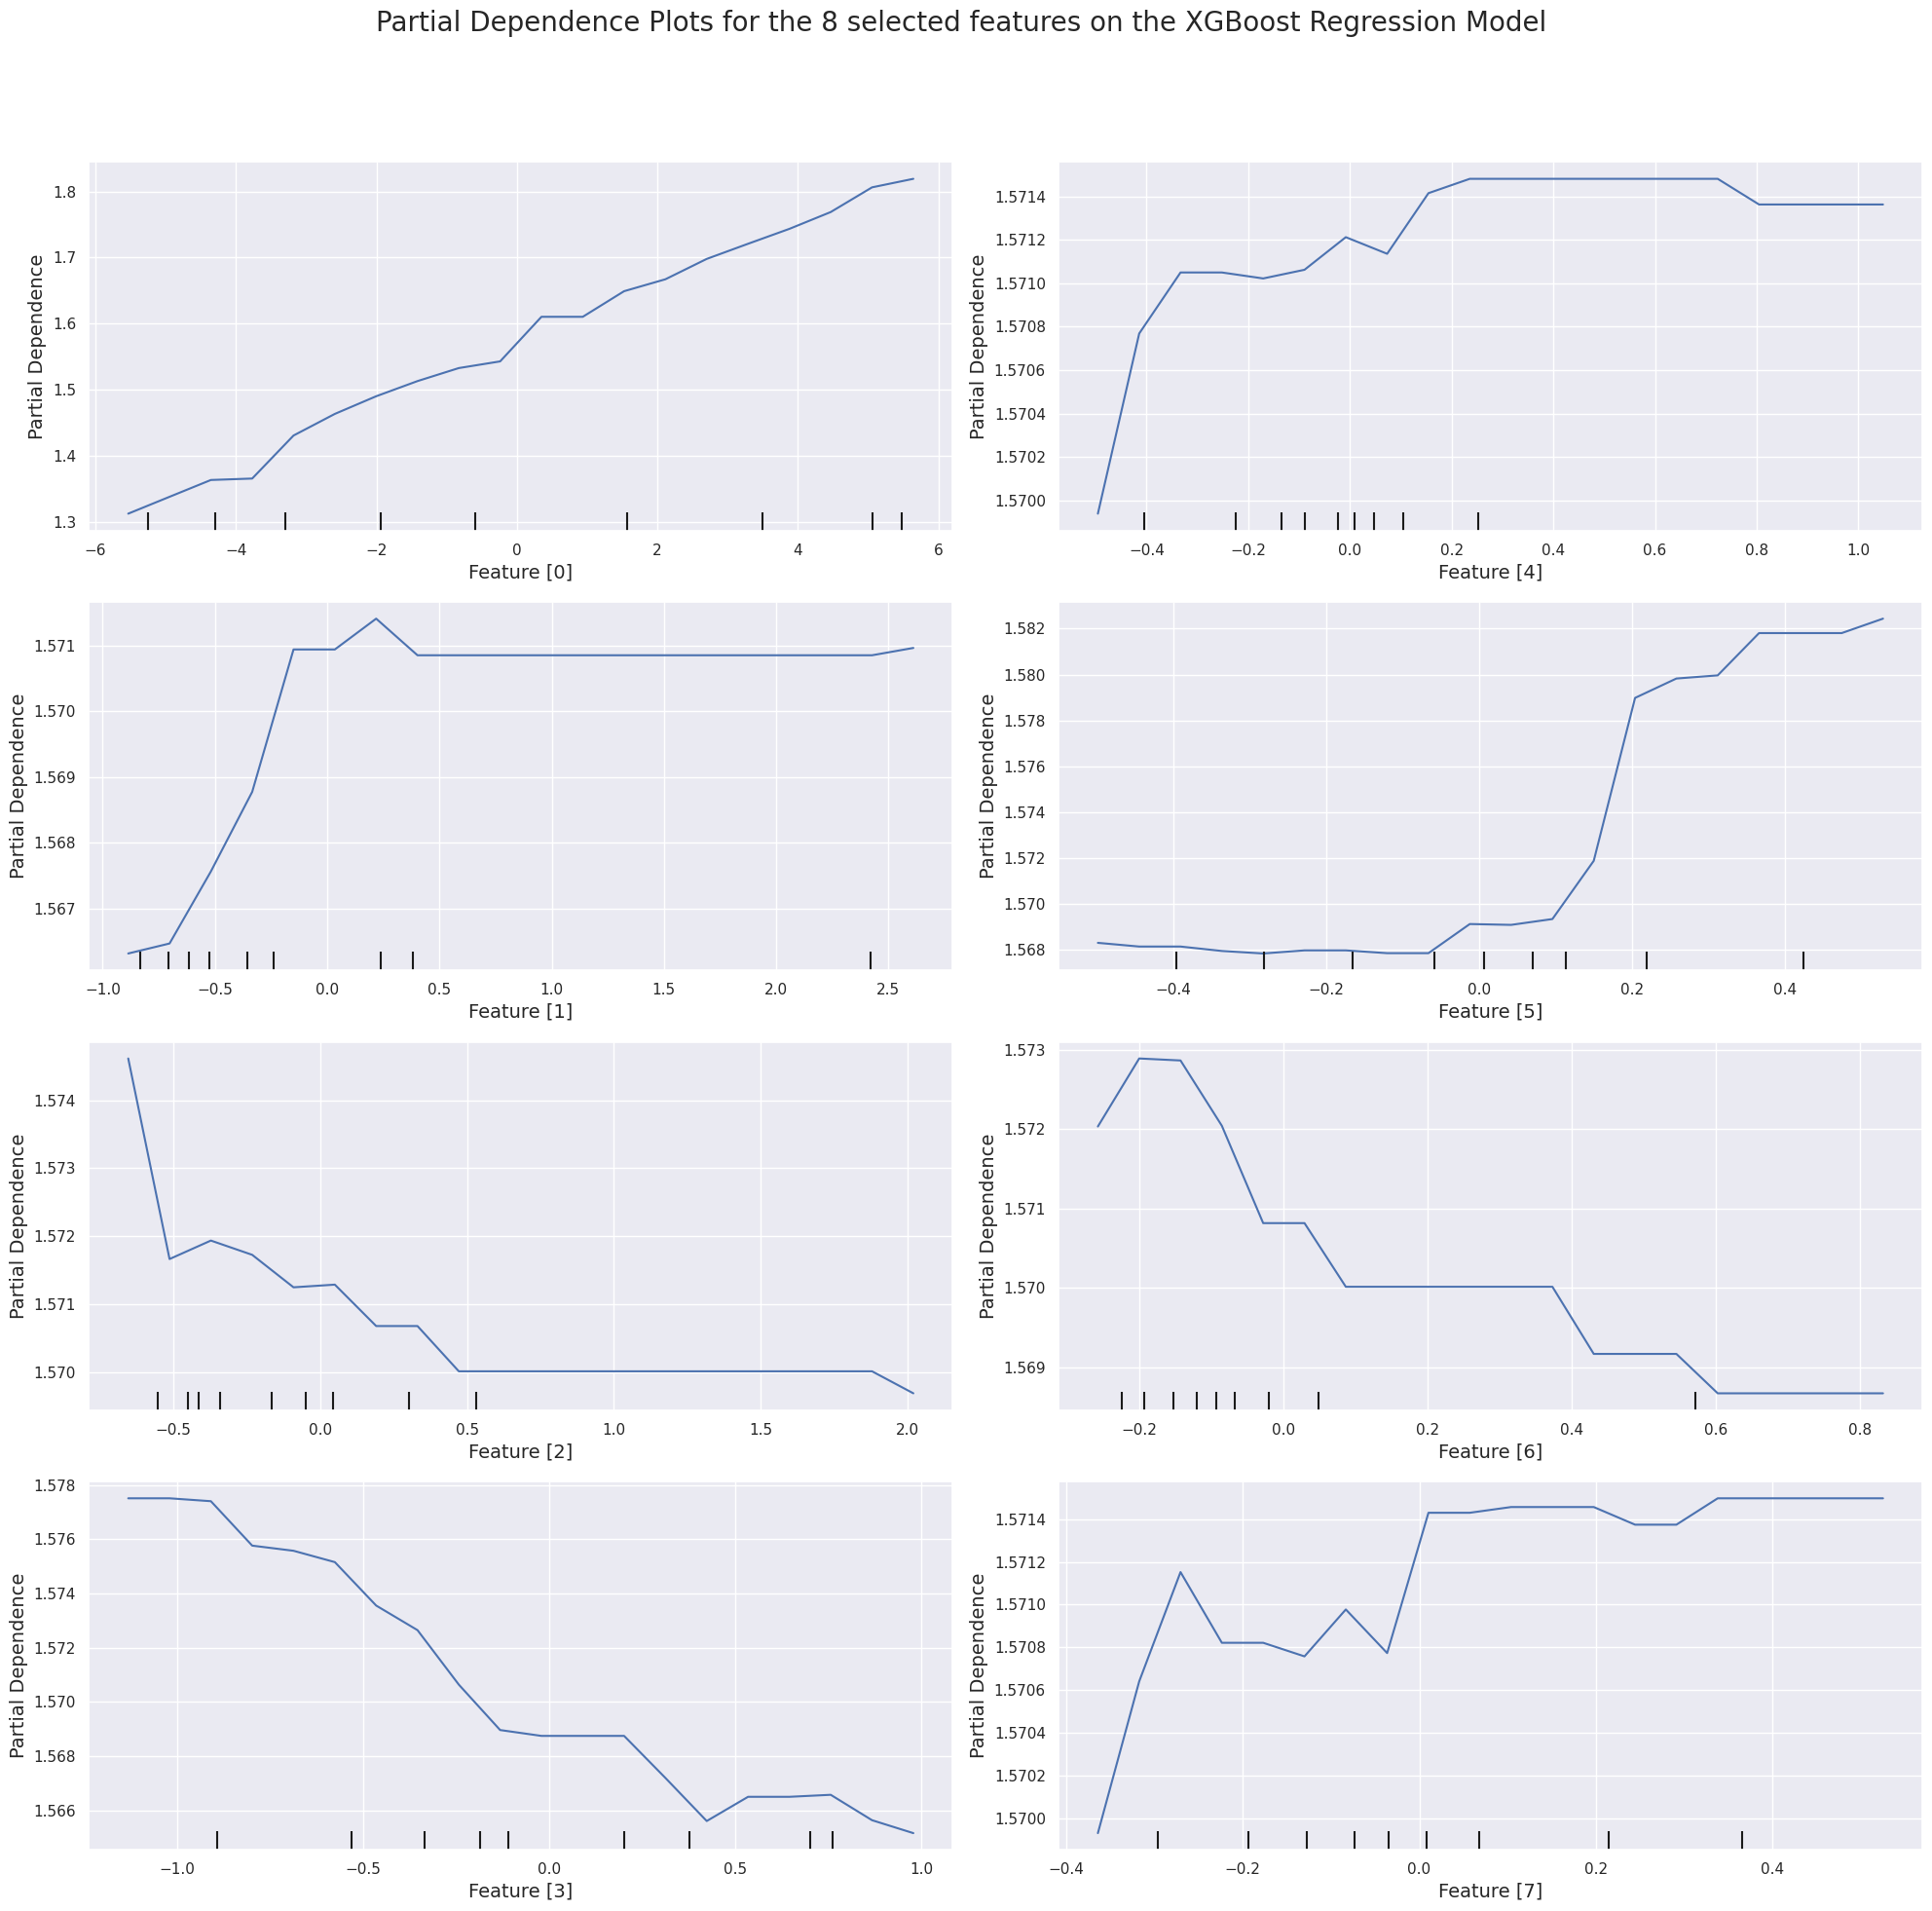

In [70]:
fig, axes = plt.subplots(4, 2, figsize = (20,20))
fig.suptitle("Partial Dependence Plots for the 8 selected features on the XGBoost Regression Model \n", fontsize=20)

xgbr.dummy_ = "dummy"
for (i, j) in zip(features[0], np.arange(4)):
    partial_dependence_plot(xgbr, i, axes[j,0])
for (i, j) in zip(features[1], np.arange(4)):
    partial_dependence_plot(xgbr, i, axes[j,1])

fig.tight_layout(rect=[0, 0, 1, 0.95]) # For removing extra whitespace introduced on using fig.suptitle

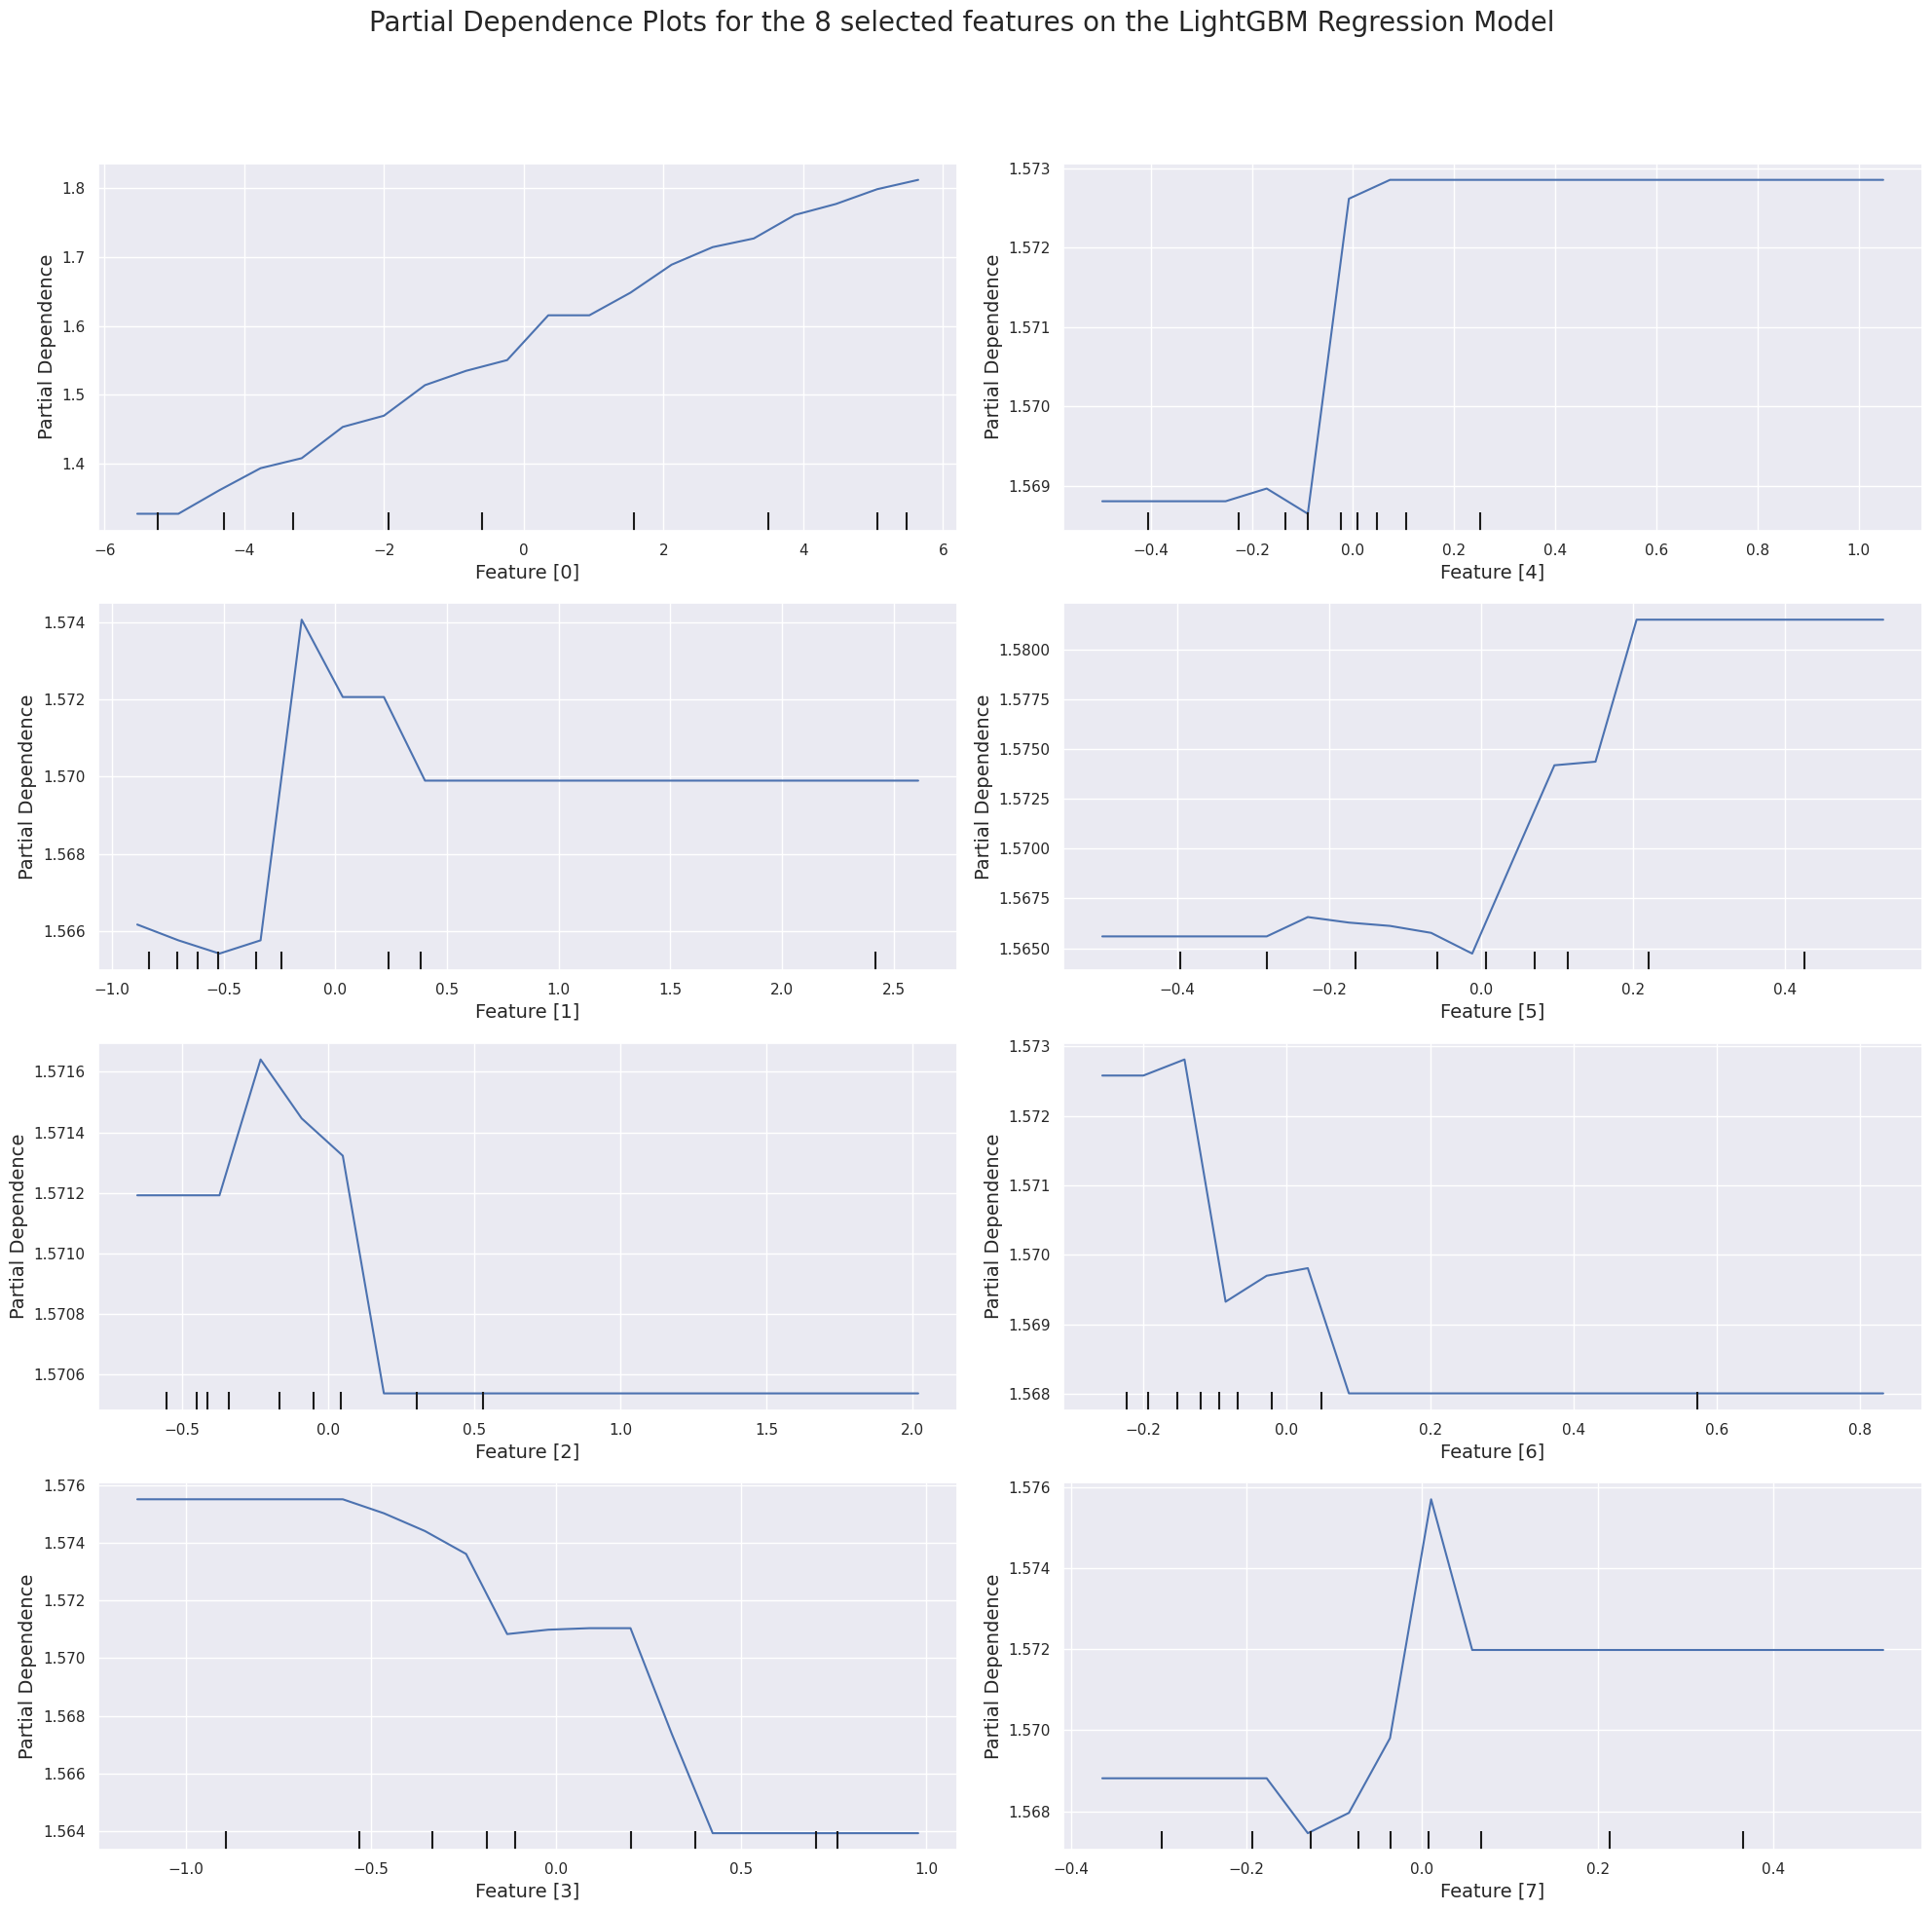

In [71]:
fig, axes = plt.subplots(4, 2, figsize = (20,20))
fig.suptitle("Partial Dependence Plots for the 8 selected features on the LightGBM Regression Model \n", fontsize=20)

lgbmr.dummy_ = "dummy"
for (i, j) in zip(features[0], np.arange(4)):
    partial_dependence_plot(lgbmr, i, axes[j,0])
for (i, j) in zip(features[1], np.arange(4)):
    partial_dependence_plot(lgbmr, i, axes[j,1])

fig.tight_layout(rect=[0, 0, 1, 0.95]) # For removing extra whitespace introduced on using fig.suptitle

### Addendum
In the process of carrying out PCA, our features lost their meaning. It would be interesting to see the nature of PDPs without PCA to compare and contrast with the PDPs above.

In [72]:
x, y = preprocessing(5, 16)     # using cell 5 for training

# Using the original data but not carrying out PCA
train_x1, test_x1, train_y1, test_y1 = train_test_split(x, y, train_size = 0.8)

# Standardize the training data
scaler = StandardScaler()
# Fit the scaler to X_train
scaler.fit(train_x1)

# Transform the entire data using the computed mean and variance
train_x1 = scaler.transform(train_x1)
test_x1 = scaler.transform(test_x1)

Having normalised our data, we can train models and plots the PDPs.

In [73]:
s = SVR()
s.fit(train_x1, train_y1)

print(blue(f"Evaluating the Support Vector Regressor...", 'bold'))
print(f"R2 Score = {s.score(test_x1, test_y1):.4f}")

mse = mean_squared_error(s.predict(test_x1), test_y1)
rmse = np.sqrt(mse)
print(f"RMSE = {rmse:.4f}")

Evaluating the Support Vector Regressor...
R2 Score = 0.9172
RMSE = 0.0542


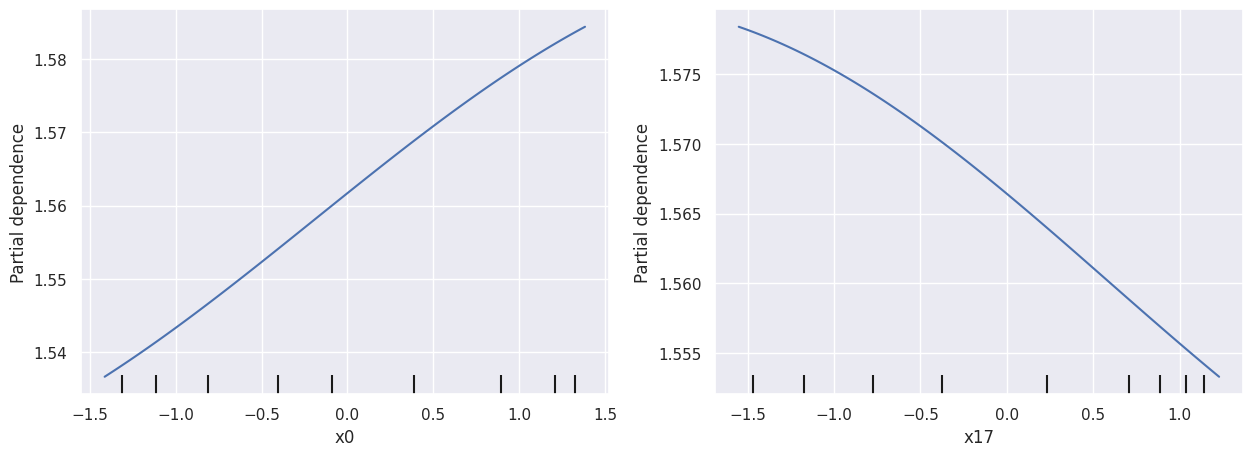

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
# PDP for time at which battery voltage hits 2.7V
disp_s0 = PartialDependenceDisplay.from_estimator(s, train_x1, features=[0], ax=ax1)

# PDP for maximum temperature
disp_s17 = PartialDependenceDisplay.from_estimator(s, train_x1, features=[17], ax=ax2)

The plot looks very similar to the one with PCA. This goes well with our analysis because we expect the capacity to be higher when the time taken to reach 2.7V is higher and the maximum battery temperature is lower.

In [75]:
# Using the pre-built sklearn RF regressor without tuning
rf = RandomForestRegressor(n_estimators = 100)
rf.fit(train_x1, train_y1)

print(blue(f"Evaluating the Random Forest Regressor...", 'bold'))
print(f"R2 Score = {rf.score(test_x1, test_y1):.4f}")

mse = mean_squared_error(rf.predict(test_x1), test_y1)
rmse = np.sqrt(mse)
print(f"RMSE = {rmse:.4f}")

Evaluating the Random Forest Regressor...
R2 Score = 0.9993
RMSE = 0.0049


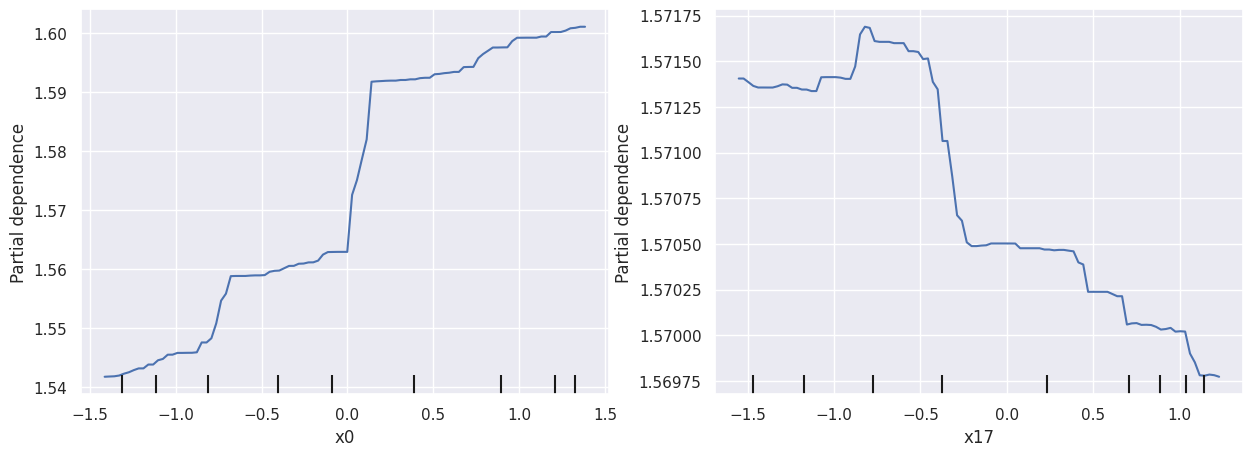

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
# PDP for time at which battery voltage hits 2.7V
disp_rf0 = PartialDependenceDisplay.from_estimator(rf, train_x1, features=[0], ax=ax1)

# PDP for maximum temperature
disp_rf17 = PartialDependenceDisplay.from_estimator(rf, train_x1, features=[17], ax=ax2)

The plot looks very similar to the one with PCA except that the steps are more pronounced. It is also interesting to observe that the models have achieved similar results even without PCA although the features we started with were highly correlated.

# DBN

In [93]:
!pip install pydeeplearning deep-learning

In [82]:
!pip install torch torchvision


In [94]:
# from pydeeplearning.dbn import DBN
# from sklearn.datasets import make_classification
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# # Generate a dummy dataset for classification
# X, y = make_classification(n_samples=1000, n_features=20, n_informative=15,
#                            n_classes=2, random_state=42)

# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # Normalize the input data
# X_train = X_train / X_train.max()
# X_test = X_test / X_test.max()

# # Define the Deep Belief Network (DBN)
# dbn = DBN(
#     layers=[20, 64, 64, 2],  # Number of neurons in each layer (input, hidden1, hidden2, output)
#     learn_rates=0.1,         # Learning rate
#     learn_rate_decays=0.9,   # Learning rate decay over time
#     epochs=10,               # Number of epochs
#     verbose=1,               # Verbosity mode
#     minibatch_size=32,       # Batch size
#     momentum=0.9,            # Momentum for optimization
#     use_re_lu=True           # Use ReLU activation
# )

# # Train the DBN on the training data
# dbn.fit(X_train, y_train)

# # Use the trained DBN to make predictions on the test data
# y_pred = dbn.predict(X_test)

# # Evaluate the DBN's performance
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy of the DBN: {accuracy:.4f}')


ModuleNotFoundError: No module named 'pydeeplearning'

In [86]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import torch.nn.functional as F

# Restricted Boltzmann Machine (RBM) implementation
class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hidden, n_visible) * 0.1)
        self.h_bias = nn.Parameter(torch.zeros(n_hidden))
        self.v_bias = nn.Parameter(torch.zeros(n_visible))

    def sample_h(self, v):
        h_prob = torch.sigmoid(F.linear(v, self.W, self.h_bias))
        return h_prob, torch.bernoulli(h_prob)

    def sample_v(self, h):
        v_prob = torch.sigmoid(F.linear(h, self.W.t(), self.v_bias))
        return v_prob, torch.bernoulli(v_prob)

    def forward(self, v):
        _, h = self.sample_h(v)
        return h

    def contrastive_divergence(self, v, k=1):
        v0 = v
        h0_prob, h0 = self.sample_h(v0)

        for step in range(k):
            v_prob, v_sample = self.sample_v(h0)
            h_prob, h_sample = self.sample_h(v_sample)

        return v0, v_prob

    def loss(self, v, v_prob):
        return torch.mean(torch.sum((v - v_prob) ** 2, dim=1))

# Deep Belief Network (DBN) implementation
class DBN(nn.Module):
    def __init__(self, layers, n_classes):
        super(DBN, self).__init__()
        self.rbms = nn.ModuleList([RBM(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
        self.classifier = nn.Sequential(
            nn.Linear(layers[-1], 128),
            nn.ReLU(),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        for rbm in self.rbms:
            x = rbm(x)
        return self.classifier(x)

    def pretrain(self, data, epochs=10, lr=0.01, k=1):
        optimizer = optim.SGD(self.parameters(), lr=lr)
        for epoch in range(epochs):
            epoch_loss = 0
            for batch in data:
                v0 = batch
                optimizer.zero_grad()
                v0, v_prob = self.rbms[0].contrastive_divergence(v0, k)
                loss = self.rbms[0].loss(v0, v_prob)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            print(f"Pretraining epoch {epoch + 1}, loss: {epoch_loss:.4f}")

    def finetune(self, train_data, labels, epochs=10, lr=0.01):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.classifier.parameters(), lr=lr)
        for epoch in range(epochs):
            optimizer.zero_grad()
            output = self.forward(train_data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            print(f"Finetuning epoch {epoch + 1}, loss: {loss.item():.4f}")

# Generate dataset
X, y = make_classification(n_samples=1000, n_features=50, n_informative=30, n_classes=2, random_state=42)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# Define DBN structure and train it
layers = [50, 128, 64]
dbn = DBN(layers=layers, n_classes=2)

# Pretrain the RBM layers
dbn.pretrain(data=[X_train], epochs=5, lr=0.01)

# Finetune the entire DBN for classification
dbn.finetune(X_train, y_train, epochs=5, lr=0.001)

# Evaluate on test data
with torch.no_grad():
    y_pred = dbn(X_test)
    y_pred = torch.argmax(y_pred, dim=1)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')


Pretraining epoch 1, loss: 55.9224
Pretraining epoch 2, loss: 55.3290
Pretraining epoch 3, loss: 54.5669
Pretraining epoch 4, loss: 54.0169
Pretraining epoch 5, loss: 53.4522
Finetuning epoch 1, loss: 0.7103
Finetuning epoch 2, loss: 0.6979
Finetuning epoch 3, loss: 0.6946
Finetuning epoch 4, loss: 0.6963
Finetuning epoch 5, loss: 0.6961
Accuracy: 0.5533


In [88]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Restricted Boltzmann Machine (RBM) implementation
class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hidden, n_visible) * 0.1)
        self.h_bias = nn.Parameter(torch.zeros(n_hidden))
        self.v_bias = nn.Parameter(torch.zeros(n_visible))

    def sample_h(self, v):
        h_prob = torch.sigmoid(F.linear(v, self.W, self.h_bias))
        return h_prob, torch.bernoulli(h_prob)

    def sample_v(self, h):
        v_prob = torch.sigmoid(F.linear(h, self.W.t(), self.v_bias))
        return v_prob, torch.bernoulli(v_prob)

    def forward(self, v):
        h_prob, h = self.sample_h(v)
        return h_prob

    def contrastive_divergence(self, v, k=1):
        v0 = v
        h_prob, h = self.sample_h(v0)

        for _ in range(k):
            v_prob, v_sample = self.sample_v(h)
            h_prob, h = self.sample_h(v_sample)

        return v0, v_prob

    def loss(self, v, v_prob):
        return torch.mean((v - v_prob) ** 2)

# Deep Belief Network (DBN) implementation
class DBN(nn.Module):
    def __init__(self, layers, n_classes):
        super(DBN, self).__init__()
        self.rbms = nn.ModuleList([RBM(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
        self.classifier = nn.Sequential(
            nn.Linear(layers[-1], 128),
            nn.ReLU(),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        for rbm in self.rbms:
            x = rbm.forward(x)
        return self.classifier(x)

    def pretrain(self, data, epochs=10, lr=0.01, k=1):
        current_data = data
        for idx, rbm in enumerate(self.rbms):
            print(f"\nPretraining RBM layer {idx + 1}/{len(self.rbms)}")
            optimizer = optim.SGD(rbm.parameters(), lr=lr)
            for epoch in range(epochs):
                epoch_loss = 0
                for batch in current_data:
                    v0 = batch.unsqueeze(0)  # Add batch dimension
                    optimizer.zero_grad()
                    v0, v_prob = rbm.contrastive_divergence(v0, k)
                    loss = rbm.loss(v0, v_prob)
                    loss.backward()
                    optimizer.step()
                    epoch_loss += loss.item()
                print(f"RBM Layer {idx + 1}, Epoch {epoch + 1}, Loss: {epoch_loss / len(current_data):.4f}")
            # After training, get the hidden activations to use as input for the next layer
            with torch.no_grad():
                h_prob = []
                for batch in current_data:
                    h_p, _ = rbm.sample_h(batch.unsqueeze(0))
                    h_prob.append(h_p.squeeze(0))
                current_data = torch.stack(h_prob)

    def finetune(self, train_data, labels, epochs=10, lr=0.001):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)
        for epoch in range(epochs):
            optimizer.zero_grad()
            output = self.forward(train_data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            print(f"Finetuning Epoch {epoch + 1}, Loss: {loss.item():.4f}")

# Generate dataset
X, y = make_classification(n_samples=1000, n_features=50, n_informative=30, n_classes=2, random_state=42)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# Define DBN structure and train it
layers = [50, 128, 64]
dbn = DBN(layers=layers, n_classes=2)

# Pretrain the RBM layers
dbn.pretrain(data=X_train, epochs=10, lr=0.01)

# Finetune the entire DBN for classification
dbn.finetune(X_train, y_train, epochs=20, lr=0.001)

# Evaluate on test data
with torch.no_grad():
    y_pred = dbn(X_test)
    y_pred = torch.argmax(y_pred, dim=1)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'\nAccuracy: {accuracy:.4f}')



Pretraining RBM layer 1/2
RBM Layer 1, Epoch 1, Loss: 1.0760
RBM Layer 1, Epoch 2, Loss: 0.9916
RBM Layer 1, Epoch 3, Loss: 0.9659
RBM Layer 1, Epoch 4, Loss: 0.9569
RBM Layer 1, Epoch 5, Loss: 0.9550
RBM Layer 1, Epoch 6, Loss: 0.9509
RBM Layer 1, Epoch 7, Loss: 0.9496
RBM Layer 1, Epoch 8, Loss: 0.9490
RBM Layer 1, Epoch 9, Loss: 0.9467
RBM Layer 1, Epoch 10, Loss: 0.9457

Pretraining RBM layer 2/2
RBM Layer 2, Epoch 1, Loss: 0.0437
RBM Layer 2, Epoch 2, Loss: 0.0424
RBM Layer 2, Epoch 3, Loss: 0.0415
RBM Layer 2, Epoch 4, Loss: 0.0405
RBM Layer 2, Epoch 5, Loss: 0.0395
RBM Layer 2, Epoch 6, Loss: 0.0390
RBM Layer 2, Epoch 7, Loss: 0.0387
RBM Layer 2, Epoch 8, Loss: 0.0380
RBM Layer 2, Epoch 9, Loss: 0.0377
RBM Layer 2, Epoch 10, Loss: 0.0373
Finetuning Epoch 1, Loss: 0.7008
Finetuning Epoch 2, Loss: 0.6934
Finetuning Epoch 3, Loss: 0.6924
Finetuning Epoch 4, Loss: 0.6934
Finetuning Epoch 5, Loss: 0.6931
Finetuning Epoch 6, Loss: 0.6917
Finetuning Epoch 7, Loss: 0.6901
Finetuning Ep

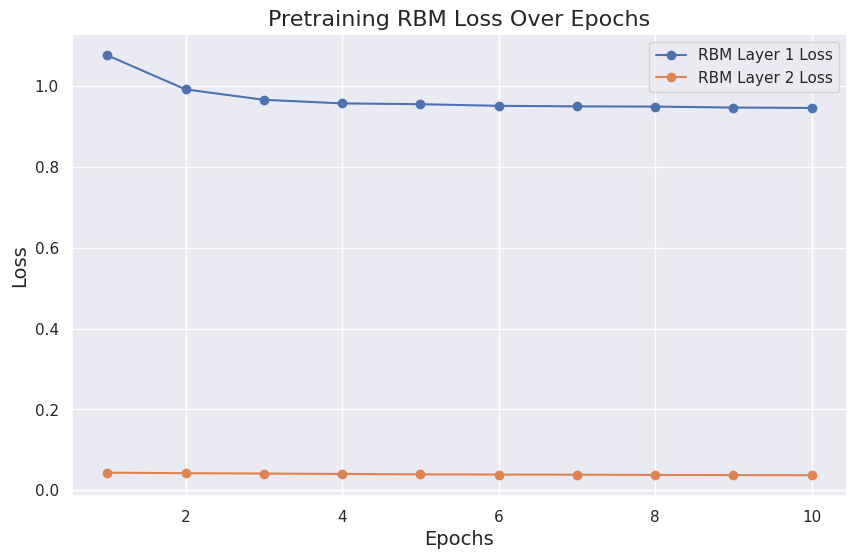

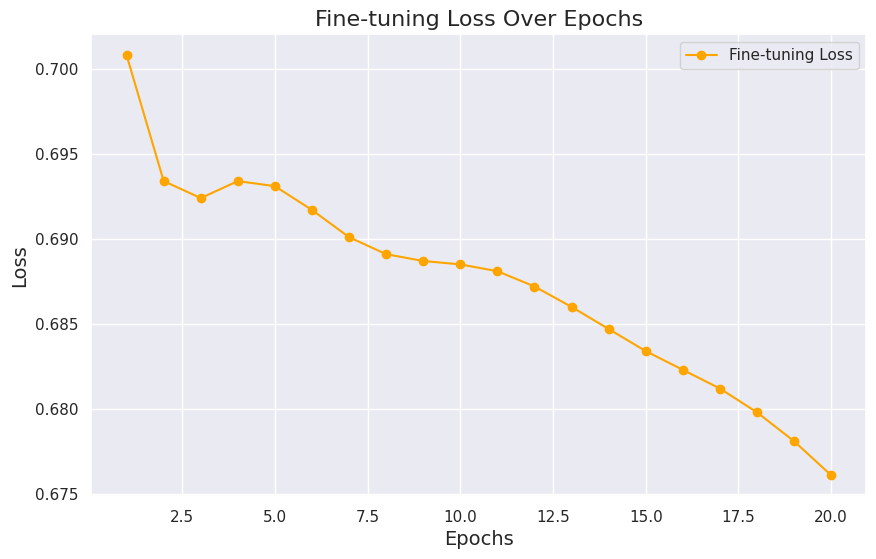

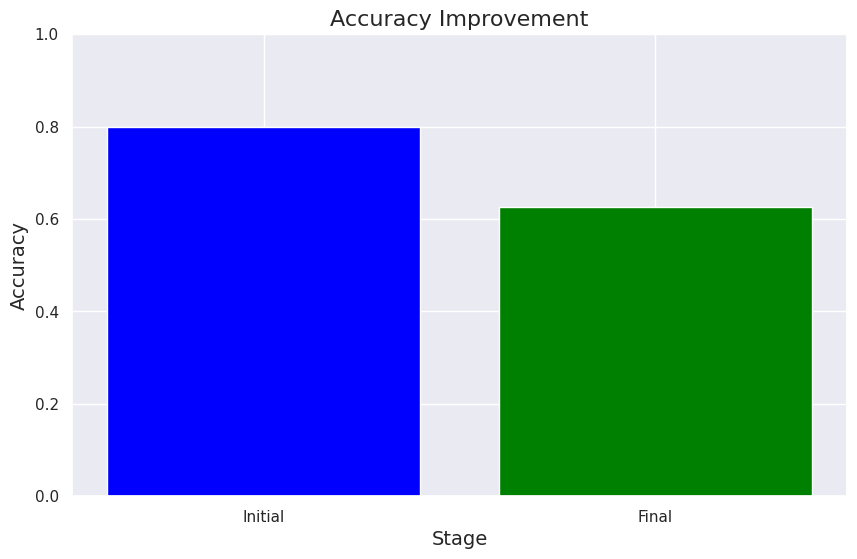

In [90]:
import matplotlib.pyplot as plt
import numpy as np

# Pretraining RBM loss visualization
epochs = np.arange(1, 11)
loss_rbm1 = [1.0760, 0.9916, 0.9659, 0.9569, 0.9550, 0.9509, 0.9496, 0.9490, 0.9467, 0.9457]
loss_rbm2 = [0.0437, 0.0424, 0.0415, 0.0405, 0.0395, 0.0390, 0.0387, 0.0380, 0.0377, 0.0373]

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_rbm1, label="RBM Layer 1 Loss", marker='o')
plt.plot(epochs, loss_rbm2, label="RBM Layer 2 Loss", marker='o')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Pretraining RBM Loss Over Epochs', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

# Fine-tuning loss visualization
epochs_ft = np.arange(1, 21)
loss_finetuning = [0.7008, 0.6934, 0.6924, 0.6934, 0.6931, 0.6917, 0.6901, 0.6891,
                   0.6887, 0.6885, 0.6881, 0.6872, 0.6860, 0.6847, 0.6834, 0.6823,
                   0.6812, 0.6798, 0.6781, 0.6761]

plt.figure(figsize=(10, 6))
plt.plot(epochs_ft, loss_finetuning, label="Fine-tuning Loss", marker='o', color='orange')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Fine-tuning Loss Over Epochs', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

# Accuracy visualization
accuracy = [0.8, 0.6267]
plt.figure(figsize=(10, 6))
plt.bar(['Initial', 'Final'], accuracy, color=['blue', 'green'])
plt.xlabel('Stage', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Accuracy Improvement', fontsize=16)
plt.ylim([0, 1])
plt.show()


Pretraining RBM layer 1/2
RBM Layer 1, Epoch 1, Loss: 5.3603
RBM Layer 1, Epoch 2, Loss: 5.3561
RBM Layer 1, Epoch 3, Loss: 5.3553
RBM Layer 1, Epoch 4, Loss: 5.3525
RBM Layer 1, Epoch 5, Loss: 5.3491
RBM Layer 1, Epoch 6, Loss: 5.3518
RBM Layer 1, Epoch 7, Loss: 5.3498
RBM Layer 1, Epoch 8, Loss: 5.3483
RBM Layer 1, Epoch 9, Loss: 5.3473
RBM Layer 1, Epoch 10, Loss: 5.3442
Pretraining RBM layer 2/2
RBM Layer 2, Epoch 1, Loss: 0.0428
RBM Layer 2, Epoch 2, Loss: 0.0405
RBM Layer 2, Epoch 3, Loss: 0.0388
RBM Layer 2, Epoch 4, Loss: 0.0367
RBM Layer 2, Epoch 5, Loss: 0.0350
RBM Layer 2, Epoch 6, Loss: 0.0337
RBM Layer 2, Epoch 7, Loss: 0.0321
RBM Layer 2, Epoch 8, Loss: 0.0307
RBM Layer 2, Epoch 9, Loss: 0.0292
RBM Layer 2, Epoch 10, Loss: 0.0284
Finetuning Epoch 1, Loss: 0.6932
Finetuning Epoch 2, Loss: 0.6936
Finetuning Epoch 3, Loss: 0.6932
Finetuning Epoch 4, Loss: 0.6932
Finetuning Epoch 5, Loss: 0.6933
Finetuning Epoch 6, Loss: 0.6933
Finetuning Epoch 7, Loss: 0.6931
Finetuning Epoc

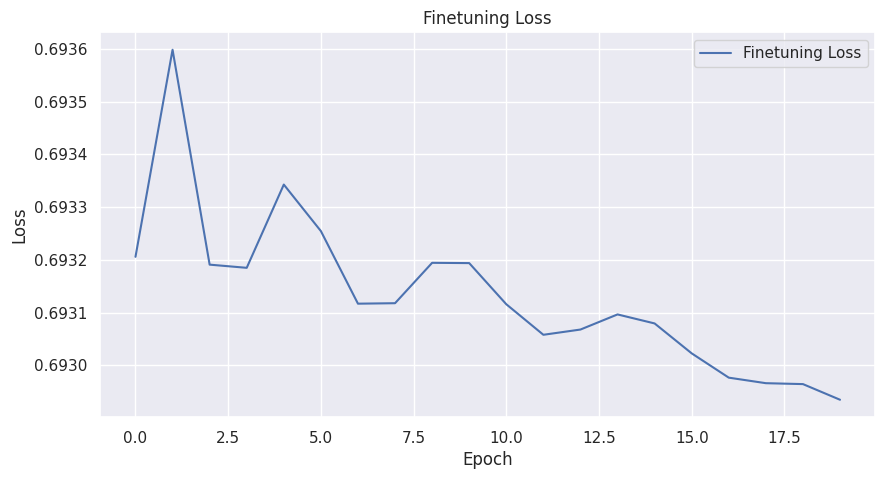

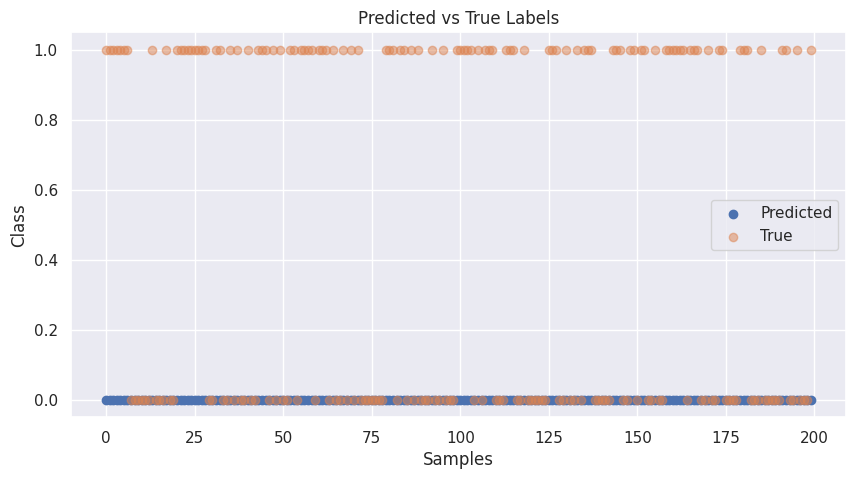

In [105]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Define the RBM class
class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden):
        super(RBM, self).__init__()
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.W = nn.Parameter(torch.randn(n_hidden, n_visible) * 0.01)
        self.h_bias = nn.Parameter(torch.zeros(n_hidden))
        self.v_bias = nn.Parameter(torch.zeros(n_visible))

    def sample_h(self, v):
        h_prob = torch.sigmoid(F.linear(v, self.W, self.h_bias))
        return h_prob, torch.bernoulli(h_prob)

    def sample_v(self, h):
        v_prob = torch.sigmoid(F.linear(h, self.W.t(), self.v_bias))
        return v_prob, torch.bernoulli(v_prob)

    def contrastive_divergence(self, v, lr):
        v0 = v
        h_prob, h_sample = self.sample_h(v0)
        v_prob, v_sample = self.sample_v(h_sample)
        h_prob_1, _ = self.sample_h(v_sample)

        positive_grad = torch.matmul(h_prob.t(), v0)
        negative_grad = torch.matmul(h_prob_1.t(), v_sample)

        self.W.data += lr * (positive_grad - negative_grad) / v.size(0)
        self.v_bias.data += lr * torch.mean(v0 - v_sample, dim=0)
        self.h_bias.data += lr * torch.mean(h_prob - h_prob_1, dim=0)

        loss = torch.mean(torch.sum((v0 - v_prob) ** 2, dim=1))
        return loss.item()

# Define the DBN class
class DBN(nn.Module):
    def __init__(self, n_visible, hidden_layers, n_output):
        super(DBN, self).__init__()
        self.rbms = nn.ModuleList([RBM(n_visible if i == 0 else hidden_layers[i-1], h) for i, h in enumerate(hidden_layers)])
        self.classifier = nn.Linear(hidden_layers[-1], n_output)

    def forward(self, x):
        for i, rbm in enumerate(self.rbms):
            x, _ = rbm.sample_h(x)
        return torch.softmax(self.classifier(x), dim=1)

    def pretrain(self, data, epochs=10, lr=0.01):
        for layer_num, rbm in enumerate(self.rbms):
            print(f"Pretraining RBM layer {layer_num + 1}/{len(self.rbms)}")
            layer_input = data
            if layer_num > 0:
                for prev_rbm in self.rbms[:layer_num]:
                    layer_input, _ = prev_rbm.sample_h(layer_input)
            for epoch in range(epochs):
                loss = rbm.contrastive_divergence(layer_input, lr)
                print(f"RBM Layer {layer_num + 1}, Epoch {epoch + 1}, Loss: {loss:.4f}")

# Create synthetic data
X, y = torch.rand(1000, 64), torch.randint(0, 2, (1000,))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initialize DBN with two RBM layers
dbn = DBN(n_visible=64, hidden_layers=[128, 64], n_output=2)

# Pretrain RBM layers
dbn.pretrain(data=X_train, epochs=10, lr=0.01)

# Fine-tuning with backpropagation
optimizer = optim.Adam(dbn.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

epochs = 20
finetune_losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    output = dbn(X_train)
    loss = loss_fn(output, y_train)
    loss.backward()
    optimizer.step()
    finetune_losses.append(loss.item())
    print(f"Finetuning Epoch {epoch + 1}, Loss: {loss:.4f}")

# Test the model
with torch.no_grad():
    y_pred = torch.argmax(dbn(X_test), dim=1)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

# Visualizing the results

# Pretraining loss visualization
plt.figure(figsize=(10, 5))
plt.plot(finetune_losses, label='Finetuning Loss')
plt.title('Finetuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Scatter plot of predicted vs true labels
plt.figure(figsize=(10, 5))
plt.scatter(range(len(y_test)), y_pred, label='Predicted')
plt.scatter(range(len(y_test)), y_test, label='True', alpha=0.5)
plt.title('Predicted vs True Labels')
plt.xlabel('Samples')
plt.ylabel('Class')
plt.legend()
plt.show()

In [111]:
import pandas as pd
import torch
import numpy as np

# Load the data
def split_data(cell_number):
    num = '0' + str(cell_number) if cell_number != 18 else '18'
    df = pd.read_pickle('B00' + num + '.pkl')
    charge = df[df['type'] == 'charge']
    discharge = df[df['type'] == 'discharge']
    impedance = df[df['type'] == 'impedance']
    return charge, discharge, impedance

charge, discharge, impedance = split_data(cell_number=5)

# Convert pandas DataFrames to PyTorch tensors
def df_to_tensor(df):
    tensors = {}
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            val = df[col].to_numpy(dtype=np.float32)  # Ensure numeric conversion
            tensors[col] = torch.tensor(val, dtype=torch.float32)
        else:
            print(f"Skipping non-numeric column: {col} (Type: {df[col].dtype})")
    return tensors

charge_tensors = df_to_tensor(charge)
discharge_tensors = df_to_tensor(discharge)
impedance_tensors = df_to_tensor(impedance)

print("Charge DataFrame columns and types:")
print(charge.dtypes)

print("Discharge DataFrame columns and types:")
print(discharge.dtypes)

print("Impedance DataFrame columns and types:")
print(impedance.dtypes)

# Example: Use 'ambient_temperature' and 'time' for training
if 'ambient_temperature' in charge_tensors and 'time' in charge_tensors:
    X = charge_tensors['ambient_temperature']
    y = charge_tensors['time']
    print("Data for training is prepared.")
else:
    print("Required columns are not present in charge_tensors.")
    if 'ambient_temperature' not in charge_tensors:
        print("Column 'ambient_temperature' is missing.")
    if 'time' not in charge_tensors:
        print("Column 'time' is missing.")


Skipping non-numeric column: type (Type: object)
Skipping non-numeric column: data (Type: object)
Skipping non-numeric column: type (Type: object)
Skipping non-numeric column: data (Type: object)
Skipping non-numeric column: type (Type: object)
Skipping non-numeric column: data (Type: object)
Charge DataFrame columns and types:
type                    object
ambient_temperature      int64
time                   float64
data                    object
dtype: object
Discharge DataFrame columns and types:
type                    object
ambient_temperature      int64
time                   float64
data                    object
dtype: object
Impedance DataFrame columns and types:
type                    object
ambient_temperature      int64
time                   float64
data                    object
dtype: object
Data for training is prepared.


In [112]:
# Define the RBM class
class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden):
        super(RBM, self).__init__()
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.W = nn.Parameter(torch.randn(n_hidden, n_visible) * 0.01)
        self.h_bias = nn.Parameter(torch.zeros(n_hidden))
        self.v_bias = nn.Parameter(torch.zeros(n_visible))

    def sample_h(self, v):
        h_prob = torch.sigmoid(F.linear(v, self.W, self.h_bias))
        return h_prob, torch.bernoulli(h_prob)

    def sample_v(self, h):
        v_prob = torch.sigmoid(F.linear(h, self.W.t(), self.v_bias))
        return v_prob, torch.bernoulli(v_prob)

    def contrastive_divergence(self, v, lr):
        v0 = v
        h_prob, h_sample = self.sample_h(v0)
        v_prob, v_sample = self.sample_v(h_sample)
        h_prob_1, _ = self.sample_h(v_sample)

        positive_grad = torch.matmul(h_prob.t(), v0)
        negative_grad = torch.matmul(h_prob_1.t(), v_sample)

        self.W.data += lr * (positive_grad - negative_grad) / v.size(0)
        self.v_bias.data += lr * torch.mean(v0 - v_sample, dim=0)
        self.h_bias.data += lr * torch.mean(h_prob - h_prob_1, dim=0)

        loss = torch.mean(torch.sum((v0 - v_prob) ** 2, dim=1))
        return loss.item()

# Define the DBN class
class DBN(nn.Module):
    def __init__(self, n_visible, hidden_layers, n_output):
        super(DBN, self).__init__()
        self.rbms = nn.ModuleList([RBM(n_visible if i == 0 else hidden_layers[i-1], h) for i, h in enumerate(hidden_layers)])
        self.classifier = nn.Linear(hidden_layers[-1], n_output)

    def forward(self, x):
        for rbm in self.rbms:
            x, _ = rbm.sample_h(x)
        return torch.softmax(self.classifier(x), dim=1)

    def pretrain(self, data, epochs=10, lr=0.01):
        for layer_num, rbm in enumerate(self.rbms):
            print(f"Pretraining RBM layer {layer_num + 1}/{len(self.rbms)}")
            layer_input = data
            if layer_num > 0:
                for prev_rbm in self.rbms[:layer_num]:
                    layer_input, _ = prev_rbm.sample_h(layer_input)
            for epoch in range(epochs):
                loss = rbm.contrastive_divergence(layer_input, lr)
                print(f"RBM Layer {layer_num + 1}, Epoch {epoch + 1}, Loss: {loss:.4f}")


Pretraining RBM layer 1/2
RBM Layer 1, Epoch 1, Loss: 5.3547
RBM Layer 1, Epoch 2, Loss: 5.3537
RBM Layer 1, Epoch 3, Loss: 5.3508
RBM Layer 1, Epoch 4, Loss: 5.3496
RBM Layer 1, Epoch 5, Loss: 5.3442
RBM Layer 1, Epoch 6, Loss: 5.3434
RBM Layer 1, Epoch 7, Loss: 5.3435
RBM Layer 1, Epoch 8, Loss: 5.3412
RBM Layer 1, Epoch 9, Loss: 5.3473
RBM Layer 1, Epoch 10, Loss: 5.3410
Pretraining RBM layer 2/2
RBM Layer 2, Epoch 1, Loss: 0.0454
RBM Layer 2, Epoch 2, Loss: 0.0430
RBM Layer 2, Epoch 3, Loss: 0.0408
RBM Layer 2, Epoch 4, Loss: 0.0386
RBM Layer 2, Epoch 5, Loss: 0.0373
RBM Layer 2, Epoch 6, Loss: 0.0357
RBM Layer 2, Epoch 7, Loss: 0.0339
RBM Layer 2, Epoch 8, Loss: 0.0329
RBM Layer 2, Epoch 9, Loss: 0.0314
RBM Layer 2, Epoch 10, Loss: 0.0299
Finetuning Epoch 1, Loss: 0.6930
Finetuning Epoch 2, Loss: 0.6927
Finetuning Epoch 3, Loss: 0.6929
Finetuning Epoch 4, Loss: 0.6927
Finetuning Epoch 5, Loss: 0.6926
Finetuning Epoch 6, Loss: 0.6927
Finetuning Epoch 7, Loss: 0.6927
Finetuning Epoc

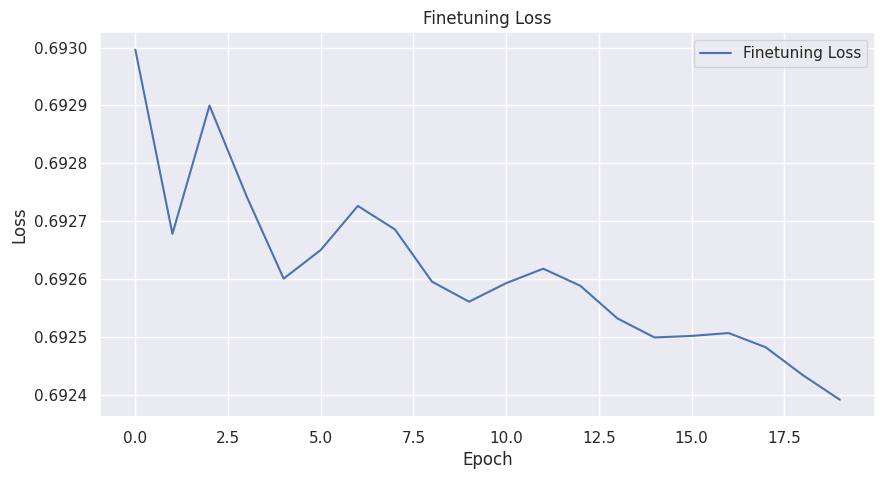

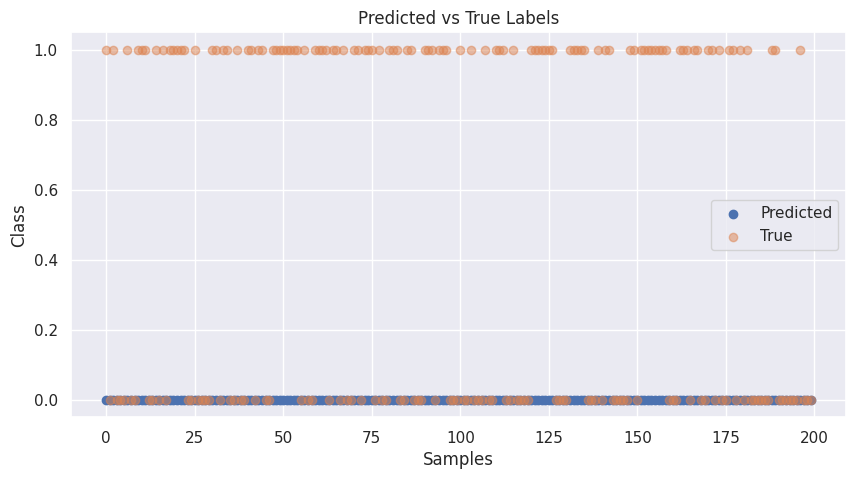

In [114]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Define the RBM class
class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden):
        super(RBM, self).__init__()
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.W = nn.Parameter(torch.randn(n_hidden, n_visible) * 0.01)
        self.h_bias = nn.Parameter(torch.zeros(n_hidden))
        self.v_bias = nn.Parameter(torch.zeros(n_visible))

    def sample_h(self, v):
        h_prob = torch.sigmoid(F.linear(v, self.W, self.h_bias))
        return h_prob, torch.bernoulli(h_prob)

    def sample_v(self, h):
        v_prob = torch.sigmoid(F.linear(h, self.W.t(), self.v_bias))
        return v_prob, torch.bernoulli(v_prob)

    def contrastive_divergence(self, v, lr):
        v0 = v
        h_prob, h_sample = self.sample_h(v0)
        v_prob, v_sample = self.sample_v(h_sample)
        h_prob_1, _ = self.sample_h(v_sample)

        positive_grad = torch.matmul(h_prob.t(), v0)
        negative_grad = torch.matmul(h_prob_1.t(), v_sample)

        self.W.data += lr * (positive_grad - negative_grad) / v.size(0)
        self.v_bias.data += lr * torch.mean(v0 - v_sample, dim=0)
        self.h_bias.data += lr * torch.mean(h_prob - h_prob_1, dim=0)

        loss = torch.mean(torch.sum((v0 - v_prob) ** 2, dim=1))
        return loss.item()

# Define the DBN class
class DBN(nn.Module):
    def __init__(self, n_visible, hidden_layers, n_output):
        super(DBN, self).__init__()
        self.rbms = nn.ModuleList([RBM(n_visible if i == 0 else hidden_layers[i-1], h) for i, h in enumerate(hidden_layers)])
        self.classifier = nn.Linear(hidden_layers[-1], n_output)

    def forward(self, x):
        for rbm in self.rbms:
            x, _ = rbm.sample_h(x)
        return torch.softmax(self.classifier(x), dim=1)

    def pretrain(self, data, epochs=10, lr=0.01):
        data = data.float()  # Ensure data is float32
        for layer_num, rbm in enumerate(self.rbms):
            print(f"Pretraining RBM layer {layer_num + 1}/{len(self.rbms)}")
            layer_input = data
            if layer_num > 0:
                for prev_rbm in self.rbms[:layer_num]:
                    layer_input, _ = prev_rbm.sample_h(layer_input)
            for epoch in range(epochs):
                loss = rbm.contrastive_divergence(layer_input, lr)
                print(f"RBM Layer {layer_num + 1}, Epoch {epoch + 1}, Loss: {loss:.4f}")

# Example data preparation (replace with actual data loading)
# Replace these lines with actual data loading
X, y = torch.rand(1000, 64), torch.randint(0, 2, (1000,))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initialize DBN with two RBM layers
dbn = DBN(n_visible=64, hidden_layers=[128, 64], n_output=2)

# Pretrain RBM layers
dbn.pretrain(data=X_train, epochs=10, lr=0.01)

# Fine-tuning with backpropagation
optimizer = optim.Adam(dbn.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

epochs = 20
finetune_losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    output = dbn(X_train)
    loss = loss_fn(output, y_train)
    loss.backward()
    optimizer.step()
    finetune_losses.append(loss.item())
    print(f"Finetuning Epoch {epoch + 1}, Loss: {loss:.4f}")

# Test the model
with torch.no_grad():
    y_pred = torch.argmax(dbn(X_test), dim=1)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

# Visualizing the results
plt.figure(figsize=(10, 5))
plt.plot(finetune_losses, label='Finetuning Loss')
plt.title('Finetuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(range(len(y_test)), y_pred, label='Predicted')
plt.scatter(range(len(y_test)), y_test, label='True', alpha=0.5)
plt.title('Predicted vs True Labels')
plt.xlabel('Samples')
plt.ylabel('Class')
plt.legend()
plt.show()


In [115]:
# Modify loss function to include class weights
class_weights = torch.tensor([1.0, 1.0])  # Adjust weights as necessary
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# Fine-tuning with backpropagation
optimizer = optim.Adam(dbn.parameters(), lr=0.001)

# Fine-tuning
epochs = 20
finetune_losses = []
for epoch in range(epochs):
    dbn.train()
    optimizer.zero_grad()
    output = dbn(X_train)
    loss = loss_fn(output, y_train)
    loss.backward()
    optimizer.step()
    finetune_losses.append(loss.item())
    print(f"Finetuning Epoch {epoch + 1}, Loss: {loss:.4f}")

# Test the model
dbn.eval()
with torch.no_grad():
    y_pred = torch.argmax(dbn(X_test), dim=1)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Additional metrics
    from sklearn.metrics import classification_report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


Finetuning Epoch 1, Loss: 0.6924
Finetuning Epoch 2, Loss: 0.6926
Finetuning Epoch 3, Loss: 0.6923
Finetuning Epoch 4, Loss: 0.6924
Finetuning Epoch 5, Loss: 0.6924
Finetuning Epoch 6, Loss: 0.6922
Finetuning Epoch 7, Loss: 0.6921
Finetuning Epoch 8, Loss: 0.6921
Finetuning Epoch 9, Loss: 0.6921
Finetuning Epoch 10, Loss: 0.6920
Finetuning Epoch 11, Loss: 0.6918
Finetuning Epoch 12, Loss: 0.6918
Finetuning Epoch 13, Loss: 0.6917
Finetuning Epoch 14, Loss: 0.6916
Finetuning Epoch 15, Loss: 0.6915
Finetuning Epoch 16, Loss: 0.6913
Finetuning Epoch 17, Loss: 0.6912
Finetuning Epoch 18, Loss: 0.6911
Finetuning Epoch 19, Loss: 0.6910
Finetuning Epoch 20, Loss: 0.6908
Accuracy: 0.4850
Classification Report:
              precision    recall  f1-score   support

           0       0.48      1.00      0.65        97
           1       0.00      0.00      0.00       103

    accuracy                           0.48       200
   macro avg       0.24      0.50      0.33       200
weighted avg     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


check class imbalance

Class Distribution:
time
0.000          1
3674540.141    1
3533923.907    1
3551723.375    1
3568751.188    1
              ..
2475279.782    1
2493300.438    1
2511203.657    1
2529000.047    1
4831284.125    1
Name: count, Length: 170, dtype: int64


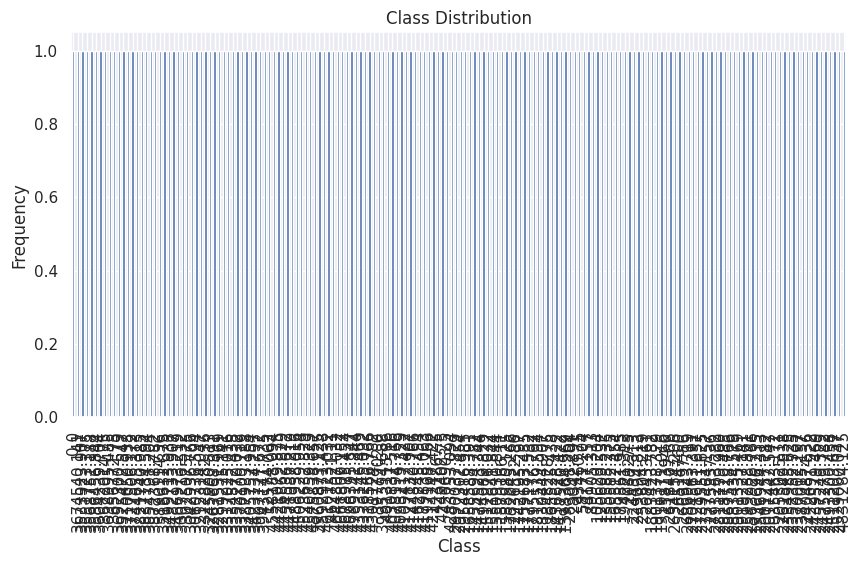

In [116]:
import matplotlib.pyplot as plt

# Assuming 'time' is the target variable
def analyze_class_distribution(df, target_column):
    if target_column in df.columns:
        class_counts = df[target_column].value_counts()
        print("Class Distribution:")
        print(class_counts)

        # Plot the class distribution
        plt.figure(figsize=(10, 5))
        class_counts.plot(kind='bar')
        plt.title('Class Distribution')
        plt.xlabel('Class')
        plt.ylabel('Frequency')
        plt.show()
    else:
        print(f"Target column '{target_column}' is missing in the DataFrame.")

# Example usage
analyze_class_distribution(charge, 'time')


In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Load data (replace with actual data loading)
def split_data(cell_number):
    num = '0' + str(cell_number) if cell_number != 18 else '18'
    df = pd.read_pickle('B00' + num + '.pkl')
    charge = df[df['type'] == 'charge']
    return charge

# Load charge data
charge = split_data(cell_number=5)

# Convert continuous target to categorical
bins = [0, 10, 20, 30]  # Adjust bins based on your data
labels = [0, 1, 2]  # Define labels for the bins
charge['time_cat'] = pd.cut(charge['time'], bins=bins, labels=labels, include_lowest=True)

# Convert DataFrame to numpy arrays
X = charge.drop(['time', 'time_cat'], axis=1).to_numpy()  # Drop old target variable
y = charge['time_cat'].to_numpy()  # Use new categorical target

# Define the resampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
undersample = RandomUnderSampler(sampling_strategy='majority')
pipeline = Pipeline([('o', oversample), ('u', undersample)])

# Resample the data
X_resampled, y_resampled = pipeline.fit_resample(X, y)

# Convert back to DataFrame if needed
charge_resampled = pd.DataFrame(X_resampled, columns=charge.columns.drop('time'))
charge_resampled['time_cat'] = y_resampled

# Analyze class distribution
def analyze_class_distribution(df, target_column):
    if target_column in df.columns:
        class_counts = df[target_column].value_counts()
        print("Class Distribution in Resampled Data:")
        print(class_counts)

        # Plot the class distribution
        plt.figure(figsize=(10, 5))
        class_counts.plot(kind='bar')
        plt.title('Class Distribution in Resampled Data')
        plt.xlabel('Class')
        plt.ylabel('Frequency')
        plt.show()
    else:
        print(f"Target column '{target_column}' is missing in the DataFrame.")

# Example usage
analyze_class_distribution(charge_resampled, 'time_cat')


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


ValueError: Input y contains NaN.